# Statistics - Inference

In [1]:
import warnings, platform
from IPython.display import display, HTML

In [2]:
### HTML display 조정
display(HTML("<style>.container {width :98% !important;}</style>"))

### Warning 제거
warnings.filterwarnings('ignore')

## Package Load

In [1]:
import random
import numpy as np
import pandas as pd

import pingouin as pg
import scipy.stats as stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns

## Inference Basics

### (1) Sampling

#### Bootstrap
- 모집단으로부터 얻은 복원추출 표본

In [124]:
loans_income = pd.read_csv("./Practical_Statictics/data/loans_income.csv").squeeze('columns')

In [125]:
from sklearn.utils import resample

In [126]:
results = []
for nrepeat in range(1000):
    sample = resample(loans_income)
    results.append(sample.median())
results = pd.Series(results)
print('Bootstrap Statistics:')
print(f'original: {loans_income.median()}')
print(f'bias: {results.mean() - loans_income.median()}')
print(f'std. error: {results.std()}')

Bootstrap Statistics:
original: 62000.0
bias: -80.74850000000151
std. error: 224.31671356752653


#### Random sampling

In [127]:
fish_5 = np.array([2, 3, 4, 5, 6])
fish_5

array([2, 3, 4, 5, 6])

In [128]:
### Sampling
print(np.random.choice(fish_5, size=1, replace=False))
print(np.random.choice(fish_5, size=3, replace=False))

[4]
[2 3 6]


In [129]:
### Random.seed
# sample 고정
np.random.seed(1)
print(np.random.choice(fish_5, size=3, replace=False))
print(np.random.choice(fish_5, size=3, replace=False))

[4 3 6]
[2 4 6]


In [130]:
### Sample mean
np.mean(np.random.choice(fish_5, size=3, replace=False))

4.0

#### Stratified sampling
- 모집단을 중복되지 않는 층으로 나눈 다음 각 층에서 표본 추출

In [131]:
df = pd.DataFrame({'team': ['A', 'A', 'A', 'A', 'B', 'B', 'B', 'B'],
                   'position': ['G', 'G', 'F', 'G', 'F', 'F', 'C', 'C'],
                   'assists': [5, 7, 7, 8, 5, 7, 6, 9],
                   'rebounds': [11, 8, 10, 6, 6, 9, 6, 10]})
df.head()

team position  assists  rebounds
0    A        G        5        11
1    A        G        7         8
2    A        F        7        10
3    A        G        8         6
4    B        F        5         6

In [132]:
df.groupby('team', group_keys=False).apply(lambda x: x.sample(2))

team position  assists  rebounds
2    A        F        7        10
0    A        G        5        11
7    B        C        9        10
4    B        F        5         6

In [133]:
#define total sample size desired
N = 4

# perform stratified random sampling
df.groupby('team', group_keys=False).apply(lambda x: x.sample(int(np.rint(N*len(x)/len(df))))).sample(frac=1).reset_index(drop=True)

team position  assists  rebounds
0    A        G        7         8
1    B        F        7         9
2    B        C        9        10
3    A        G        8         6

#### Cluster sampling
- 집단을 일차적으로 표집한 다음, 선정된 각 집단에서 구성원을 표본으로 추출하는 다단계 표집방법

In [134]:
#create DataFrame
df = pd.DataFrame({'tour': np.repeat(np.arange(1,11), 20),
                   'experience': np.random.normal(loc=7, scale=1, size=200)})

#view first six rows of DataFrame
df.head()

tour  experience
0     1    8.462108
1     1    4.939859
2     1    6.677583
3     1    6.615946
4     1    8.133769

In [135]:
#randomly choose 4 tour groups out of the 10
clusters = np.random.choice(np.arange(1,11), size=4, replace=False)

#define sample as all members who belong to one of the 4 tour groups
cluster_sample = df[df['tour'].isin(clusters)]

#view first six rows of sample
cluster_sample.head()

tour  experience
20     2    6.308339
21     2    6.603246
22     2    6.312827
23     2    6.154794
24     2    6.328754

In [136]:
cluster_sample['tour'].value_counts()

2     20
7     20
8     20
10    20
Name: tour, dtype: int64

#### Systemetic sampling
- 첫 번째 요소는 무작위로 선정한 후 목록의 매번 k번째 요소를 표본으로 선정하는 표집방법
- 모집단의 크기를 원하는 표본의 크기로 나누어 표집간격 k 계산

In [137]:
import string

In [138]:
#create simple function to generate random last names
def random_names(size=6, chars=string.ascii_uppercase):
    return ''.join(random.choice(chars) for _ in range(size))

#create DataFrame
df = pd.DataFrame({'last_name': [random_names() for _ in range(500)],
                   'GPA': np.random.normal(loc=85, scale=3, size=500)})

#view first six rows of DataFrame
df.head()

last_name        GPA
0    RONEQI  88.385569
1    AFPRLX  85.383065
2    UGISRX  84.785720
3    IBYQOJ  83.262146
4    PMBOAE  86.491009

In [139]:
#obtain systematic sample by selecting every 5th row
sys_sample_df = df.iloc[::5]

#view first six rows of DataFrame
sys_sample_df.head()

last_name        GPA
0     RONEQI  88.385569
5     TCBURQ  88.410757
10    LDGXHJ  85.640342
15    XMKLAR  87.754813
20    PIKPQK  80.507397

In [140]:
#view dimensions of data frame
sys_sample_df.shape

(100, 2)

### (2) Sampling distribution

In [141]:
# 분포에서 샘플링
sampling_norm = stats.norm.rvs(loc=4, scale=0.8, size=10)
sampling_norm

array([3.62099337, 4.85174705, 3.8966078 , 2.80347492, 3.516034  ,
       2.99126696, 3.77920671, 5.34418476, 3.83267662, 3.56487145])

In [142]:
np.mean(sampling_norm)

3.8201063630128202

In [143]:
# 평균 4, 표준편차 0.8인 정규분포
population = stats.norm(loc=4, scale=0.8)

In [144]:
# 표본평균 여러 번 계산하기
sample_mean_array = np.zeros(10000)
np.random.seed(1)
for i in range(0, 10000):
    sample = population.rvs(size=10)
    sample_mean_array[i] = np.mean(sample)

sample_mean_array

array([3.92228729, 3.86432929, 4.06953003, ..., 4.13616562, 4.57489661,
       4.09896685])

In [145]:
# Sample의 평균과 표준편차
print(np.mean(sample_mean_array), np.std(sample_mean_array, ddof=1))

4.004202422791747 0.2513580850860402


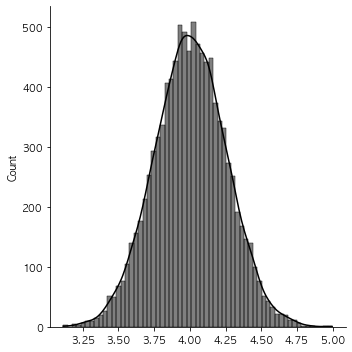

In [146]:
sns.displot(sample_mean_array, color='black', kde=True)
plt.show()

In [147]:
### Sample size에 따른 평균과 표준편차의 변화
size_array = np.arange(start=10, stop=100100, step=100)
sample_mean_array_size = np.zeros(len(size_array))

np.random.seed(1)
for i in range(0, len(size_array)):
    sample = population.rvs(size = size_array[i])
    sample_mean_array_size[i] = np.mean(sample)

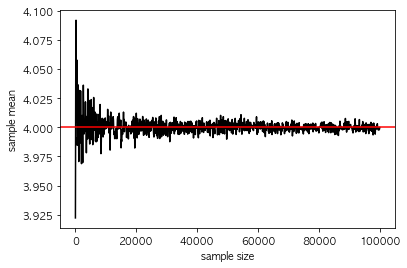

In [148]:
sns.lineplot(x=size_array, y=sample_mean_array_size, color='black')
plt.axhline(4, color='red')
plt.xlabel("sample size")
plt.ylabel("sample mean")
plt.show()

In [149]:
# 표본평균 계산 함수
def calc_sample_mean(size, n_trial):
    sample_mean_array = np.zeros(n_trial)
    for i in range(0, n_trial):
        sample = population.rvs(size=size)
        sample_mean_array[i] = np.mean(sample)
    return(sample_mean_array)

In [150]:
# 10000개 표본평균의 평균
np.random.seed(1)
np.mean(calc_sample_mean(size=10, n_trial=10000))

4.004202422791747

In [151]:
# Sample size와 표본평균
np.random.seed(1)

size_10 = calc_sample_mean(size=10, n_trial=10000)
size_10_df = pd.DataFrame({
    "sample_mean":size_10,
    "size"       :np.tile("size 10", 10000)
})

size_20 = calc_sample_mean(size=20, n_trial=10000)
size_20_df = pd.DataFrame({
    "sample_mean":size_20,
    "size"       :np.tile("size 20", 10000)
})

size_30 = calc_sample_mean(size=30, n_trial=10000)
size_30_df = pd.DataFrame({
    "sample_mean":size_30,
    "size"       :np.tile("size 30", 10000)
})


sim_result = pd.concat([size_10_df, size_20_df, size_30_df])

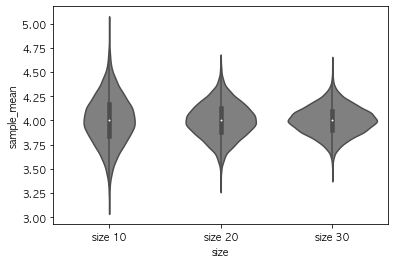

In [152]:
sns.violinplot(x="size", y="sample_mean", data=sim_result, color='gray')
plt.show()

In [153]:
# 표본평균의 표준편차
size_array = np.arange(start=2, stop=102, step=2)
sample_mean_std_array = np.zeros(len(size_array))

np.random.seed(1)
for i in range(0, len(size_array)):
    sample_mean = calc_sample_mean(size=size_array[i], n_trial=100)
    sample_mean_std_array[i] = np.std(sample_mean, ddof=1)

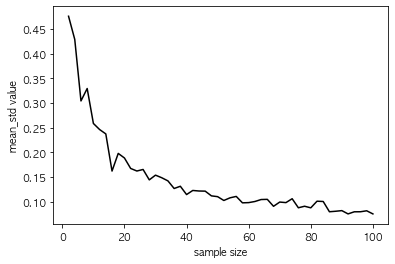

In [154]:
sns.lineplot(x=size_array, y=sample_mean_std_array, color='black')
plt.xlabel("sample size")
plt.ylabel("mean_std value")
plt.show()

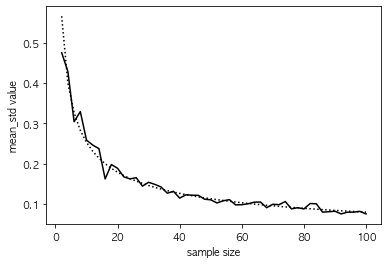

In [155]:
# Standard error
standard_error = 0.8 / np.sqrt(size_array)
sns.lineplot(x=size_array, y=sample_mean_std_array, color='black')
sns.lineplot(x=size_array, y=standard_error, color='black', linestyle='dotted')
plt.xlabel("sample size")
plt.ylabel("mean_std value")
plt.show()

In [156]:
# 표본분산의 평균 (Unbiased variance)
sample_var_array = np.zeros(10000)
np.random.seed(1)
for i in range(0, 10000):
    sample = population.rvs(size=10)
    sample_var_array[i] = np.var(sample, ddof=1)
    
np.mean(sample_var_array)

0.6385429863702334

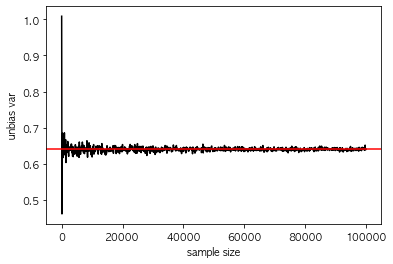

In [157]:
# 표본분산과 모분산의 관계
size_array =  np.arange(start=10, stop=100100, step=100)
unbias_var_array_size = np.zeros(len(size_array))
np.random.seed(1)
for i in range(0, len(size_array)):
    sample = population.rvs(size=size_array[i])
    unbias_var_array_size[i] = np.var(sample, ddof=1)
    
sns.lineplot(x=size_array, y=unbias_var_array_size, color='black')
plt.axhline(0.8**2, color='red')
plt.xlabel("sample size")
plt.ylabel("unbias var")
plt.show()

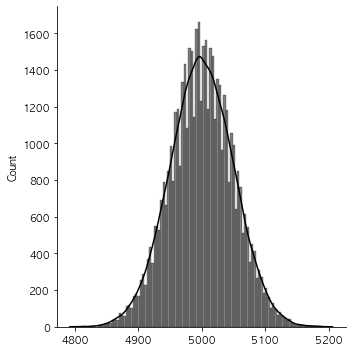

In [158]:
### Central Limit Theorem
n_size = 10000
n_trial = 50000

coin = np.array([0, 1])
count_coin = np.zeros(n_trial)
np.random.seed(1)
for i in range(0, n_trial):
    count_coin[i] = np.sum(np.random.choice(coin, size=n_size, replace=True))

sns.displot(count_coin, color='black', kde=True)
plt.show()

In [159]:
sample_data = pd.DataFrame({
    'income': loans_income.sample(1000),
    'type': 'Data',
})

sample_mean_05 = pd.DataFrame({
    'income': [loans_income.sample(5).mean() for _ in range(1000)],
    'type': 'Mean of 5',
})

sample_mean_20 = pd.DataFrame({
    'income': [loans_income.sample(20).mean() for _ in range(1000)],
    'type': 'Mean of 20',
})

results = pd.concat([sample_data, sample_mean_05, sample_mean_20])
results.head()

income  type
43759  26000.0  Data
46518  63000.0  Data
4776   20800.0  Data
28700  70000.0  Data
16657  85000.0  Data

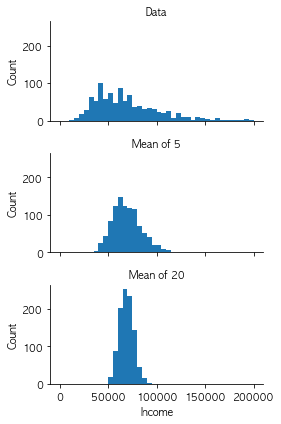

In [160]:
g = sns.FacetGrid(results, col='type', col_wrap=1, height=2, aspect=2)
g.map(plt.hist, 'income', range=[0, 200000], bins=40)
g.set_axis_labels('Income', 'Count')
g.set_titles('{col_name}')

plt.tight_layout()
plt.show()

## Estimation
- Point estimation
- Interval estimation

In [161]:
fish = pd.read_csv("./stats_for_python/3-7-1-fish_length.csv")["length"]

### (1) Point estimation

In [162]:
# mean
mu = np.mean(fish)
mu

4.187039324504523

In [163]:
# variance
sigma_2 = np.var(fish, ddof=1)
sigma_2

0.6803017080832623

### (2) Interval estimation

In [164]:
### 표본평균에 대한 구간추정
# 정규분포로 구간추정: 모표준편차가 알려진 경우
data = np.random.randint(10, 30, 50)

# create 95% confidence interval for population mean
# sem: standard error of the mean
stats.norm.interval(alpha=0.95, loc=np.mean(data), scale=stats.sem(data))

(17.621531444065983, 20.338468555934018)

In [165]:
# T분포로 구간추정: 모표준편차를 모르는 경우 & 모집단은 정규분포 가정
df = len(fish) - 1 # Degree of Freedom: n - 1
sigma = np.std(fish, ddof=1)
se = sigma / np.sqrt(len(fish))

# 신뢰계수(alpha), df, 표본평균, 표준오차
interval = stats.t.interval(alpha=0.95, df=df, loc=mu, scale=se)
interval

(3.5970100568358245, 4.777068592173221)

In [166]:
### 표본표준편차, 신뢰도, 샘플 개수에 따른 구간의 길이
# 표본표준편차 * 10
se2 = (sigma*10) / np.sqrt(len(fish))
stats.t.interval(alpha=0.95, df=df, loc=mu, scale=se2)

(-1.7132533521824618, 10.087332001191509)

In [167]:
# 샘플 개수
df2 = (len(fish)*10) - 1
se3 = sigma / np.sqrt(len(fish)*10)
stats.t.interval(alpha=0.95, df=df2, loc=mu, scale=se3)

(4.0233803082774395, 4.350698340731607)

In [168]:
# 신뢰도
stats.t.interval(alpha=0.99, df=df, loc=mu, scale=se)

(3.3393979149413973, 5.034680734067649)

In [169]:
### Interval estimation 해석
# 여러 번 추정 수행 시, 신뢰구간이 모평균을 포함하는 비율
be_included_array = np.zeros(20000, dtype = "bool")

np.random.seed(1)
norm_dist = stats.norm(loc=4, scale=0.8)
for i in range(0, 20000):
    sample = norm_dist.rvs(size=10)
    df = len(sample) - 1
    mu = np.mean(sample)
    std = np.std(sample, ddof=1)
    se = std / np.sqrt(len(sample))
    interval = stats.t.interval(0.05, df, mu, se)
    if(interval[0] <= 4 and interval[1] >= 4):
        be_included_array[i] = True

In [170]:
sum(be_included_array) / len(be_included_array)

0.0501

68760.51844


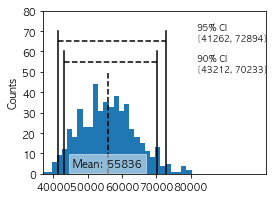

In [171]:
# CI 도식화
print(loans_income.mean())

np.random.seed(seed=3)
# create a sample of 20 loan income data
sample20 = resample(loans_income, n_samples=20, replace=False)

results = []
for nrepeat in range(500):
    sample = resample(sample20)
    results.append(sample.mean())
results = pd.Series(results)

confidence_interval = list(results.quantile([0.05, 0.95]))
ax = results.plot.hist(bins=30, figsize=(4, 3), color='C1')
ax.plot(confidence_interval, [55, 55], color='black', linestyle='--')
for x in confidence_interval:
    ax.plot([x, x], [0, 60], color='black')
ax.text(82000, 50, 
        f'90% CI\n[{confidence_interval[0]:.0f}, {confidence_interval[1]:.0f}]',
       fontsize='small')

confidence_interval = list(results.quantile([0.025, 0.975]))
ax = results.plot.hist(bins=30, figsize=(4, 3))
ax.plot(confidence_interval, [65, 65], color='black', linestyle='--')
for x in confidence_interval:
    ax.plot([x, x], [0, 70], color='black')
ax.text(82000, 65, f'95% CI\n[{confidence_interval[0]:.0f}, {confidence_interval[1]:.0f}]',
       fontsize='small')

meanIncome = results.mean()
ax.plot([meanIncome, meanIncome], [0, 50], color='black', linestyle='--')
ax.text(meanIncome, 5, f'Mean: {meanIncome:.0f}',
        bbox=dict(facecolor='white', edgecolor='white', alpha=0.5),
        horizontalalignment='center', verticalalignment='center')
ax.set_ylim(0, 80)
ax.set_xlim(37000, 102000)
ax.set_xticks([40000, 50000, 60000, 70000, 80000])
ax.set_ylabel('Counts')
plt.show()

In [172]:
### Bootstraping for CI
def bootstrap(data, n=1000, func=np.mean,p=0.95):
    sample_size = len(data)
    simulations = [func(np.random.choice(data, size=sample_size, replace=True)) for i in range(n)]
    simulations.sort()
    u_pval = (1+p)/2.
    l_pval = (1-u_pval)
    l_indx = int(np.floor(n*l_pval))
    u_indx = int(np.floor(n*u_pval))
    return (simulations[l_indx], simulations[u_indx])

x = np.array([0.02288081, 0.44170839, 0.10549733, 0.17515196, 0.09449279, 0.07110412, 0.00893079, 0.23485109, 0.14533192, 0.05449631])

# for median, 95% confidence interval, do 
bootstrap(x, 1000, np.median, 0.95)

(0.03868856, 0.190091505)

In [173]:
### 표본비율 구간추정
# p-hat = x-bar/n
# 표준오차: sqrt(p(1-p)/n) -> p를 p-hat으로 대체하여 사용
# X ~ B(n, p)이므로, Z = (X - np)/sqrt(np(1-p)) ~ N(0, 1)

p_hat = 41/500
se = np.sqrt((p_hat*(1 - p_hat))/500)
stats.norm.interval(alpha=0.95, loc=p_hat, scale=se)

(0.05795131379112069, 0.10604868620887932)

In [174]:
from statsmodels.stats.proportion import proportion_confint

In [175]:
proportion_confint(41, 500, alpha=0.05, method='normal') # 동일한 결과

(0.05795131379112069, 0.10604868620887932)

In [176]:
### 분산과 표준편차 구간추정
# 모집단의 정규분포 가정 필수
# (n-1)(s**2)/sigma**2 ~ chisq(n-1)
# (n-1)(s**2)/chisq(alpha/2)(n-1) < sigma**2 < (n-1)(s**2)/chisq(1-alpha/2)(n-1)
alpha=0.05
n = len(fish)
var = np.var(fish)
interval = ((n - 1) * var)/stats.chi2.ppf(1-(alpha/2), df=n-1), ((n - 1) * var)/stats.chi2.ppf(alpha/2, df=n-1)
interval

(0.28967623922045205, 2.040610747269794)

In [177]:
### 독립적인 두 개 집단의 차이 구간추정
# 표본이 큰 경우
data_1 = np.random.randint(10, 30, 50)
data_2 = np.random.randint(15, 30, 50)

stats.norm.interval(alpha=0.95, loc=np.mean(data_1 - data_2), scale=np.var(data_1)/len(data_1) + np.var(data_2)/len(data_2))

(-3.7841923043994887, -0.05580769560051113)

In [178]:
# 표본이 작은 경우
# 정규분포 가정이 필수. 정규분포 가정이 없으면 비모수적 방법 사용
# 비모수적 방법..?
data_1 = np.random.normal(10, 5, 15)
data_2 = np.random.normal(15, 5, 10)

n_1 = len(data_1)
n_2 = len(data_2)
s_pooled = ((n_1 - 1)*np.var(data_1) + (n_2 - 1)*np.var(data_2)) / (n_1 + n_2 - 2)
mean_diff = np.mean(data_1) - np.mean(data_2)
stats.t.interval(alpha=0.95, df=n_1 + n_2 - 2, loc=mean_diff, scale=np.sqrt(s_pooled)*np.sqrt((1/n_1) + (1/n_2))) # 분산이 같은 경우
### print(mean_diff - stats.t.ppf(0.975, df=n_1 + n_2 -2)* np.sqrt(s_pooled)* np.sqrt((1/n_1) + (1/n_2)), mean_diff + stats.t.ppf(0.975, df=n_1 + n_2 -2)* np.sqrt(s_pooled)* np.sqrt((1/n_1) + (1/n_2)))

(-12.333244376997158, -5.285346670308378)

In [179]:
### Non-parametric: Mann-whitney test's CI
ct1 = len(data_1)  #items in dataset 1
ct2 = len(data_2)  #items in dataset 2
alpha = 0.05       #95% confidence interval
N = stats.norm.ppf(1 - alpha/2) # percent point function - inverse of cdf

# The confidence interval for the difference between the two population
# medians is derived through these nxm differences.
diffs = sorted([i-j for i in data_1 for j in data_2])

# For an approximate 100(1-a)% confidence interval first calculate K:
k = int(round(ct1*ct2/2 - (N * (ct1*ct2*(ct1+ct2+1)/12)**0.5)))

# The Kth smallest to the Kth largest of the n x m differences 
# ct1 and ct2 should be > ~20
CI = (diffs[k], diffs[len(diffs)-k])
CI

(-12.464770929509829, -5.581755867966136)

In [180]:
# df = min([n_1, n_2]) 를 사용하기도 함
df = ((np.var(data_1)/n_1) + (np.var(data_2)/n_2))**2 / (((np.var(data_1)/n_1)**2/(n_1 - 1)) + ((np.var(data_2)/n_2)**2/(n_1 - 1))) 
stats.t.interval(alpha=0.95, df=df, loc=mean_diff, scale=np.sqrt((np.var(data_1)/n_1) + (np.var(data_2)/n_2))) # 분산이 다른 경우에는 신뢰구간이 조금 더 넓어짐

(-12.186709281474773, -5.431881765830762)

In [181]:
### 두 개 집단의 비율 차이 구간추정
# Z = (p-hat_1 - p-hat_2)/sqrt(((p_1*(1-p_1))/n_1) + ((p_2*(1-p_2))/n_2)) ~ N(0, 1)
p_1 = 0.6
p_2 = 0.5
n_1 = 10
n_2 = 12

se = np.sqrt(((p_1*(1 - p_1))/n_1) + ((p_2*(1 - p_2))/n_2))
stats.norm.interval(alpha=0.95, loc=np.mean(p_1 - p_2), scale=se)

(-0.3150004864990562, 0.5150004864990562)

In [182]:
import math

In [183]:
### 상관계수 구간추정
def r_to_z(r):
    return math.log((1 + r) / (1 - r)) / 2.0

def z_to_r(z):
    e = math.exp(2 * z)
    return((e - 1) / (e + 1))

def r_confidence_interval(r, alpha, n):
    z = r_to_z(r)
    se = 1.0 / math.sqrt(n - 3)
    z_crit = stats.norm.ppf(1 - alpha/2)  # 2-tailed z critical value

    lo = z - z_crit * se
    hi = z + z_crit * se

    # Return a sequence
    return (z_to_r(lo), z_to_r(hi))

r = pd.DataFrame([data_1, data_2]).T.corr()[0][1]
print(r)
print(r_confidence_interval(r, 0.05, n_1))

0.08989208009982357
(-0.5721150255499518, 0.6809762047226975)


### (3) Estimate sample size
- 오차한계: d
- 모평균 추정의 sample size
    - Z 검정 (모분산을 알고 있거나, 표본이 충분히 큰 경우): n >= (Z(2/a)*sigma/d)**2
- 모비율 추정의 sample size
    - n >= ((Z(2/a)/d)**2)*p*(1-p)
    - p를 알고 있거나, 추정이 가능하다면 해당 값을 쓰고, 추정이 불가능하다면 가장 보수적으로 표본 개수를 잡을 수 있는 p=0.5 사용

In [184]:
### 모평균 추정 시 표본 크기
d = 0.75
sigma = 4
alpha = 0.1

math.ceil((stats.norm.ppf(1-(alpha/2))*sigma/d)**2)

77

In [185]:
### 모비율 추정 시 표본 크기
d = 0.05
alpha = 0.02
p = 0.5 # 최대 표본 p

math.ceil(p*(1-p)*(stats.norm.ppf(1-(alpha/2))/0.05)**2)

542

## Testing
- 귀무가설과 대립가설
- P-value
- 유의수준
- 단측검정/양측검정
    - alternative: less, greater(larger) / two-sided
- 제 1종 오류와 제 2종 오류: 1종 오류만 컨트롤 가능
- 신뢰구간과 양측검정
    - 신뢰구간 안에 검정할 모수가 들어가면 귀무가설 기각하지 않음

### (1) Resampling and Permutation test
- 두 개 이상의 표본을 결합하여 관측값을 무작위로(또는 전체를) 추출하는 과정
- 관측 데이터로부터 반복해서 표본추출

In [186]:
### T-test
session_times = pd.read_csv("./Practical_Statictics/data/web_page_data.csv")
session_times.Time = 100 * session_times.Time

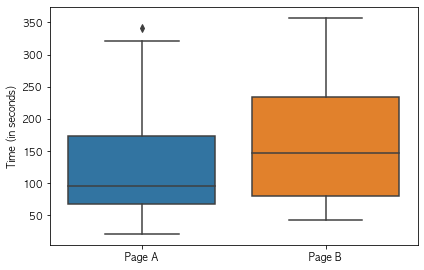

In [187]:
sns.boxplot(x='Page', y='Time', data=session_times)
plt.xlabel('')
plt.ylabel('Time (in seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()

In [188]:
# 관측된 차이
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(mean_b - mean_a)

35.66666666666667


In [189]:
import random

In [190]:
# Permutation test example with stickiness
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()
    
nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]
print(perm_fun(session_times.Time, nA, nB))

74.52380952380952


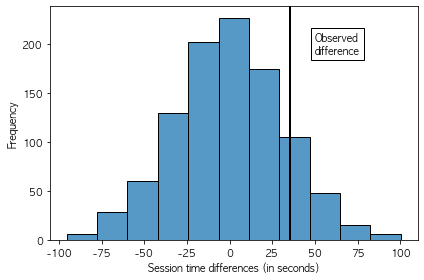

In [191]:
random.seed(1)
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

sns.histplot(x=perm_diffs, bins=11)
plt.axvline(x = mean_b - mean_a, color='black', lw=2)
plt.text(50, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
plt.xlabel('Session time differences (in seconds)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [192]:
# convert perm_diffs to numpy array
perm_diffs = np.array(perm_diffs)
np.mean(perm_diffs > mean_b - mean_a)

0.121

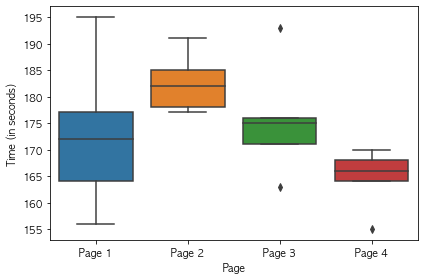

In [193]:
### ANOVA
four_sessions = pd.read_csv("./Practical_Statictics/data/four_sessions.csv")

sns.boxplot(x='Page', y='Time', data=four_sessions)
plt.xlabel('Page')
plt.ylabel('Time (in seconds)')
plt.title('')
plt.tight_layout()
plt.show()

In [194]:
observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)
# Permutation test example with stickiness
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    
    return df.groupby('Page').mean().var()[0]
    
print(perm_test(four_sessions))

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
52.06666666666664


Pr(Prob) 0.09033333333333333


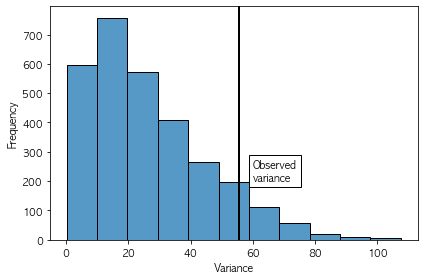

In [195]:
random.seed(1)
perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

sns.histplot(x=perm_variance, bins=11)
plt.axvline(x = observed_variance, color='black', lw=2)
plt.text(60, 200, 'Observed\nvariance', bbox={'facecolor':'white'})
plt.xlabel('Variance')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [196]:
### Chi-sq test
click_rate = pd.read_csv("./Practical_Statictics/data/click_rates.csv")
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
clicks

Headline  Headline A  Headline B  Headline C
Click                                       
Click             14           8          12
No-click         986         992         988

In [197]:
row_average = clicks.mean(axis=1)
pd.DataFrame({
    'Headline A': row_average,
    'Headline B': row_average,
    'Headline C': row_average,
})

Headline A  Headline B  Headline C
Click                                       
Click      11.333333   11.333333   11.333333
No-click  988.666667  988.666667  988.666667

In [198]:
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                  for observe in row])
    # return sum of squares
    return np.sum(pearson_residuals)

expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [expected_clicks, expected_noclicks]
chi2observed = chi2(clicks.values, expected)

def perm_fun(box):
    random.shuffle(box)
    sample_clicks = [sum(box[0:1000]),
                     sum(box[1000:2000]),
                     sum(box[2000:3000])]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6659
Resampled p-value: 0.4660


In [199]:
expected = [expected_clicks, expected_noclicks]
def sample_with_replacement(box):
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [sample_with_replacement(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6659
Resampled p-value: 0.4845


### (2) Statistical test
- 일부만 수록하고, 자세한 내용은 아래에서 확인

In [200]:
# One sample test
junk_food = pd.read_csv("./stats_for_python/3-8-1-junk-food-weight.csv")["weight"]
junk_food.head()

0    58.529820
1    52.353039
2    74.446169
3    52.983263
4    55.876879
Name: weight, dtype: float64

귀무가설: 봉지과자의 평균중량은 50g이다 <br>
대립가설: 봉지과자의 평균중량은 50g이 아니다

In [201]:
# T-test는 모집단의 정규분포 가정 필요
stats.ttest_1samp(junk_food, 50, alternative='two-sided')

Ttest_1sampResult(statistic=2.750339683171343, pvalue=0.012725590012524182)

In [202]:
# Paired test
paired_test_data = pd.read_csv("./stats_for_python/3-9-1-paired-t-test.csv")
print(paired_test_data)

  person medicine  body_temperature
0      A   before              36.2
1      B   before              36.2
2      C   before              35.3
3      D   before              36.1
4      E   before              36.1
5      A    after              36.8
6      B    after              36.1
7      C    after              36.8
8      D    after              37.1
9      E    after              36.9


In [203]:
# 데이터 정리
before = np.array(paired_test_data.query('medicine == "before"')["body_temperature"])
after = np.array(paired_test_data.query('medicine == "after"')["body_temperature"])

diff = after - before
diff

array([ 0.6, -0.1,  1.5,  1. ,  0.8])

귀무가설: 약을 먹기 전과 후의 체온에는 차이가 없다 (d=0) <br>
대립가설: 약이 먹기 전과 후의 체온에는 차이가 있다 (d!=0)

In [204]:
stats.ttest_1samp(diff, 0)

Ttest_1sampResult(statistic=2.901693483620596, pvalue=0.044043109730074276)

In [205]:
stats.ttest_rel(after, before)

Ttest_relResult(statistic=2.901693483620596, pvalue=0.044043109730074276)

In [206]:
### Chi-sq test
click_data = pd.read_csv("./stats_for_python/3-10-1-click_data.csv")
print(click_data)

  color  click  freq
0  blue  click    20
1  blue    not   230
2   red  click    10
3   red    not    40


In [207]:
# 분할표 생성
cross = pd.pivot_table(
    data=click_data,
    values="freq",
    aggfunc="sum",
    index="color",
    columns="click")
cross

click  click  not
color            
blue      20  230
red       10   40

In [208]:
# 동질성 검정
stats.chi2_contingency(cross, correction=False) # 통계량, p-value, df, expected table

(6.666666666666666,
 0.009823274507519247,
 1,
 array([[ 25., 225.],
        [  5.,  45.]]))

In [209]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


In [210]:
from statsmodels.stats import power

In [211]:
### Test power
# 일정 수준 이상의 power를 얻기 위한 표본 수 계산
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011) # p1, p2
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, alpha=0.05, power=0.8, alternative='larger') # 단측 검정
print('Sample Size: %.3f' % result)

Sample Size: 116602.393


In [212]:
effect_size = sm.stats.proportion_effectsize(0.0165, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 5488.408


### (3) Non-parametric Statistics
- 모수의 형태를 가정하지 않는 통계로, 약간의 검정력 손해가 있음
- 사용 범위
    - 범주형 데이터
    - 극단값이 존재하는 경우
    - 모수 검정의 가정을 만족하지 못하는 경우

## Pre-test Analysis
- 통계분석 전 사전 수행해야 하는 test
- 정규성 확인, 등분산성 확인 등

### (1) Normality

귀무가설(H0) <br>
데이터의 분포는 정규분포를 따른다.<br>
대립가설(H1)<br>
데이터의 분포는 정규분포를 따르지 않는다.<br>

In [213]:
cats = pd.read_csv('./ADP_book_ver01/data/cats.csv')

In [214]:
cats.head()

Sex  Bwt  Hwt
0   F  2.0  7.0
1   F  2.0  7.4
2   F  2.0  9.5
3   F  2.1  7.2
4   F  2.1  7.3

#### Shapiro-wilk test

In [215]:
stats.shapiro(cats['Bwt'])

ShapiroResult(statistic=0.9518786668777466, pvalue=6.730248423991725e-05)

#### Kolmogorov-smirnov (K-S) test
- 두 집단의 분포 비교. 데이터와 Normal distribution 제시

In [216]:
stats.kstest(cats['Bwt'], stats.norm.cdf)

KstestResult(statistic=0.9772498680518208, pvalue=5.089961007561737e-237)

#### Anderson-darling test
- 데이터 개수가 많은 경우 (5000개 이상?)

In [217]:
stats.anderson(cats['Bwt'], dist='norm')

AndersonResult(statistic=1.9228438994888393, critical_values=array([0.561, 0.639, 0.767, 0.894, 1.064]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

[결과해석] <br>
유의수준보다 작으므로 '데이터가 정규분포를 따른다'는 귀무가설을 기각한다. 즉, cats 데이이터의 Bwt 변수는 정규분포를 따르지 않는다.

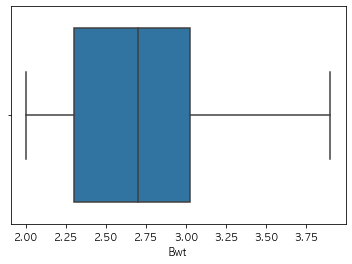

In [218]:
### Boxplot
sns.boxplot(x=cats.Bwt)
plt.show()

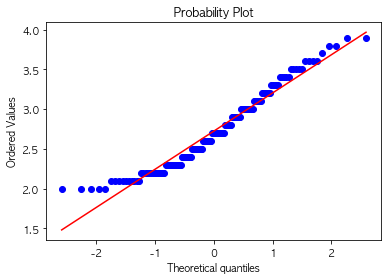

In [219]:
### Q-Q plot
stats.probplot(cats.Bwt, dist="norm", plot=plt)
plt.show()

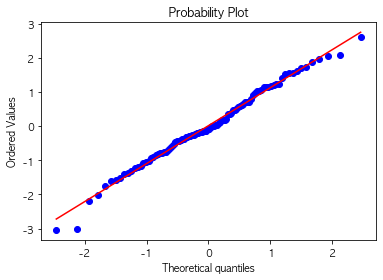

In [220]:
stats.probplot(stats.norm.rvs(size=100), plot=plt)
plt.show()

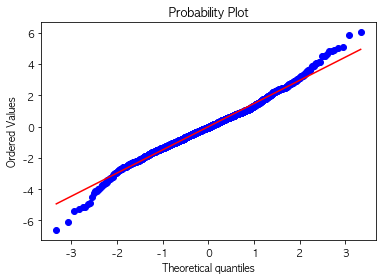

In [221]:
# not normal: 긴 꼬리 분포
nflx = sp500_px.NFLX
nflx = np.diff(np.log(nflx[nflx > 0]))

stats.probplot(nflx, plot=plt)
plt.show()

In [222]:
### Skewness, Kurtosis
# Normal의 왜도, 첨도는 0, 3
cats.Bwt.skew()

0.47862437175650524

In [223]:
cats.Bwt.kurtosis()

-0.6738392606733399

### (2) Equal variance

귀무가설(H0) <br>
집단 간 분산 차이가 없다.<br>
대립가설(H1)<br>
집단 간 분산 차이가 있다.<br>

In [224]:
female = cats.loc[cats.Sex=='F', 'Bwt']
male = cats.loc[cats.Sex=='M', 'Bwt']

#### Levene test
- 모집단이 정규분포가 아닌 경우에도 사용할 수 있음
- median 척도가 default -> Brown-Forsythe test

In [225]:
stats.levene(female, male, center='mean')

LeveneResult(statistic=17.201368589463517, pvalue=5.759437452845422e-05)

In [226]:
stats.levene(female, male)

LeveneResult(statistic=19.43101190877999, pvalue=2.0435285255189404e-05)

#### Fligner test
- 모집단이 정규분포가 아닌 경우에도 사용할 수 있음. (Levene 보다 더 Robust test)

In [227]:
stats.fligner(female, male, center='mean')

FlignerResult(statistic=16.302435204533868, pvalue=5.399451767224612e-05)

In [228]:
stats.fligner(female, male)

FlignerResult(statistic=16.909233669160688, pvalue=3.921038124917857e-05)

#### Bartlett test
- 정규성 필요. 모집단이 정규분포인 경우 정확도가 높음
- 집단 내 데이터 수가 달라도 가능

In [229]:
stats.bartlett(female, male)

BartlettResult(statistic=15.074702450407873, pvalue=0.00010333894088535893)

#### F-test
- 두 집단 분산의 비율 검정
- 정규성 필요
- Two sample test 파트 참조

## Sample tests
- 한 개, 또는 두 개 집단 비교

### (1) One sample test
- 연속형인 한 개 집단 검정
- T-test는 모집단의 정규분포 가정이 필요하며, 정규성이 깨지면 비모수적 방법 시행

#### Binomial probability test

In [230]:
stats.binomtest(k=1, n=10, p=0.5, alternative='two-sided') # 성공횟수, 시행횟수, 성공확률

BinomTestResult(k=1, n=10, alternative='two-sided', proportion_estimate=0.1, pvalue=0.021484375)

#### Mean test
- Z-test: 데이터가 충분히 크거나 모분산을 알고 있는 경우
- T-test, Wilcoxon signed rank test (Sign test)

In [231]:
statsmodels.stats.weightstats.ztest(cats['Bwt'], x2=None, value=0, alternative='two-sided')

(67.34573724070906, 0.0)

In [232]:
cats.head()

Sex  Bwt  Hwt
0   F  2.0  7.0
1   F  2.0  7.4
2   F  2.0  9.5
3   F  2.1  7.2
4   F  2.1  7.3

Bwt 컬럼은 고양이의 몸무게를 의미하고, Hwt는 고양이의 길이를 의미한다. 
cats의 데이터의 정보를 info로 확인해준다. 

In [233]:
cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sex     144 non-null    object 
 1   Bwt     144 non-null    float64
 2   Hwt     144 non-null    float64
dtypes: float64(2), object(1)
memory usage: 3.5+ KB


shapiro test를 통해 데이터의 정규성을 검정한다. 고양이의 몸무게를 검정하므로 고양이의 몸무게만 추출하여 shapiro test를 진행해야 한다.

In [234]:
mu = 2.6
stats.shapiro(cats['Bwt'])

ShapiroResult(statistic=0.9518786668777466, pvalue=6.730248423991725e-05)

데이터가 정규분포를 따르지 않으므로 wilcox test를 진행한다. 

귀무가설(H0) <br>
고양이의 평균 몸무게는 2.6kg이다. -> 고양이의 몸무게 - 2.6kg의 평균은 0이다.<br><br>
대립가설(H1)<br>
고양이의 평균 몸무게는 2.6kg이 아니다 <br>

In [235]:
### Wilcoxon signed rank test
# 평균을 빼주는 이유는, signed rank test가 원래 paired sample용임.
# sign test도 사용 가능
stats.wilcoxon(cats.Bwt - mu, alternative='two-sided')

WilcoxonResult(statistic=3573.0, pvalue=0.02524520294814093)

H0 기각. 유의수준 0.05 하에서 고양이의 평균 몸무게는 2.6kg이라고 할 수 없다.

In [236]:
#### (참고) T-test
# stats.ttest_1samp(cats.Bwt, popmean=mu)

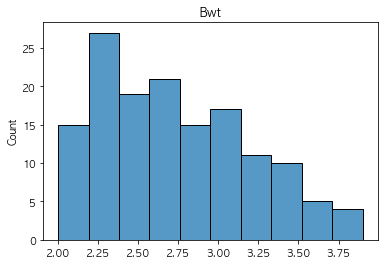

In [237]:
sns.histplot(cats.Bwt.values, bins=10)
plt.title('Bwt')
plt.ylabel('Count')
plt.show()

#### Proportion test
- 정규분포를 이용한 집단의 비율 검정

H0: p = p0 (population proportion is equal to hypothesized proportion p0)

H1 (two-tailed): p ≠ p0 (two-tailed population proportion is not equal to some hypothesized value p0) <br>
H1 (left-tailed): p < p0 (left-tailed population proportion is less than some hypothesized value p0) <br>
H1 (right-tailed): p > p0 (right-tailed population proportion is greater than some hypothesized value p0)

In [238]:
# count: 성공 횟수, nobs: 전체 시행 횟수 -> 표본비율 = count/nobs
# value: 검정할 모비율
# returns z-stat, p-value
statsmodels.stats.proportion.proportions_ztest(count=70, nobs=100, value=0.86, alternative='smaller') # smaller, larger, two-side

(-3.4914862437758782, 0.0002401705999909348)

#### Variance test
- 정규성 가정이 필수 

In [239]:
def chi_var_test(x, va0, direction="two-tailed"):
    n = len(x)
    chi_stat = (n - 1) * np.var(x) / va0 
    tmp_p = stats.chi2.cdf(chi_stat, df=n-1)
    
    if direction == "lower":
        p = tmp_p
    elif direction == "upper":
        p = 1 - tmp_p 
    else:
        p = 2*(1-tmp_p) if tmp_p > 0.5 else 2*tmp_p
    
    return chi_stat, p

x = np.random.normal(0, 2, 25)
chi_var_test(x, va0=9)

(10.129352750798532, 0.012014451885306832)

In [240]:
### if not normal
# Squared Ranks test for Variances

### (2) Paired sample test
- 단일 모집단의 어떠한 처리 전후에 따른 평균 차이 비교
- Paired T-test, Wilcoxon signed rank test

In [241]:
# 데이터 불러오기 및 확인
data = {'before':[7, 3, 4, 5, 2, 1, 6, 6, 5, 4], 'after':[8, 4, 5, 6, 2, 3, 6, 8, 6, 5]}
data = pd.DataFrame(data)
data

before  after
0       7      8
1       3      4
2       4      5
3       5      6
4       2      2
5       1      3
6       6      6
7       6      8
8       5      6
9       4      5

귀무가설(H0) <br>
수면제 복용 전과 후의 수면시간 차이는 없다. (D=0)<br>
대립가설(H1)<br>
수면제 복용 전과 후의 수면시간 차이는 있다. <br>


In [242]:
### Normality test
stats.shapiro(data.before)

ShapiroResult(statistic=0.9644595384597778, pvalue=0.8352707624435425)

In [243]:
stats.shapiro(data.after)

ShapiroResult(statistic=0.9456837177276611, pvalue=0.6177994012832642)

두 집단 다 정규성을 만족하므로, Paired T-test를 진행한다.

In [244]:
stats.ttest_rel(data['after'], data['before'], alternative='greater') # H1: D > 0

Ttest_relResult(statistic=4.743416490252569, pvalue=0.0005269356285082764)

In [245]:
data.mean()

before    4.3
after     5.3
dtype: float64

[결과해석]
p-value가 유의수준보다 작으므로 '수면영양제를 복용하기 전과 후의 평균 수면시간의 차이는 통계적으로 유의하며, 영양제를 복용한 후 수면시간이 늘었다'는 결론을 낼 수 있다. 

In [246]:
### (참고) Wilcoxon signed rank test
# 두 데이터의 차이 배열을 input으로 함
# 비모수 검정의 p-value가 높음 -> 검정력이 떨어짐
stats.wilcoxon(data['after']-data['before'], alternative='greater')

WilcoxonResult(statistic=36.0, pvalue=0.00414960799764038)

In [247]:
### (참고) Sign test
# Ordinal data
# 두 집단의 대소 비교하여, 이항검정 또는 정규근사 활용
# H0: p = 0.5
# n = 동률이 아닌 데이터 수
# z = x - np/sqrt(np(1-p)) ~ N(0, 1)

In [248]:
from statsmodels.stats import descriptivestats

In [249]:
stat, p = descriptivestats.sign_test(data['after']-data['before'], mu0=0)
print("single sample sign test p-value", p) # 양측 검정만 가능. H1: p != 0.5

single sample sign test p-value 0.0078125


In [250]:
plus = (data['after'] - data['before'] > 0).sum()
minus = (data['after'] - data['before'] < 0).sum()

stats.binomtest(k=plus, n=plus + minus, p=0.5, alternative='two-sided') # 위 결과와 동일

BinomTestResult(k=8, n=8, alternative='two-sided', proportion_estimate=1.0, pvalue=0.0078125)

In [251]:
stats.binomtest(k=plus, n=plus + minus, p=0.5, alternative='greater') # H1: p > 0.5. + 확률이 0.5보다 큰가? after의 수면시간이 더 길어지는지 검정

BinomTestResult(k=8, n=8, alternative='greater', proportion_estimate=1.0, pvalue=0.00390625)

### (3) Independent Two-sample test
- 두 개의 독립된 모집단 비교
- 표본 크기가 충분한 경우, 정규분포를 이용한 test 가능
    - X_bar - Y_bar ~ N(mu_1 - mu_2, ((sigma_1)**2/n_1 + (sigma_2)**2/n_2))
- T-test, Wilcoxon Rank sum test / Mann-Whitney U test
- T-test의 경우 집단 간 등분산 검정 먼저 수행 -> equal_var 파라미터 입력

In [252]:
# 참고: Two sample z-test
# enter IQ levels for 20 individuals from each city
cityA = [82, 84, 85, 89, 91, 91, 92, 94, 99, 99, 105, 109, 109, 109, 110, 112, 112, 113, 114, 114]
cityB = [90, 91, 91, 91, 95, 95, 99, 99, 108, 109, 109, 114, 115, 116, 117, 117, 128, 129, 130, 133]

statsmodels.stats.weightstats.ztest(cityA, cityB, value=0, alternative='two-sided')

(-1.9953236073282115, 0.046007596761332065)

In [253]:
female = cats.loc[cats.Sex=='F', 'Bwt']
male = cats.loc[cats.Sex=='M', 'Bwt']

귀무가설(H0) <br>
암컷 고양이와 수컷 고양이의 몸무게는 차이가 없다.<br>
대립가설(H1)<br>
암컷 고양이와 수컷 고양이의 몸무게는 차이가 있다. <br>

In [254]:
### Normality test
stats.shapiro(female) # not normal

ShapiroResult(statistic=0.8909613490104675, pvalue=0.0003754299250431359)

In [255]:
stats.shapiro(male)

ShapiroResult(statistic=0.9788321852684021, pvalue=0.11895745247602463)

정규성을 만족시키지 못하는 집단이 있으므로, Wilcoxon Rank sum test를 진행한다.

In [256]:
stats.ranksums(female, male, alternative='two-sided')

RanksumsResult(statistic=-6.484649068728496, pvalue=8.893855174450822e-11)

In [257]:
stats.mannwhitneyu(female, male, alternative='two-sided')

MannwhitneyuResult(statistic=757.5, pvalue=8.200502234321752e-11)

In [258]:
### (참고) Independent T-test
stats.ttest_ind(female, male, equal_var=False) # 등분산성 만족이 안 되는 경우

Ttest_indResult(statistic=-8.70948849909559, pvalue=8.831034455859356e-15)

[결과해석]
p-value가 유의수준보다 작으므로 '암컷 고양이와 수컷 고양이의 몸무게는 차이가 있다'는 결론을 낼 수 있다.

In [259]:
print(female.mean())
print(male.mean())

2.359574468085107
2.8999999999999995


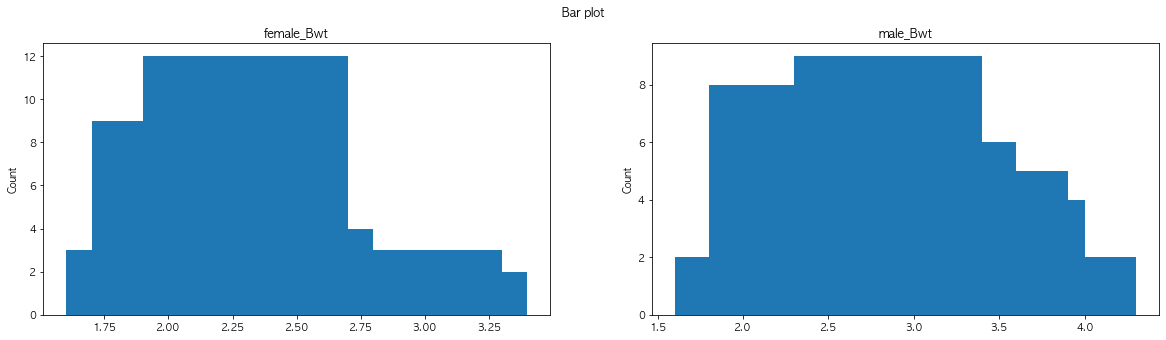

In [260]:
female_Bwt_cnt = pd.value_counts(female.values, sort=False)
male_Bwt_cnt = pd.value_counts(male.values, sort=False)

fig, axs = plt.subplots(1, 2,figsize=(20,5))
fig.suptitle('Bar plot')
width =0.4
axs[0].bar(female_Bwt_cnt.index, female_Bwt_cnt.values)
axs[0].set_title('female_Bwt')
axs[0].set_ylabel('Count')
axs[1].bar(male_Bwt_cnt.index, male_Bwt_cnt.values)
axs[1].set_title('male_Bwt')
axs[1].set_ylabel('Count')
plt.show()

In [261]:
### Proportion difference test (Z-statistic)
success_cnts = np.array([70, 80])
total_cnts = np.array([100, 120])

test_stat, pval = statsmodels.stats.proportion.proportions_ztest(count=success_cnts, nobs=total_cnts, alternative='two-sided')
print('Two sided z-test: z = {:.4f}, p value = {:.4f}'.format(test_stat, pval))

Two sided z-test: z = 0.5285, p value = 0.5971


In [262]:
### Variance difference test (F-test)
# 두 집단의 분산 차이 검정. 정규성에 민감
# 위에서 언급된 Equal Variance 검정 방법을 사용하는 것이 더 좋음
def f_var_test(x, y, direction="two-tailed"):
    df_1 = len(x)
    df_2 = len(y)
    f_stat = np.var(x, ddof=1) / np.var(y, ddof=1)
    
    tmp_p = stats.f.cdf(f_stat, df_1, df_2)
    if direction == "lower":
        p = tmp_p
    elif direction == "upper":
        p = 1 - tmp_p 
    else:
        p = 2*(1-tmp_p) if tmp_p > 0.5 else 2*tmp_p
    return f_stat, p

f_var_test(male, female)

(2.9111958307660704, 9.872708416591713e-05)

## ANOVA
- 두 개 이상의 다수 집단 간 평균 비교
- 종속변수는 연속형, 독립변수는 범주형
- 각 집단의 정규분포 가정과 집단 내 등분산 가정이 필요하며, 이 가정이 깨지면 Welch의 방법 또는 비모수적 방법 시행
- 사후 검정: 적어도 한 집단에서 평균 차이가 있음이 증명되었을 때, 어떤 집단에서 차이가 존재하는지를 알아보는 방법

### (1) One-way
- 종속변수에 대한 하나의 범주형 변수의 영향 파악
- 각 집단 간 표본의 수는 동일하지 않아도 됨
- ANOVA (F-test), Kruskal-Wallis test

In [263]:
### Simple data
weather = ["cloudy", "cloudy", "rainy", "rainy", "sunny", "sunny"]
beer = [6, 8, 2, 4, 10, 12]

weather_beer = pd.DataFrame({
    "beer"   : beer,
    "weather": weather
})

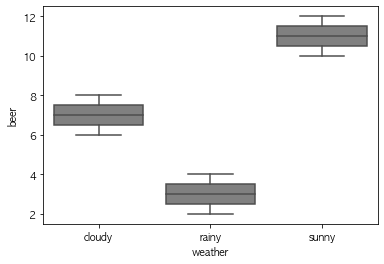

In [264]:
sns.boxplot(x="weather", y="beer", data=weather_beer, color='gray')
plt.show()

In [265]:
from statsmodels.stats.anova import anova_lm

In [266]:
anova_model = smf.ols("beer ~ weather", data=weather_beer).fit()
anova_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   beer   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     16.00
Date:                Thu, 31 Aug 2023   Prob (F-statistic):             0.0251
Time:                        12:42:35   Log-Likelihood:                -8.5136
No. Observations:                   6   AIC:                             23.03
Df Residuals:                       3   BIC:                             22.40
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.0000      1.000      7.000      0.006       3.818      10.182
weather[T.rainy]    -4.0000      1.414     -2.828      0.066      -8.501       0.501
weather[T.sunny]     4.0000      1.414      2.828      0.066      -0.501       8.501
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.333
Prob(Omnibus):                    nan   Jarque-Bera (JB):                1.000
Skew:                          -0.000   Prob(JB):                        0.607
Kurtosis:                       1.000   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [267]:
sm.stats.anova_lm(anova_model, typ=2)

sum_sq   df     F    PR(>F)
weather     64.0  2.0  16.0  0.025095
Residual     6.0  3.0   NaN       NaN

In [268]:
# Predicted
anova_model.fittedvalues

0     7.0
1     7.0
2     3.0
3     3.0
4    11.0
5    11.0
dtype: float64

In [269]:
# Residuals
anova_model.resid

0   -1.0
1    1.0
2   -1.0
3    1.0
4   -1.0
5    1.0
dtype: float64

In [270]:
anova_model.params

Intercept           7.0
weather[T.rainy]   -4.0
weather[T.sunny]    4.0
dtype: float64

In [271]:
iris = pd.read_csv("./ADP_book_ver01/data/iris.csv")
iris.head(100)

sepal length  sepal width  petal length  petal width           target
0            5.1          3.5           1.4          0.2      Iris-setosa
1            4.9          3.0           1.4          0.2      Iris-setosa
2            4.7          3.2           1.3          0.2      Iris-setosa
3            4.6          3.1           1.5          0.2      Iris-setosa
4            5.0          3.6           1.4          0.2      Iris-setosa
..           ...          ...           ...          ...              ...
95           5.7          3.0           4.2          1.2  Iris-versicolor
96           5.7          2.9           4.2          1.3  Iris-versicolor
97           6.2          2.9           4.3          1.3  Iris-versicolor
98           5.1          2.5           3.0          1.1  Iris-versicolor
99           5.7          2.8           4.1          1.3  Iris-versicolor

[100 rows x 5 columns]

In [272]:
iris["target"].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [273]:
iris.target.value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: target, dtype: int64

In [274]:
target_list = iris["target"].unique()
setosa = iris[iris["target"]==target_list[0]]["sepal width"]
versicolor = iris[iris["target"]==target_list[1]]["sepal width"]
virginica = iris[iris["target"]==target_list[2]]["sepal width"]
print(target_list)

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


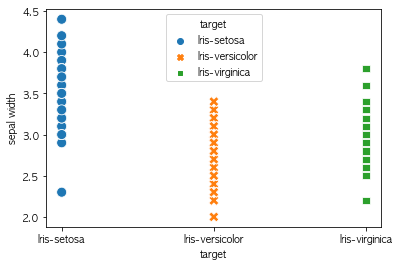

In [275]:
# Scatter plot by Groups
sns.scatterplot(x='target', 
                y='sepal width', 
                hue='target', # different colors by group
                style='target', # different shapes by group
                s=100, # marker size
                data=iris)
plt.show()

귀무가설(H0) <br>
세가지 종에 대해 sepal width의 평균 차이가 없다.<br>
대립가설(H1)<br>
적어도 하나의 종에 대한 sepal width의 평균 차이가 있다. <br>

In [276]:
### Normality test
print(stats.shapiro(setosa))
print(stats.shapiro(versicolor))
print(stats.shapiro(virginica))

ShapiroResult(statistic=0.968691885471344, pvalue=0.20465604960918427)
ShapiroResult(statistic=0.9741330742835999, pvalue=0.33798879384994507)
ShapiroResult(statistic=0.9673910140991211, pvalue=0.1809043288230896)


모든 집단이 다 정규성을 만족하므로, ANOVA를 진행한다.

In [277]:
### Equal variance test
# Levene test
stats.levene(setosa, versicolor, virginica)

LeveneResult(statistic=0.6475222363405327, pvalue=0.5248269975064537)

In [278]:
stats.f_oneway(setosa, versicolor, virginica)

F_onewayResult(statistic=47.36446140299382, pvalue=1.3279165184572242e-16)

[결과해석]
p-value가 유의수준보다 작으므로 '세가지 종의 꽃받침 폭의 평균은 차이가 있다'는 결론을 낼 수 있다.

In [279]:
### (참고) Kruskal-Wallis test
# 서열 척도 이상의 데이터에 사용
stats.kruskal(setosa, versicolor, virginica)

KruskalResult(statistic=62.49463010053111, pvalue=2.6882119006774528e-14)

In [280]:
### (참고) Mood's Median Test
# Pearson 카이 제곱 검정의 특수한 경우입니다.
# 두 개 이상의 표본을 추출한 모집단의 중위수가 동일하다는 귀무가설을 검정하는 비모수 검정입
stats.median_test(setosa, versicolor, virginica)

(50.22477971587844,
 1.2411596758086846e-11,
 3.0,
 array([[42,  8, 17],
        [ 8, 42, 33]]))

In [281]:
### if not equal variance
# Transformation / Scaling
# Welch's ANOVA

In [282]:
### (참고) Welch's ANOVA
pg.welch_anova(data=iris, dv='sepal width', between='target')

Source  ddof1      ddof2          F         p-unc       np2
0  target      2  97.369597  43.303381  3.519723e-14  0.391881

### (2) Two-way
- 하나의 종속변수 (연속형) 에 대한 두 개의 독립변수(범주형)의 영향을 알아보는 방법
- 교호작용 검증 필요. 교호작용이 있는 경우 주효과 검정은 의미가 없다
- ANOVA (F-test), Friedman test

In [283]:
mtcars = pd.read_csv('./ADP_book_ver01/data/mtcars.csv', index_col='Unnamed: 0')
mtcars.head()

mpg  cyl   disp   hp  drat     wt   qsec  vs  am  gear  \
Mazda RX4          21.0    6  160.0  110  3.90  2.620  16.46   0   1     4   
Mazda RX4 Wag      21.0    6  160.0  110  3.90  2.875  17.02   0   1     4   
Datsun 710         22.8    4  108.0   93  3.85  2.320  18.61   1   1     4   
Hornet 4 Drive     21.4    6  258.0  110  3.08  3.215  19.44   1   0     3   
Hornet Sportabout  18.7    8  360.0  175  3.15  3.440  17.02   0   0     3   

                   carb  
Mazda RX4             4  
Mazda RX4 Wag         4  
Datsun 710            1  
Hornet 4 Drive        1  
Hornet Sportabout     2

In [284]:
mtcars.describe()

mpg        cyl        disp          hp       drat         wt  \
count  32.000000  32.000000   32.000000   32.000000  32.000000  32.000000   
mean   20.090625   6.187500  230.721875  146.687500   3.596563   3.217250   
std     6.026948   1.785922  123.938694   68.562868   0.534679   0.978457   
min    10.400000   4.000000   71.100000   52.000000   2.760000   1.513000   
25%    15.425000   4.000000  120.825000   96.500000   3.080000   2.581250   
50%    19.200000   6.000000  196.300000  123.000000   3.695000   3.325000   
75%    22.800000   8.000000  326.000000  180.000000   3.920000   3.610000   
max    33.900000   8.000000  472.000000  335.000000   4.930000   5.424000   

            qsec         vs         am       gear     carb  
count  32.000000  32.000000  32.000000  32.000000  32.0000  
mean   17.848750   0.437500   0.406250   3.687500   2.8125  
std     1.786943   0.504016   0.498991   0.737804   1.6152  
min    14.500000   0.000000   0.000000   3.000000   1.0000  
25%    16.892500   0.000000   0.000000   3.000000   2.0000  
50%    17.710000   0.000000   0.000000   4.000000   2.0000  
75%    18.900000   1.000000   1.000000   4.000000   4.0000  
max    22.900000   1.000000   1.000000   5.000000   8.0000

In [285]:
am0 = mtcars[mtcars.am==0]
am1 = mtcars[mtcars.am==1]

cyl4 = mtcars[mtcars.cyl==4]
cyl6 = mtcars[mtcars.cyl==6]
cyl8 = mtcars[mtcars.cyl==8]

In [286]:
### Normality test
# mpg data is normal
print(stats.shapiro(am0['mpg']))
print(stats.shapiro(am1['mpg']))

print(stats.shapiro(cyl4['mpg']))
print(stats.shapiro(cyl6['mpg']))
print(stats.shapiro(cyl8['mpg']))

ShapiroResult(statistic=0.976774275302887, pvalue=0.8987362384796143)
ShapiroResult(statistic=0.9458035826683044, pvalue=0.536271333694458)
ShapiroResult(statistic=0.9124391078948975, pvalue=0.2605923116207123)
ShapiroResult(statistic=0.8990352153778076, pvalue=0.32517871260643005)
ShapiroResult(statistic=0.9317529201507568, pvalue=0.322853684425354)


In [287]:
### Equal variance test
# not equal variance
stats.levene(am0['mpg'], am1['mpg'])

LeveneResult(statistic=4.1876255537753995, pvalue=0.04957067404156203)

In [288]:
stats.levene(cyl4['mpg'], cyl6['mpg'], cyl8['mpg'])

LeveneResult(statistic=5.507064861977649, pvalue=0.009390247105110484)

In [289]:
mtcars['mpg_sqrt'] = np.sqrt(mtcars.mpg)

In [290]:
am0 = mtcars[mtcars.am==0]
am1 = mtcars[mtcars.am==1]

cyl4 = mtcars[mtcars.cyl==4]
cyl6 = mtcars[mtcars.cyl==6]
cyl8 = mtcars[mtcars.cyl==8]

In [291]:
stats.levene(am0['mpg_sqrt'], am1['mpg_sqrt'])

LeveneResult(statistic=1.8507055090956186, pvalue=0.1838361585926835)

In [292]:
stats.levene(cyl4['mpg_sqrt'], cyl6['mpg_sqrt'], cyl8['mpg_sqrt'])

LeveneResult(statistic=2.8688891317752816, pvalue=0.07296950644913348)

가설은 총 3가지로 정의할 수 있고, 상호작용 효과를 가장 먼저 검증한다.<br> <br>
귀무가설(H0) <br>
변속기 종류와 실린더 개수 간에는 상호작용 효과가 없다.<br>
대립가설(H1)<br>
변속기 종류와 실린더 개수 간에는 상호작용 효과가 있다.<br><br>
귀무가설(H0) <br>
실린더 개수에 따른 주행거리의 차이는 없다.<br>
대립가설(H1)<br>
실린더 개수에 따른 주행거리의 차이가 있다.<br><br>
귀무가설(H0) <br>
변속기 종류에 따른 주행거리의 차이는 없다.<br>
대립가설(H1)<br>
변속기 종류에 따른 주행거리의 차이는 있다. <br>


In [293]:
### Two-way ANOVA
formula = 'mpg_sqrt ~ C(cyl) + C(am) + C(cyl):C(am)'
model = smf.ols(formula, mtcars).fit()

aov_table = anova_lm(model, typ=2)
aov_table

sum_sq    df          F        PR(>F)
C(cyl)        5.634040   2.0  24.915357  9.050376e-07
C(am)         0.387832   1.0   3.430212  7.540130e-02
C(cyl):C(am)  0.209114   2.0   0.924763  4.092816e-01
Residual      2.939654  26.0        NaN           NaN

[결과해석]
교호작용의 p-value가 유의수준보다 크므로, 실린더 개수와 변속기 종류 간에는 교호작용이 존재하지 않는다. <br>
실린더 개수 변수에 대한 p-value는 유의수준보다 작으므로, 주효과 검정에서 귀무가설을 기각한다. 따라서 실린더 개수에 따른 주행거리 평균의 차이가 난다. <br>
변속기 종류 변수에 대한 p-value는 유의수준보다 크므로, 주효과 검정에서 귀무가설을 기각하지 않는다. 따라서 변속기 종류에 따른 주행거리 평균은 차이가 없다고 볼 수 있다.

In [294]:
from statsmodels.graphics.factorplots import interaction_plot

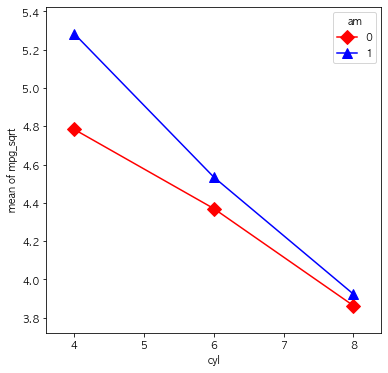

In [295]:
### interaction plot
# 교호작용 확인
# 독립변수 cyl,am와 종속변수 mpg을 Series로 변경 
cyl = mtcars["cyl"]
am = mtcars["am"]
mpg = mtcars["mpg_sqrt"]

fig, ax = plt.subplots(figsize=(6, 6))
fig = interaction_plot(cyl, am, mpg, colors=['red', 'blue'], markers=['D', '^'], ms=10, ax=ax) # 변수는 x1, x2 y 순

In [296]:
### (참고) Friedman test
# non-parametric ANOVA with blocked design
# 교호작용에 대한 검정은 Rank 특성 상 어려움
pg.friedman(data=mtcars, dv="mpg", within="am", subject="cyl")

Source    W  ddof1    Q     p-unc
Friedman     am  1.0      1  3.0  0.083265

In [297]:
pg.friedman(data=mtcars, dv="mpg", within="cyl", subject="am")

Source    W  ddof1    Q     p-unc
Friedman    cyl  1.0      2  4.0  0.135335

[결과해석]
실린더 개수 변수에 대한 p-value는 유의수준보다 작으므로 귀무가설을 기각한다. 따라서 실린더 개수에 따른 주행거리 차이는 없다고 볼 수 있다. <br>
변속기 종류 변수에 대한 p-value는 유의수준보다 크므로 귀무가설을 기각하지 않는다. 따라서 변속기 종류에 따른 주행거리는 차이가 난다.

### (3) ANCOVA
- 공변량의 영향을 고려한 분산분석
- 공변량은 연속형 변수
- ANOVA의 가정을 만족시켜야 함

In [298]:
### wt 변수를 공변량으로 설정하고, 실린더 개수 변수의 영향 측정
pg.ancova(data=mtcars, dv='mpg', covar='wt', between='cyl')

Source          SS  DF          F     p-unc       np2
0       cyl   95.263290   2   7.285567  0.002835  0.342277
1        wt  118.203950   1  18.080056  0.000213  0.392362
2  Residual  183.058648  28        NaN       NaN       NaN

### (4) MANOVA
- 다변량 분산분석
- 종속변수 여러 개를 한 번에 검정
- 가정: 종속변수들의 정규성, Equal covariance

In [299]:
from statsmodels.multivariate.manova import MANOVA

In [300]:
maov = MANOVA.from_formula('cyl + am ~ mpg + wt', data=mtcars)
print(maov.mv_test())

                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.5871 2.0000 28.0000  9.8475 0.0006
         Pillai's trace 0.4129 2.0000 28.0000  9.8475 0.0006
 Hotelling-Lawley trace 0.7034 2.0000 28.0000  9.8475 0.0006
    Roy's greatest root 0.7034 2.0000 28.0000  9.8475 0.0006
------------------------------------------------------------
                                                            
------------------------------------------------------------
          mpg           Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.6864 2.0000 28.0000  6.3955 0.0052
         Pillai's trace 0.3136 2.0000 28.0000  6.3955 0.0052
 Hotelling-Lawley trace 0.4568 2.0000 28.0

In [301]:
### post-hoc으로 선형판별분석 진행

### (5) Post-hoc test

In [302]:
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from statsmodels.sandbox.stats.multicomp import multipletests

In [303]:
### Fisher's LSD & Bonferroni adjustment
# T-test를 여러 번 수행하는 것
# 비교 대상이 많을수록 검정력이 떨어짐
# Tukey 보다 엄격함
mc = MultiComparison(data=iris["sepal width"], groups=iris["target"])

ret = mc.allpairtest(stats.ttest_ind, method='bonf', alpha=0.05)
ret[0] # 모든 집단의 평균이 다르다.

<class 'statsmodels.iolib.table.SimpleTable'>

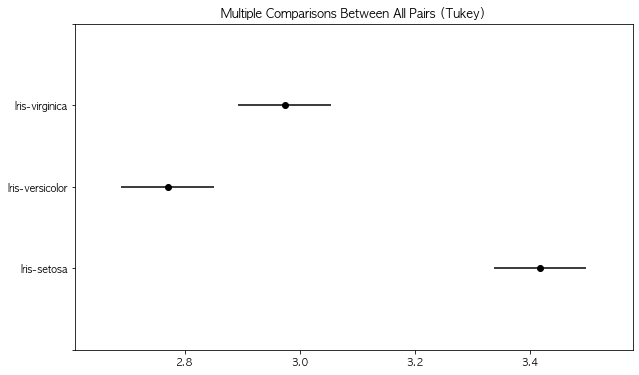

In [304]:
### Tukey's HSD
# Most powerful
# ANOVA 수행하지 않고도 결과를 볼 수 있음
# 집단별 sample 수가 동일해야 함
tukeyhsd = mc.tukeyhsd(alpha=0.05)
fig = tukeyhsd.plot_simultaneous()

In [305]:
tukeyhsd.summary() # 모든 집단의 평균이 다르다.

<class 'statsmodels.iolib.table.SimpleTable'>

In [306]:
### (참고) pingouin 패키지 사용
pg.pairwise_tukey(data=iris, dv='sepal width', between='target')

A                B  mean(A)  mean(B)   diff        se  \
0      Iris-setosa  Iris-versicolor    3.418    2.770  0.648  0.068084   
1      Iris-setosa   Iris-virginica    3.418    2.974  0.444  0.068084   
2  Iris-versicolor   Iris-virginica    2.770    2.974 -0.204  0.068084   

          T       p-tukey    hedges  
0  9.517713  2.153833e-14  1.842310  
1  6.521396  3.147409e-09  1.248226  
2 -2.996317  8.952134e-03 -0.636233

In [307]:
# ! pip install scikit-posthocs
import scikit_posthocs as sp

In [308]:
### Scheffe
# 가장 엄격한 Test
sp.posthoc_scheffe(iris, group_col='target', val_col='sepal width')

Iris-setosa  Iris-versicolor  Iris-virginica
Iris-setosa      1.000000e+00     4.730163e-16    7.739781e-09
Iris-versicolor  4.730163e-16     1.000000e+00    1.281402e-02
Iris-virginica   7.739781e-09     1.281402e-02    1.000000e+00

In [309]:
### Games Howell
# Equal variance가 아닌 경우 사용
# Welch's ANOVA의 사후검정 방법
pg.pairwise_gameshowell(data =iris, dv='sepal width', between='target')

A                B  mean(A)  mean(B)   diff        se  \
0      Iris-setosa  Iris-versicolor    3.418    2.770  0.648  0.069807   
1      Iris-setosa   Iris-virginica    3.418    2.974  0.444  0.070595   
2  Iris-versicolor   Iris-virginica    2.770    2.974 -0.204  0.063635   

          T         df          pval    hedges  
0  9.282773  94.525878  0.000000e+00  1.842310  
1  6.289385  95.395253  2.869266e-08  1.248226  
2 -3.205761  97.926827  5.129567e-03 -0.636233

In [310]:
### Duncan
# 일반적으로는 추천되지 않음
# 집단 개수가 같을 때 사용
# 비모수 검정에 사용 가능
sp.posthoc_dunn(iris, group_col='target', val_col='sepal width', p_adjust='holm')

Iris-setosa  Iris-versicolor  Iris-virginica
Iris-setosa      1.000000e+00     3.247311e-14    2.292201e-07
Iris-versicolor  3.247311e-14     1.000000e+00    1.521219e-02
Iris-virginica   2.292201e-07     1.521219e-02    1.000000e+00

In [311]:
### Mann-whitney
# Mann-whitney를 여러 번 수행하는 것
# 비모수적 검정
sp.posthoc_mannwhitney(iris, group_col='target', val_col='sepal width', alternative='two-sided') # 모든 집단의 평균이 다르다.

Iris-setosa  Iris-versicolor  Iris-virginica
Iris-setosa      1.000000e+00     2.983442e-13    1.180877e-08
Iris-versicolor  2.983442e-13     1.000000e+00    4.572142e-03
Iris-virginica   1.180877e-08     4.572142e-03    1.000000e+00

In [312]:
### Nemenyi test
# Tukey's HSD for non-parametric
sp.posthoc_conover(np.array([setosa, versicolor, virginica])) # 모든 집단의 평균이 다르다.

1             2             3
1  1.000000e+00  1.765695e-18  1.356705e-10
2  1.765695e-18  1.000000e+00  1.890443e-03
3  1.356705e-10  1.890443e-03  1.000000e+00

In [313]:
### Conover test
# 비모수적 검정
sp.posthoc_conover(np.array([setosa, versicolor, virginica])) # 모든 집단의 평균이 다르다.

1             2             3
1  1.000000e+00  1.765695e-18  1.356705e-10
2  1.765695e-18  1.000000e+00  1.890443e-03
3  1.356705e-10  1.890443e-03  1.000000e+00

In [314]:
### Two-way 사후 검정
# 1개 요인만 유의하므로, One-way와 동일한 사후 검정 가능
mc = MultiComparison(data=mtcars["mpg_sqrt"], groups=mtcars["cyl"])

ret = mc.allpairtest(stats.ttest_ind, method='bonf', alpha=0.05)
ret[0] # 모든 집단의 평균이 다르다.

<class 'statsmodels.iolib.table.SimpleTable'>

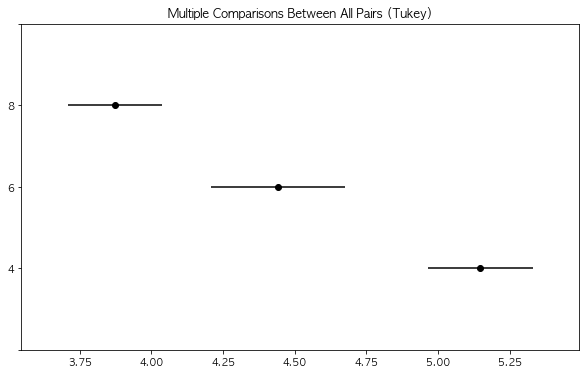

In [315]:
tukeyhsd = mc.tukeyhsd(alpha=0.05)
fig = tukeyhsd.plot_simultaneous()

In [316]:
tukeyhsd.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [317]:
# !pip install bioinfokit
from bioinfokit.analys import stat

In [318]:
### Tukey for two-way anova
result = stat()

result.tukey_hsd(df=mtcars, res_var='mpg_sqrt', xfac_var=['cyl', 'am'], anova_model=formula)
result.tukey_summary

group1  group2      Diff     Lower     Upper    q-value   p-value
0   (6, 1)  (6, 0)  0.164238 -0.624832  0.953308   0.904417  0.900000
1   (6, 1)  (4, 1)  0.748787  0.049352  1.448223   4.651803  0.030753
2   (6, 1)  (4, 0)  0.249253 -0.594298  1.092804   1.283926  0.900000
3   (6, 1)  (8, 1)  0.610588 -0.332531  1.553706   2.813145  0.376069
4   (6, 1)  (8, 0)  0.671048  0.004162  1.337934   4.372329  0.047942
5   (6, 0)  (4, 1)  0.913025  0.280362  1.545688   6.270767  0.001872
6   (6, 0)  (4, 0)  0.413491 -0.375579  1.202561   2.276991  0.587789
7   (6, 0)  (8, 1)  0.446350 -0.448371  1.341071   2.167695  0.629995
8   (6, 0)  (8, 0)  0.506810 -0.089671  1.103291   3.691981  0.130121
9   (4, 1)  (4, 0)  0.499534 -0.199902  1.198970   3.103330  0.274180
10  (4, 1)  (8, 1)  1.359375  0.542610  2.176140   7.231906  0.001000
11  (4, 1)  (8, 0)  1.419835  0.948276  1.891395  13.083145  0.001000
12  (4, 0)  (8, 1)  0.859841 -0.083278  1.802960   3.961524  0.088948
13  (4, 0)  (8, 0)  0.920301  0.253416  1.587187   5.996381  0.003063
14  (8, 1)  (8, 0)  0.060460 -0.728609  0.849530   0.332941  0.900000

In [319]:
### Two-way, Non-parametric 사후 검정
# Nemenyi
sp.posthoc_nemenyi_friedman(a=mtcars, y_col='mpg_sqrt', block_col='am', group_col='cyl', melted=True)

6         4        8
6  1.000000  0.036902  0.00331
4  0.036902  1.000000  0.00100
8  0.003310  0.001000  1.00000

In [320]:
# Conover
sp.posthoc_conover_friedman(a=mtcars, y_col='mpg_sqrt', block_col='am', group_col='cyl', melted=True)

6         4         8
6  1.000000  0.500349  0.823937
4  0.500349  1.000000  0.630247
8  0.823937  0.630247  1.000000

In [321]:
# Mann-Whitney
# block 지정 불가
sp.posthoc_mannwhitney(a=mtcars, val_col='mpg', group_col='cyl', alternative='two-sided')

4         6         8
4  1.000000  0.000666  0.000028
6  0.000666  1.000000  0.001013
8  0.000028  0.001013  1.000000

In [322]:
# Duncan
# block 지정 불가
sp.posthoc_dunn(a=mtcars, val_col='mpg_sqrt', group_col='cyl', p_adjust='holm')

4         6         8
4  1.000000  0.053687  0.000001
6  0.053687  1.000000  0.053687
8  0.000001  0.053687  1.000000

## Contingency table
- 범주형 변수들 간의 관계를 설명하기 위한 방법

### (1) Chi-Square tests
- 각 범주의 기대빈도는 5 이상이어야 함
- Goodness of fit: 각 범주에 따른 데이터의 빈도분포가 이론적으로 기대하는 분포는 따르는지 검정
- Independence: 두 개의 변수 A, B의 관계가 독립인지 검정
- Homogeneity: 모집단이 임의의 변수에 따라 R개로 범주화되었을 때, R 개의 부분 모집단에서 추출한 표본이 C개의 범주화된 집단의 분포가 동일한지 검정

#### Goodness of fit test

In [323]:
# 데이터 불러오기
df = pd.read_csv("./ADP_book_ver01/data/titanic.csv")
# titinic 데이터의 구조 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   adult_male   891 non-null    bool   
 10  embark_town  889 non-null    object 
dtypes: bool(1), float64(2), int64(4), object(4)
memory usage: 70.6+ KB


In [324]:
df_t = df[df['survived']==1]

table = df_t[['sex']].value_counts()
table

sex   
female    233
male      109
dtype: int64

귀무가설(H0) <br>
타이타닉호 생존자 중 남자와 여자의 비율은 동일하다. (각 50%)<br>
대립가설(H1)<br>
타이타닉호 생존자 중 남자와 여자의 비율은 동일하지 않다. (각 50%)<br>

In [325]:
from scipy.stats import chisquare

In [326]:
expected = int(table.sum() / 2) # 50%
chi = chisquare(table, f_exp=[expected, expected]) # f_exp에 기대 빈도 입력
print('<적합도 검정>\n', chi)

<적합도 검정>
 Power_divergenceResult(statistic=44.95906432748538, pvalue=2.0119672574477235e-11)


In [327]:
### 다른 input
O = np.array([233, 109])
pr = np.array([0.5, 0.5]) # sum() =1
n = O.sum()
E = n * pr

In [328]:
chi2, p = chisquare(O, E) # f_exp에 기대 빈도 입력
print('<적합도 검정> chi-sq 통계량:', chi2, 'p-value:', p)

<적합도 검정> chi-sq 통계량: 44.95906432748538 p-value: 2.0119672574477235e-11


[결과해석]
P-value가 유의수준 (0.05)보다 작으므로 귀무가설을 기각한다. 타이타닉호 생존자의 성별 비율은 동일하다고 볼 수 없다.

#### independence test / homogeneity test

In [329]:
table = pd.crosstab(df['class'], df['survived'])
table

survived    0    1
class             
First      80  136
Second     97   87
Third     372  119

- 독립성 검정 <br>
귀무가설(H0) <br>
class (좌석등급) 변수와 생존 여부는 독립이다.<br>
대립가설(H1)<br>
class (좌석등급) 변수와 생존 여부는 독립이 아니다.<br>

- 동질성 검정 <br>
귀무가설(H0) <br>
class 변수의 분포는 생존 여부와 관계없이 동일하다.<br>
대립가설(H1)<br>
class 변수의 분포는 생존 여부와 관계가 있다.<br>

- 하나의 모집단에서 추출된 변수의 상관성 측적은 독립성, 두 개 모집단에서 추출된 변수의 분포 비교는 동질성 검정

In [330]:
from scipy.stats import chi2_contingency

In [331]:
chi, p, df, expect = chi2_contingency(table) 
print('Statistic:', chi)
print('p-value:', p)
print('df:', df)
print('expect: \n', expect)

Statistic: 102.88898875696056
p-value: 4.549251711298793e-23
df: 2
expect: 
 [[133.09090909  82.90909091]
 [113.37373737  70.62626263]
 [302.53535354 188.46464646]]


[결과해석]
P-value가 유의수준 (0.05)보다 작으므로 귀무가설을 기각한다. class 변수와 생존여부 변수는 독립이 아니다. / class 변수의 분포는 생존 여부와 관계가 있다.

### (2) Fisher's exect test
- 사건 발생 가능성이 낮을 경우의 Chi-sq test
- 샘플이 적은 경우에 주로 사용
- Resampling 방법 사용하거나, 초기하분포를 이용한 계산

In [332]:
### scipy의 exact test는 2*2만 지원
stats.fisher_exact(clicks.iloc[:2, :2].values)

(1.7606490872210954, 0.2835969483988402)

In [333]:
### unconditional exact test 
stats.barnard_exact(clicks.iloc[:2, :2].values)

BarnardExactResult(statistic=1.286298502909844, pvalue=0.20245372969560074)

In [334]:
!pip install fisher-test-python
from fisher import fisher_test


[notice] A new release of pip available: 22.3 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [335]:
fisher_test(clicks.values)

0.48241413094304153

### (3) McNemar test
- paired 범주형 변수의 Chi-sq test

|| after:present| after:absent|
|---|---|---|
| before:present | a | b |
| before:abcent  | c | d |

- Marginal Probability가 같은지 검정 (b=c)
- Statictic: (b-c)**2/b + c ~ Chi-sq(1)
- H0: 전체에서 Before:present의 비율과, After:present의 비율이 같은가?" 또한 "Before:absent와 After:present의 비율이 같은가?"
- => 약 처방 후 환자의 상태는 변하지 않았다

In [336]:
from statsmodels.stats.contingency_tables import mcnemar

In [337]:
x = [[59, 6], [16, 80]]
x

[[59, 6], [16, 80]]

In [338]:
print(mcnemar(x, exact=True, correction=True))

pvalue      0.052478790283203125
statistic   6.0


### (4) Cochran's Q test
- 세 집단 이상 대응표본 변수의 차이 검정
- Two-way randomized block designs
- Response variable (y) can take only two possible outcomes (coded as 0 and 1)
- Test if k treatments have identical effects (identical binomial proportions) <br>
H0: the treatments are equally effective <br>
H1: there is a difference in effectiveness between treat

In [339]:
from statsmodels.stats.contingency_tables import cochrans_q

In [340]:
y_true = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

y_model_1 = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

y_model_2 = np.array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

y_model_3 = np.array([1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

In [341]:
cochran_table = pd.DataFrame([y_true, y_model_1, y_model_2, y_model_3]).T
cochran_table.columns = ['y_true', 'y_model_1', 'y_model_2', 'y_model_3']
cochran_table

y_true  y_model_1  y_model_2  y_model_3
0        0          1          1          1
1        0          1          1          1
2        0          1          1          1
3        0          1          1          0
4        0          1          1          0
..     ...        ...        ...        ...
95       0          0          0          0
96       0          0          0          0
97       0          0          0          0
98       0          0          0          1
99       0          0          0          1

[100 rows x 4 columns]

In [342]:
print(cochrans_q(cochran_table))

df          3
pvalue      3.542742882493579e-05
statistic   23.272727272727273


### (5) Kendall's W test
- Tests for Kendall's W

In [343]:
import kendall_w.kendall_w as kw

In [344]:
annotations = [[1, 1, 1, 2], [2, 2, 2, 3], [3, 3, 3, 1]]
m = len(annotations)
n = len(annotations[0])
W = kw.compute_w(annotations)

statistic = m*(n-1)*W
stats.chi2.ppf(statistic, df=n-1)

nan

In [345]:
df_1 = n-1-(2/m)

# Fetching p-value from F-test
p = stats.f.cdf((W*(m-1))/(1-W), dfn=df_1, dfd=df_1*(m-1))

2*p if p<=0.5 else 2*(1-p) # two-sided

0.6179561091215751

## Linear Regression
- Regression: 하나 혹은 그 이상의 변수들이 또 다른 변수에 미치는 영향 추론
- 모형의 적합성 확인
    - 모형이 통계적으로 유의미한가?
    - 회귀계수들이 유의미한가?
    - 모형의 설명력은 어떤가?
    - 모형이 데이터를 잘 적합하고 있는가? (잔차 확인)
    - 모형의 가정 만족
        - 독립/종속변수 간 선형성, 잔차와 독립변수의 독립성, 오차 등분산성, 관측치와 잔차의 비상관성, 잔차의 정규성

### (1) Simple Regression
- 독립변수의 개수가 하나인 경우

In [346]:
house = pd.read_csv('./ADP_book_ver01/data/kc_house_data.csv')
house = house[["price", "sqft_living"]]

## 독립변수와 종속변수의 선형 가정 
house.corr()

price  sqft_living
price        1.000000     0.702035
sqft_living  0.702035     1.000000

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

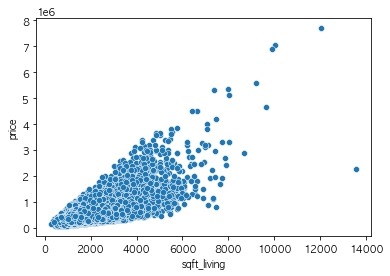

In [347]:
sns.scatterplot(x=house['sqft_living'], y=house['price']) # 회귀분석의 등분산 조건이 깨짐

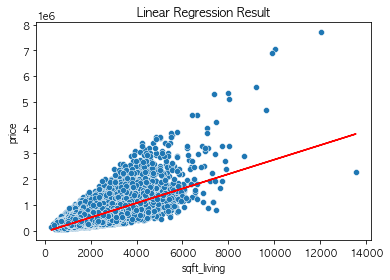

In [348]:
# 변수 할당 
y = house['price']
x = house[['sqft_living']]

# 단순선형회귀모형 적합
lr = smf.ols('price ~ sqft_living', data=house).fit()
y_pred = lr.predict(x)

# 시각화 
sns.scatterplot(x=house['sqft_living'], y=house['price'])
plt.plot(x, y_pred, color='red') ## 회귀직선 추가 
plt.xlabel('sqft_living', fontsize=10)
plt.ylabel('price',fontsize=10)
plt.title('Linear Regression Result')
plt.show()

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

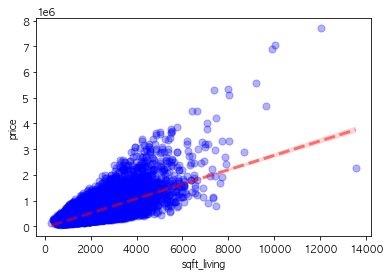

In [349]:
sns.regplot(x=house['sqft_living'], y=house['price'],
            scatter_kws={"fc":"b", "ec":"b", "s":50, "alpha":0.3},
            color="r",
            line_kws={"lw":3, "ls":"--","alpha":0.5}) # regplot으로 한줄 실행

[결과해석]
- (1) 데이터가 모형 가정을 만족시키는가? <br>
sqrt_living 변수의 값이 커질수록 잔차의 범위가 넓어지고 있어 등분산성 가정에 위배된다.

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

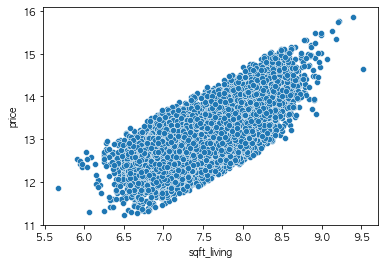

In [350]:
### 데이터를 변형해보자
sns.scatterplot(x=np.log(house['sqft_living']), y=np.log(house['price']))

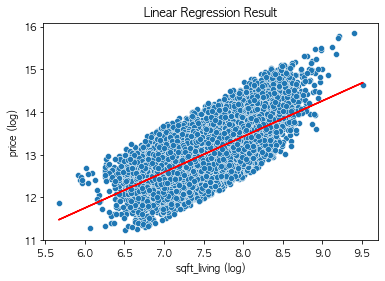

In [351]:
# 변수 할당 
house['log_price'] = np.log(house['price'])
house['log_sqft_living'] = np.log(house[['sqft_living']])

y = house['log_price']
x = house['log_sqft_living']

# 단순선형회귀모형 적합
lr = smf.ols('log_price ~ log_sqft_living', data=house).fit()
y_pred = lr.predict(x)

# 시각화 
sns.scatterplot(x=house['log_sqft_living'], y=house['log_price'])
plt.plot(x, y_pred, color='red') ## 회귀직선 추가 
plt.xlabel('sqft_living (log)', fontsize=10)
plt.ylabel('price (log)',fontsize=10)
plt.title('Linear Regression Result')
plt.show()

<AxesSubplot:xlabel='log_sqft_living', ylabel='log_price'>

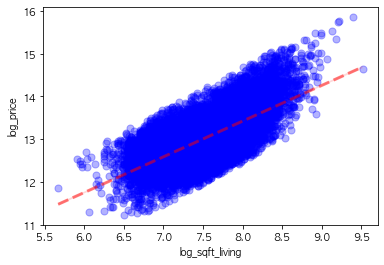

In [352]:
sns.regplot(x=house['log_sqft_living'], y=house['log_price'],
            scatter_kws={"fc":"b", "ec":"b", "s":50, "alpha":0.3},
            color="r", line_kws={"lw":3, "ls":"--","alpha":0.5}) # regplot으로 한줄 실행

In [353]:
lr.summary() # 성능 차이는 별로 안나는듯? 다른 변수가 필요해 보임.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                 1.808e+04
Date:                Thu, 31 Aug 2023   Prob (F-statistic):               0.00
Time:                        12:42:54   Log-Likelihood:                -10240.
No. Observations:               21613   AIC:                         2.048e+04
Df Residuals:                   21611   BIC:                         2.050e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.7299      0.047    143.001      0.000       6.638       6.822
log_sqft_living     0.8368      0.006    134.459      0.000       0.825       0.849
==============================================================================
Omnibus:                      123.344   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.759
Skew:                           0.142   Prob(JB):                     1.98e-25
Kurtosis:                       2.787   Cond. No.                         137.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

[결과해석] <br>
- (2) 회귀 모형이 통계적으로 유의한가?  <br>
F 검정의 p-value는 0.00으로, 유의수준 (0.05) 하에서 이 통계모델은 유의하다.
- (3) 모형은 데이터를 얼마나 설명할 수 있는가?  <br>
R-square 값은 0.456으로 데이터의 약 50%를 설명하고 있다.
- (4) 모형 내 회귀계수는 유의한가?  <br>
sqrt_living 변수의 T-test 결과는 p-value 0.000으로 유의한 변수이다.
- (5) 모형이 데이터를 잘 적합하고 있는가? <br>
단순 회귀분석으로는 충분히 데이터를 설명할 수 없어 보인다. 변수 추가를 고려해봐야 한다.

In [354]:
### 맥주 데이터
beer = pd.read_csv("./stats_for_python/5-1-1-beer.csv")
beer.head()

beer  temperature
0  45.3         20.5
1  59.3         25.0
2  40.4         10.0
3  38.0         26.9
4  37.0         15.8

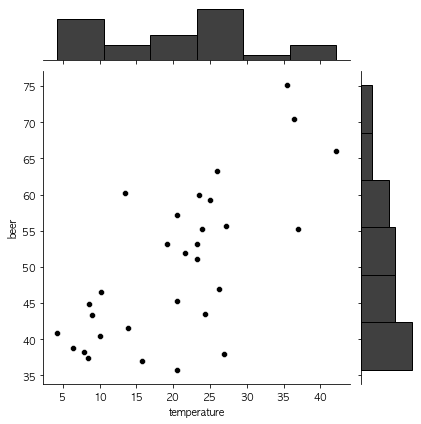

In [355]:
# 변수 확인
sns.jointplot(x="temperature", y="beer", data=beer, color='black')
plt.show()

In [356]:
# Model 생성
lm_model = smf.ols(formula = "beer ~ temperature", data = beer).fit()
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   beer   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     28.45
Date:                Thu, 31 Aug 2023   Prob (F-statistic):           1.11e-05
Time:                        12:42:54   Log-Likelihood:                -102.45
No. Observations:                  30   AIC:                             208.9
Df Residuals:                      28   BIC:                             211.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      34.6102      3.235     10.699      0.000      27.984      41.237
temperature     0.7654      0.144      5.334      0.000       0.471       1.059
==============================================================================
Omnibus:                        0.587   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.746   Jarque-Bera (JB):                0.290
Skew:                          -0.240   Prob(JB):                        0.865
Kurtosis:                       2.951   Cond. No.                         52.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [357]:
# ANOVA on regression
sm.stats.anova_lm(lm_model, typ=2)

sum_sq    df          F    PR(>F)
temperature  1651.532489   1.0  28.446984  0.000011
Residual     1625.582178  28.0        NaN       NaN

In [358]:
### 모델 선택: 단순 회귀에서는 Null 모델과 비교
# NULL 모델
null_model = smf.ols("beer ~ 1", data = beer).fit()
null_model.aic

227.94194972563105

In [359]:
# 모델의 aic
lm_model.aic

208.90902935575437

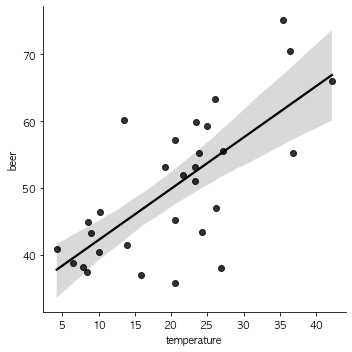

In [360]:
# 회귀직선 확인
sns.lmplot(x="temperature", y="beer", data=beer, scatter_kws={"color": "black"}, line_kws={"color": "black"})
plt.show()

In [361]:
### Prediction
lm_model.predict()

array([50.3014808 , 53.74590495, 42.26449113, 55.20021737, 46.70397114,
       37.82501112, 44.94348769, 54.51133254, 52.44467805, 41.11634975,
       54.66441806, 49.22988218, 53.21010564, 52.44467805, 41.03980699,
       52.59776357, 45.24965873, 61.78289462, 55.42984564, 50.3014808 ,
       42.41757665, 50.3014808 , 51.14345115, 40.6570932 , 66.91125946,
       52.9039346 , 62.85449324, 41.42252079, 62.47177945, 39.50895182])

In [362]:
# 특정 기온에 따른 매상 예측
lm_model.predict(pd.DataFrame({"temperature": [0]})) # Intercept와 일치

0    34.610215
dtype: float64

In [363]:
lm_model.params

Intercept      34.610215
temperature     0.765428
dtype: float64

In [364]:
lm_model.predict(pd.DataFrame({"temperature":[20]}))

0    49.918767
dtype: float64

In [365]:
# Residuals
resid = lm_model.resid
resid.head(3)

0   -5.001481
1    5.554095
2   -1.864491
dtype: float64

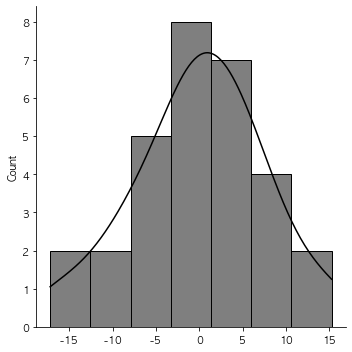

In [366]:
sns.displot(resid, color='black', kde=True)

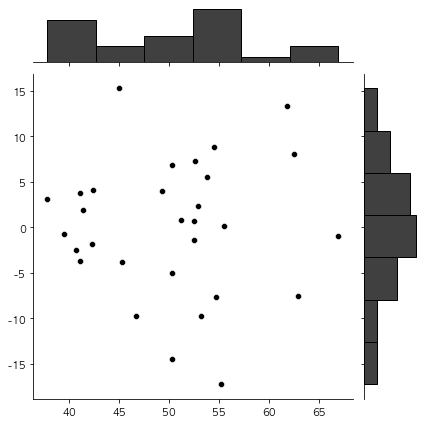

In [367]:
sns.jointplot(x=lm_model.fittedvalues, y=resid, joint_kws={"color": "black"}, marginal_kws={"color": "black"})

In [368]:
# R-square
lm_model.rsquared

0.5039593230611858

In [369]:
# Adj R-square
lm_model.rsquared_adj

0.48624358459908534

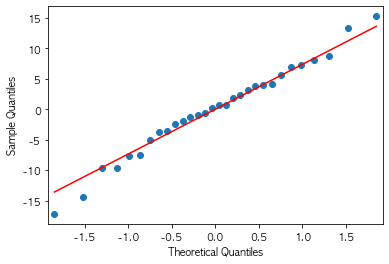

In [370]:
# Q-Q plot
fig = sm.qqplot(resid, line="s")

In [371]:
### Chick diet dataset
chick = pd.read_csv('./r_csv/datasets/ChickWeight.csv')
chick = chick.drop('Unnamed: 0', axis=1)
chick.head()

weight  Time  Chick  Diet
0      42     0      1     1
1      51     2      1     1
2      59     4      1     1
3      64     6      1     1
4      76     8      1     1

In [372]:
diet_1 = chick[chick.Diet==1]

In [373]:
chick_1 = diet_1[diet_1.Chick==1]
chick_1

weight  Time  Chick  Diet
0       42     0      1     1
1       51     2      1     1
2       59     4      1     1
3       64     6      1     1
4       76     8      1     1
5       93    10      1     1
6      106    12      1     1
7      125    14      1     1
8      149    16      1     1
9      171    18      1     1
10     199    20      1     1
11     205    21      1     1

In [374]:
x = chick_1['Time']
y = chick_1['weight']

<AxesSubplot:xlabel='Time', ylabel='weight'>

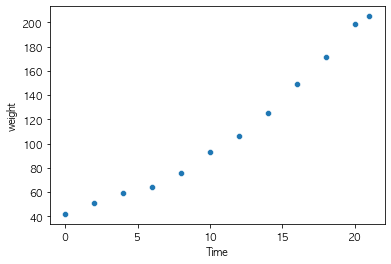

In [375]:
sns.scatterplot(x=x, y=y) # 사실은 시계열분석을 해야되는거 아닌가..

In [376]:
lr = smf.ols('weight ~ Time', data=chick_1).fit()
y_pred = lr.predict(x)

In [377]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 weight   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     232.7
Date:                Thu, 31 Aug 2023   Prob (F-statistic):           2.97e-08
Time:                        12:42:56   Log-Likelihood:                -46.039
No. Observations:                  12   AIC:                             96.08
Df Residuals:                      10   BIC:                             97.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.4654      6.728      3.636      0.005       9.475      39.456
Time           7.9879      0.524     15.255      0.000       6.821       9.155
==============================================================================
Omnibus:                        3.840   Durbin-Watson:                   0.342
Prob(Omnibus):                  0.147   Jarque-Bera (JB):                1.217
Skew:                           0.211   Prob(JB):                        0.544
Kurtosis:                       1.498   Cond. No.                         24.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

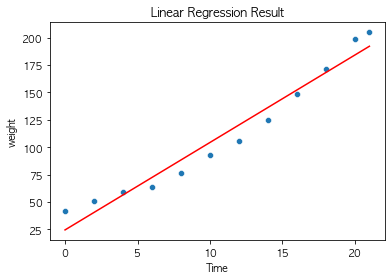

In [378]:
sns.scatterplot(x=x, y=y)
plt.plot(x, y_pred, color='red') ## 회귀직선 추가 
plt.xlabel('Time', fontsize=10)
plt.ylabel('weight',fontsize=10)
plt.title('Linear Regression Result')
plt.show()

<AxesSubplot:xlabel='Time', ylabel='weight'>

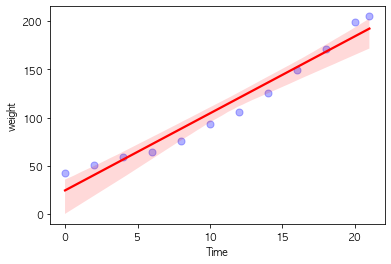

In [379]:
sns.regplot(x=x, y=y, scatter_kws={"fc":"b", "ec":"b", "s":50, "alpha":0.3}, color="r") # regplot으로 한줄 실행

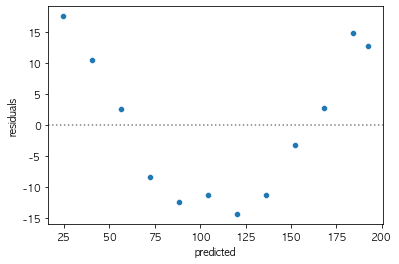

In [380]:
### Manual residual plot
# create a DataFrame of predicted values and residuals
plot_df = pd.DataFrame()
plot_df["predicted"] = y_pred
plot_df["residuals"] = lr.resid

sns.scatterplot(data=plot_df, x="predicted", y="residuals")
plt.axhline(y=0, color='gray', linestyle='dotted')

eval_env: 1


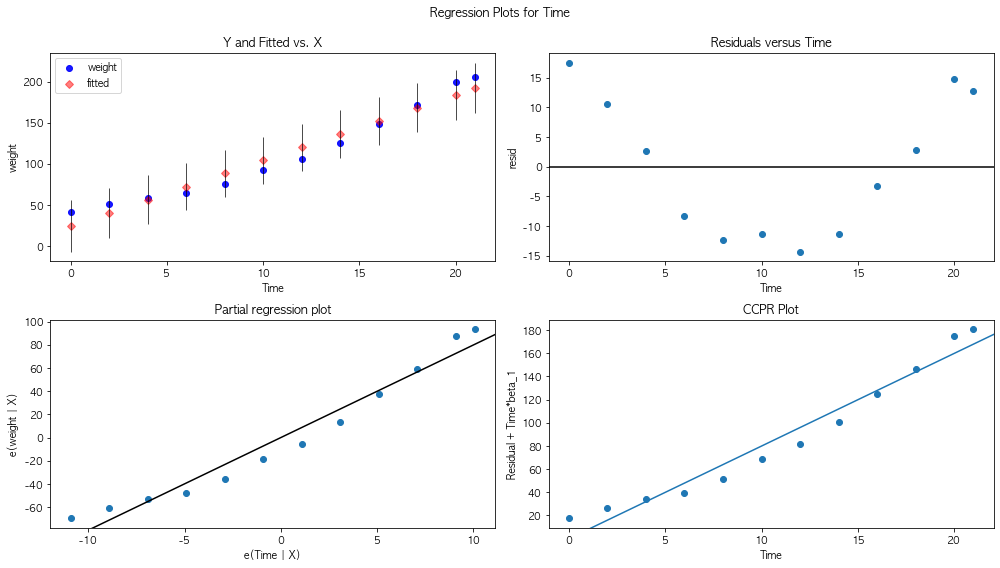

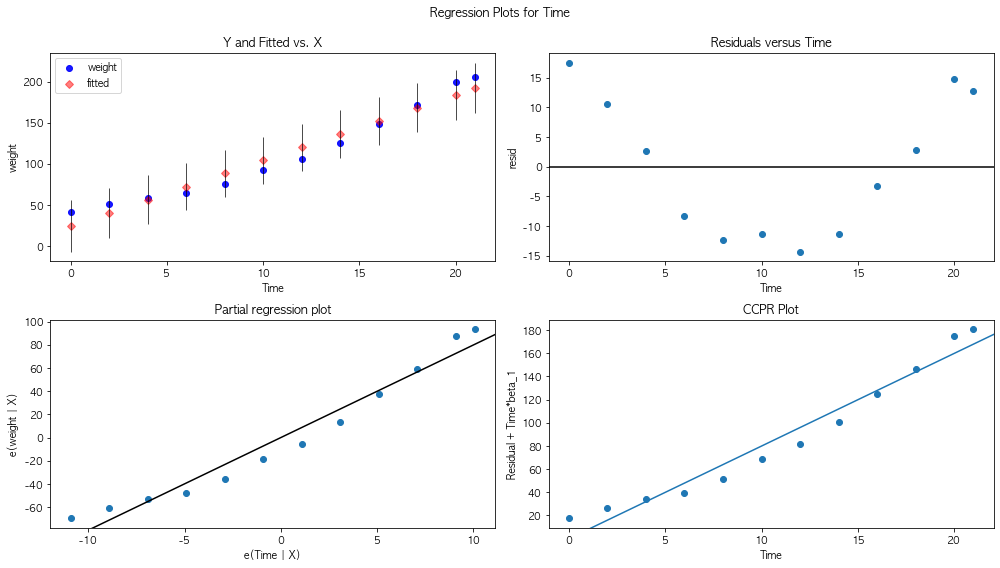

In [381]:
### Residual plot
fig = plt.figure(figsize=(14, 8))
sm.graphics.plot_regress_exog(lr, 'Time', fig=fig)

### (2) Multiple Regression
- 독립변수 개수가 여러 개인 경우
- 독립변수 개수가 늘면 R-square 값은 항상 증가하므로, Adjusted R-square (변수 개수 고려)로 설명력 측정
- 다중공선성 확인
    - VIF 10 이상
    - 독립변수 간 상관계수 0.9 이상
    - 독립변수 간 회귀분석의 허용오차(1-Rsquare) 0.1 이하
- 오차항의 독립성
    - 더빈 왓슨 통계랑: 0~4의 값을 가지며, 0이면 양의 상관, 4면 음의 상관. 2=상관 없음
- 독립변수 선택: 최적의 회귀식 도출
    - 모든 가능한 조합
    - 단계적 변수선택: Forward, Backward, Stepwise
    - AIC, BIC, F-statistic 등이 기준이 됨

In [382]:
### Sales data
sales = pd.read_csv("./stats_for_python/5-3-1-lm-model.csv")
sales.head(3)

humidity  price  sales  temperature weather
0      29.5    290  229.7         17.8   rainy
1      38.1    290  206.1         26.1   rainy
2      31.5    290  202.5         22.0   rainy

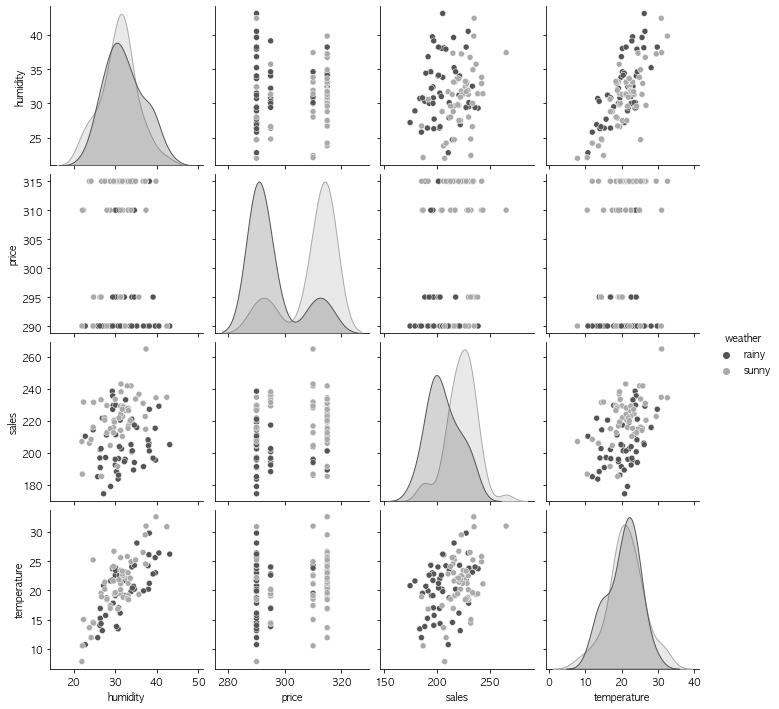

In [383]:
sns.pairplot(data=sales, hue="weather", palette="gray")
plt.show()

In [384]:
# 날씨 별 평균
sales.groupby("weather").mean()

humidity  price    sales  temperature
weather                                       
rainy      32.126  295.5  205.924       20.422
sunny      30.852  309.5  222.718       21.102

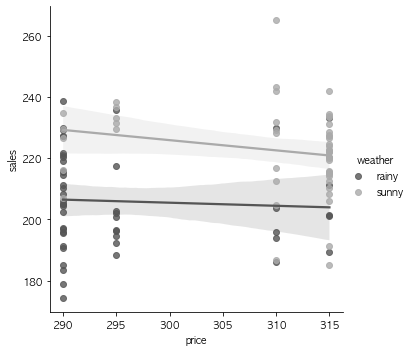

In [385]:
# 날씨 별 매상과 상품 가격
sns.lmplot(x="price", y="sales", data=sales, hue="weather", palette='gray')
plt.show()

In [386]:
from statsmodels.formula.api import ols

In [387]:
# Multiple X
lm_sales = smf.ols("sales ~ weather + humidity + temperature + price", data=sales).fit()
lm_sales.params

Intercept           278.627722
weather[T.sunny]     19.989119
humidity             -0.254055
temperature           1.603115
price                -0.329207
dtype: float64

In [388]:
# Regression 계수 검정 (T-test) -> Type 2 ANOVA
lm_sales.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [389]:
# Null Model에서 시작하여 변수 선택
mod_null = smf.ols("sales ~ 1", sales).fit()
resid_sq_null = np.sum(mod_null.resid ** 2)
resid_sq_null

28968.525899999993

In [390]:
# 날씨가 들어간 모델
mod_1 = smf.ols("sales ~ weather", sales).fit()
sm.stats.anova_lm(mod_1).round(3)

df     sum_sq   mean_sq       F  PR(>F)
weather    1.0   7050.961  7050.961  31.527     0.0
Residual  98.0  21917.565   223.649     NaN     NaN

In [391]:
# 날씨 + 습도 모델
mod_2 = smf.ols("sales ~ weather + humidity", sales).fit()
sm.stats.anova_lm(mod_2).round(3)

df     sum_sq   mean_sq       F  PR(>F)
weather    1.0   7050.961  7050.961  33.963   0.000
humidity   1.0   1779.601  1779.601   8.572   0.004
Residual  97.0  20137.964   207.608     NaN     NaN

In [392]:
# 날씨 + 기온 모델
mod_2_2 = smf.ols("sales ~ weather + temperature", sales).fit()
sm.stats.anova_lm(mod_2_2).round(3)

df     sum_sq   mean_sq       F  PR(>F)
weather       1.0   7050.961  7050.961  37.781     0.0
temperature   1.0   3814.779  3814.779  20.441     0.0
Residual     97.0  18102.786   186.627     NaN     NaN

In [393]:
# 날씨 + 기온 + 습도 모델
# 습도의 효과가 높지 않음 (유의하지 않음)
mod_3_2 = smf.ols("sales ~ weather + temperature + humidity", sales).fit()
sm.stats.anova_lm(mod_3_2).round(3)

df     sum_sq   mean_sq       F  PR(>F)
weather       1.0   7050.961  7050.961  37.478   0.000
temperature   1.0   3814.779  3814.779  20.277   0.000
humidity      1.0     41.667    41.667   0.221   0.639
Residual     96.0  18061.119   188.137     NaN     NaN

In [394]:
# 전체 변수 모델
mod_full = smf.ols("sales ~ weather + humidity + temperature + price", sales).fit()
sm.stats.anova_lm(mod_full, typ=2).round(3)

sum_sq    df       F  PR(>F)
weather       5845.878   1.0  32.208   0.000
humidity        56.425   1.0   0.311   0.578
temperature   2378.017   1.0  13.102   0.000
price          818.402   1.0   4.509   0.036
Residual     17242.717  95.0     NaN     NaN

In [395]:
# 습도 제외 모델
mod_non_humi = smf.ols("sales ~ weather + temperature + price", sales).fit()
sm.stats.anova_lm(mod_non_humi, typ=2).round(3)

sum_sq    df       F  PR(>F)
weather       6354.966   1.0  35.266   0.000
temperature   4254.736   1.0  23.611   0.000
price          803.644   1.0   4.460   0.037
Residual     17299.142  96.0     NaN     NaN

In [396]:
# 2개 모델 비교
mod_full.compare_f_test(mod_non_humi)

(0.31087803756963617, 0.578453342712073, 1.0)

In [397]:
# AIC 비교
print("Full:", mod_full.aic.round(3))
print("습도 제외:", mod_non_humi.aic.round(3))

Full: 808.785
습도 제외: 807.112


In [398]:
from scipy.stats import linregress

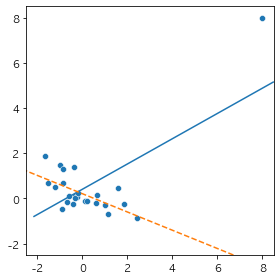

In [399]:
### Outlier 영향 - sample
np.random.seed(5)
x = np.random.normal(size=25)
y = -x / 5 + np.random.normal(size=25)
x[0] = 8
y[0] = 8

def abline(slope, intercept):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(plt.xlim())
    return (x_vals, intercept + slope * x_vals)

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x=x, y=y)
slope, intercept, _, _, _ = linregress(x, y)
plt.plot(*abline(slope, intercept))
slope, intercept, _, _, _ = linregress(x[1:], y[1:])
plt.plot(*abline(slope, intercept), '--')
plt.xlim(-2.5, 8.5)
plt.ylim(-2.5, 8.5)

plt.tight_layout()
plt.show()

In [400]:
house = pd.read_csv('./Practical_Statictics/data/house_sales.csv', sep='\t')
house_98105 = house.loc[house['ZipCode'] == 98105, ]

In [401]:
### Regression 진단
house_outlier = smf.ols('AdjSalePrice ~ SqFtTotLiving + SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_98105)
result_98105 = house_outlier.fit()
result_98105.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     238.7
Date:                Thu, 31 Aug 2023   Prob (F-statistic):          1.69e-103
Time:                        12:43:04   Log-Likelihood:                -4226.0
No. Observations:                 313   AIC:                             8464.
Df Residuals:                     307   BIC:                             8486.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -7.725e+05   9.83e+04     -7.861      0.000   -9.66e+05   -5.79e+05
SqFtTotLiving   209.6023     24.408      8.587      0.000     161.574     257.631
SqFtLot          38.9333      5.330      7.305      0.000      28.445      49.421
Bathrooms      2282.2641      2e+04      0.114      0.909    -3.7e+04    4.16e+04
Bedrooms      -2.632e+04   1.29e+04     -2.043      0.042   -5.17e+04    -973.867
BldgGrade        1.3e+05   1.52e+04      8.533      0.000       1e+05     1.6e+05
==============================================================================
Omnibus:                       82.127   Durbin-Watson:                   1.508
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              586.561
Skew:                           0.859   Prob(JB):                    4.26e-128
Kurtosis:                       9.483   Cond. No.                     5.63e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [402]:
from statsmodels.stats.outliers_influence import OLSInfluence

In [403]:
### 잔차 분석
influence = OLSInfluence(result_98105)
sresiduals = influence.resid_studentized_internal

print(sresiduals.idxmin(), sresiduals.min())

24333 -4.326731804078571


In [404]:
result_98105.resid.loc[sresiduals.idxmin()]

-757753.6192115842

In [405]:
### Outlier 확인
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

outlier = house_98105.loc[sresiduals.idxmin(), :]
print('AdjSalePrice', outlier[outcome], '\n')
print(outlier[predictors])

AdjSalePrice 119748.0 

SqFtTotLiving    2900
SqFtLot          7276
Bathrooms         3.0
Bedrooms            6
BldgGrade           7
Name: 24333, dtype: object


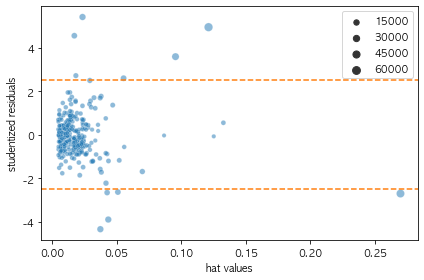

In [406]:
### Cook's distance
influence = OLSInfluence(result_98105)
sns.scatterplot(x=influence.hat_matrix_diag, y=influence.resid_studentized_internal, 
           size=100000 * np.sqrt(influence.cooks_distance[0]), alpha=0.5)

plt.axhline(-2.5, linestyle='--', color='C1')
plt.axhline(2.5, linestyle='--', color='C1')
plt.xlabel('hat values')
plt.ylabel('studentized residuals')

plt.tight_layout()
plt.show()

In [407]:
### 쿡 거리가 0.08 이상인 것 제외
mask = [dist < .08 for dist in influence.cooks_distance[0]]
house_infl = house_98105.loc[mask]

ols_infl = smf.ols('AdjSalePrice ~ SqFtTotLiving + SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_infl)
result_infl = ols_infl.fit()

pd.DataFrame({
    'Original': result_98105.params,
    'Influential removed': result_infl.params,
})

Original  Influential removed
Intercept     -772549.862447       -647137.096716
SqFtTotLiving     209.602346           230.052569
SqFtLot            38.933315            33.141600
Bathrooms        2282.264145        -16131.879785
Bedrooms       -26320.268796        -22887.865318
BldgGrade      130000.099737        114870.559737

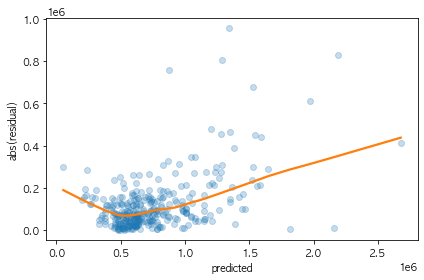

In [408]:
### 이분산 오차 확인
sns.regplot(x=result_98105.fittedvalues, y=np.abs(result_98105.resid), 
            scatter_kws={'alpha': 0.25},
            line_kws={'color': 'C1'},
            lowess=True)
plt.xlabel('predicted')
plt.ylabel('abs(residual)')
plt.tight_layout()
plt.show()

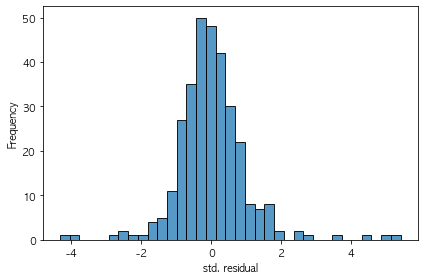

In [409]:
sns.histplot(x=pd.Series(influence.resid_studentized_internal))
plt.xlabel('std. residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

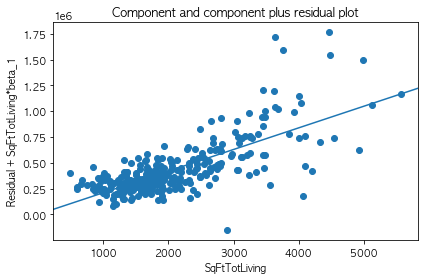

In [410]:
### Partial Residual plots
# partial residual = residual + biXi
# 예측값과 잔차 결합
# 비선형 회귀 고려
sm.graphics.plot_ccpr(result_98105, 'SqFtTotLiving')

plt.tight_layout()
plt.show()

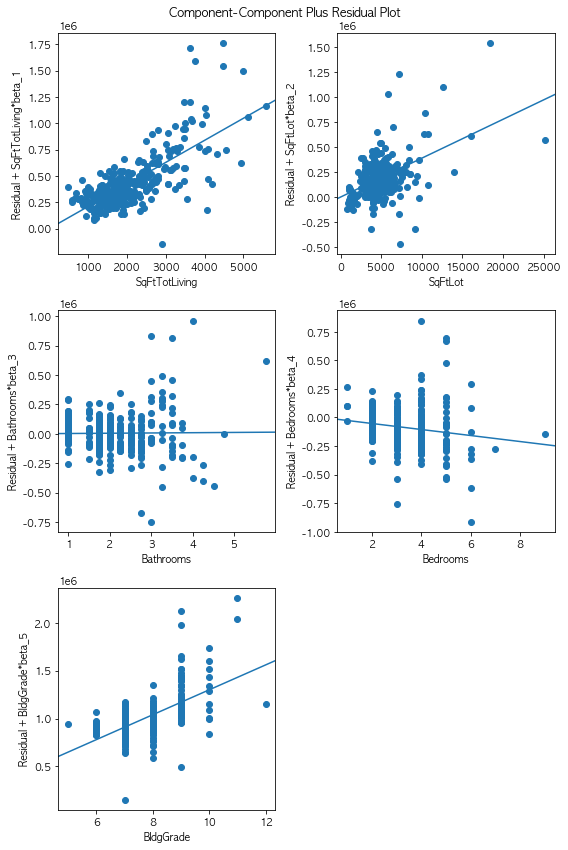

In [411]:
fig = plt.figure(figsize=(8, 12))
fig = sm.graphics.plot_ccpr_grid(result_98105, fig=fig)

In [412]:
### Dummy data
df = pd.DataFrame({'X1': [7, 1, 11, 11, 7, 11, 3, 1, 2, 21, 1, 11, 10],
                   'X2': [26, 29, 56, 31, 52, 55, 71, 31, 54, 47, 40, 66, 68],
                   'X3': [6, 15, 8, 8, 6, 9, 17, 22, 18, 4, 23, 9, 8],
                   'X4': [60, 52, 20, 47, 33, 22, 6, 44, 22, 26, 34, 12, 12],
                   'Y': [78.5, 74.3, 104.3, 87.6, 95.9, 109.2, 102.7, 72.5, 93.1, 115.9, 83.8, 113.3, 109.4]})
df

X1  X2  X3  X4      Y
0    7  26   6  60   78.5
1    1  29  15  52   74.3
2   11  56   8  20  104.3
3   11  31   8  47   87.6
4    7  52   6  33   95.9
5   11  55   9  22  109.2
6    3  71  17   6  102.7
7    1  31  22  44   72.5
8    2  54  18  22   93.1
9   21  47   4  26  115.9
10   1  40  23  34   83.8
11  11  66   9  12  113.3
12  10  68   8  12  109.4

In [413]:
### 변수 간 상관성 확인
df.corr()

X1        X2        X3        X4         Y
X1  1.000000  0.228579 -0.824134 -0.245445  0.730717
X2  0.228579  1.000000 -0.139242 -0.972955  0.816253
X3 -0.824134 -0.139242  1.000000  0.029537 -0.534671
X4 -0.245445 -0.972955  0.029537  1.000000 -0.821305
Y   0.730717  0.816253 -0.534671 -0.821305  1.000000

In [414]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [415]:
### VIF 계산
# 독립변수와 종속변수를 데이터프레임으로 나누어 저장하는 함수
# Intercept가 포함됨
y, x = dmatrices("Y ~ X1 + X2 + X3 + X4", data=df, return_type="dataframe")

# 독립변수끼리의 VIF값을 계산하여 데이터프레임으로 만드는 과정 
vif_list = []
for i in range(1, len(x.columns)): 
    vif_list.append([variance_inflation_factor(x.values, i), x.columns[i]])
pd.DataFrame(vif_list, columns=['vif', 'variable'])

vif variable
0   38.496211       X1
1  254.423166       X2
2   46.868386       X3
3  282.512865       X4

In [416]:
### VIF 10 이상인 변수를 지우는 함수
def apply_vif(data, target_col):
    vif_df = pd.DataFrame()
    x_columns = list(data.columns.difference([target_col]))
    for j in range(len(x_columns)):
        x_str = ''
        for i, column in enumerate(x_columns):
            if i == len(x_columns) -1:
                x_str += column
            else:
                x_str += column + ' + '
    
        y, x = dmatrices(f"{target_col} ~ {x_str}", data=data, return_type="dataframe")
    
        vif_list = []
        for i in range(1, len(x.columns)): 
            vif_list.append([variance_inflation_factor(x.values, i), x.columns[i]])
        vif_df = pd.DataFrame(vif_list, columns=['vif', 'variable'])
        
        if vif_df['vif'].max() > 10:
            del_column = vif_df['variable'][vif_df['vif']==vif_df['vif'].max()].values[0]
            x_columns.remove(del_column)
        else:
            break
    
    return y, x, vif_df

In [417]:
y, x, vif_df = apply_vif(df, 'Y')
vif_df

vif variable
0  3.251068       X1
1  1.063575       X2
2  3.142125       X3

In [418]:
### Model fit
model = smf.ols(formula="Y ~ X1 + X2 + X3", data=df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     166.3
Date:                Thu, 31 Aug 2023   Prob (F-statistic):           3.37e-08
Time:                        12:43:07   Log-Likelihood:                -26.952
No. Observations:                  13   AIC:                             61.90
Df Residuals:                       9   BIC:                             64.16
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     48.1936      3.913     12.315      0.000      39.341      57.046
X1             1.6959      0.205      8.290      0.000       1.233       2.159
X2             0.6569      0.044     14.851      0.000       0.557       0.757
X3             0.2500      0.185      1.354      0.209      -0.168       0.668
==============================================================================
Omnibus:                        0.164   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.921   Jarque-Bera (JB):                0.261
Skew:                           0.208   Prob(JB):                        0.878
Kurtosis:                       2.445   Cond. No.                         319.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [419]:
from itertools import permutations

In [420]:
### 교호작용 항 추가 고려
comb = list(permutations(df.columns.difference(['Y']), 2))
variables= ' + '.join(list(df.columns.difference(['Y']))) + ' + ' + ' + '.join([':'.join(list(y)) for y in comb])
variables

'X1 + X2 + X3 + X4 + X1:X2 + X1:X3 + X1:X4 + X2:X1 + X2:X3 + X2:X4 + X3:X1 + X3:X2 + X3:X4 + X4:X1 + X4:X2 + X4:X3'

In [421]:
model = smf.ols(formula=f"Y ~ {variables}", data=df) ### 대부분 변수가 유의하지 않음. 변수 선택 필요
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     313.6
Date:                Thu, 31 Aug 2023   Prob (F-statistic):            0.00318
Time:                        12:43:07   Log-Likelihood:                -5.3403
No. Observations:                  13   AIC:                             32.68
Df Residuals:                       2   BIC:                             38.90
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -46.5671    102.668     -0.454      0.695    -488.314     395.180
X1             4.2075      7.304      0.576      0.623     -27.221      35.636
X2             0.9180      1.383      0.664      0.575      -5.032       6.868
X3            -3.0093      4.963     -0.606      0.606     -24.364      18.345
X4             0.9836      1.238      0.794      0.510      -4.345       6.312
X1:X2         -0.0007      0.104     -0.006      0.996      -0.447       0.446
X1:X3          0.1041      0.062      1.669      0.237      -0.164       0.373
X1:X4         -0.0521      0.095     -0.550      0.638      -0.460       0.356
X2:X3          0.0850      0.071      1.205      0.351      -0.218       0.388
X2:X4          0.0151      0.003      5.667      0.030       0.004       0.027
X3:X4          0.0322      0.062      0.523      0.653      -0.233       0.298
==============================================================================
Omnibus:                        0.479   Durbin-Watson:                   2.402
Prob(Omnibus):                  0.787   Jarque-Bera (JB):                0.552
Skew:                          -0.297   Prob(JB):                        0.759
Kurtosis:                       2.184   Cond. No.                     5.86e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.86e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [422]:
### 모델 선택 함수
import time
import itertools
import statsmodels.api as sm

def process_subset(x, y, feature_set):
    model = sm.OLS(y, x[list(feature_set)]) # Modeling
    regr = model.fit() # 모델 학습
    criteria = regr.aic # 모델의 AIC 이 부분을 변경하면 기준을 바꿀 수 있음
    # regr.bic
    # regr.rsquared_adj
    
    return {"model": regr, "criteria": criteria}
        
# 전진선택법
def forward(x, y, predictors):
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    remaining_predictors = [p for p in x.columns.difference(['Intercept']) if p not in predictors]
    results = []
    for p in remaining_predictors:
        results.append(process_subset(x=x, y=y, feature_set=predictors + [p] + ['Intercept']))
        
    # 데이터프레임으로 변환
    models = pd.DataFrame(results)
    # AIC가 가장 낮은 것을 선택. 기준에 따라 변경 필요
    best_model = models.loc[models['criteria'].argmin()] # index
    print("Processed ", models.shape[0], "models on", len(predictors) + 1, "predictors in")
    print('Selected predictors:', best_model['model'].model.exog_names,' Criteria: ', best_model[0])
    
    return best_model

# 후진소거법
def backward(x, y, predictors):
    tic = time.time()
    results = []
    
    # 데이터 변수들이 미리정의된 predictors 조합 확인
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(process_subset(x=x, y=y, feature_set=list(combo) + ['Intercept']))
    models = pd.DataFrame(results)
    
    # 가장 낮은 AIC를 가진 모델을 선택. 기준에 따라 변경 필요
    best_model = models.loc[models['criteria'].argmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors) -1, "predictors in", (toc - tic))
    print('Selected predictors:',best_model['model'].model.exog_names, 'Criteria: ',best_model[0] )

    return best_model

# 단계적 선택법
def stepwise_model(x, y):
    stepmodels = pd.DataFrame(columns=["criteria", "model"])
    tic = time.time()
    predictors = []
    s_model_before = process_subset(x, y, predictors + ['Intercept'])['criteria']
    print("Criteria, Before selection:", s_model_before)

    for i in range(1, len(x.columns.difference(['Intercept'])) +1):
        forward_result = forward(x=x, y=y, predictors=predictors) 
        print('forward')
        stepmodels.loc[i] = forward_result
        predictors = stepmodels.loc[i]["model"].model.exog_names
        predictors = [ k for k in predictors if k !='Intercept']
        backward_result = backward(x=x, y=y, predictors=predictors)

        if backward_result['criteria'] < forward_result['criteria']:
            stepmodels.loc[i] = backward_result
            predictors = stepmodels.loc[i]["model"].model.exog_names
            s_model_before = stepmodels.loc[i]["criteria"]
            predictors = [k for k in predictors if k !='Intercept']
            print('backward')
            
        print("Criteria: ", stepmodels.loc[i]['criteria'])
        if stepmodels.loc[i]['criteria'] > s_model_before: # 기준에 따라 멈춤 기준 변경 필요
            break
        else:
            s_model_before = stepmodels.loc[i]["criteria"]
            
    toc = time.time()
    print("Total elapsed time:", (toc - tic), "seconds.")

    return (stepmodels['model'][len(stepmodels['model'])])

In [423]:
### 전진선택법 구현
def forward_model(x, y):
    formodels = pd.DataFrame(columns=["criteria", "model"])
    tic = time.time()
    predictors = []
    model_result_before = process_subset(x, y, predictors + ['Intercept'])
    s_model_before = model_result_before['criteria']
    print("Criteria, Before selection:", s_model_before)

    for i in range(1, len(x.columns.difference(['Intercept'])) + 1):
        forward_result = forward(x=x, y=y, predictors=predictors) 
        print('forward')
        formodels.loc[i] = forward_result
        predictors = formodels.loc[i]["model"].model.exog_names
        predictors = [ k for k in predictors if k !='Intercept']
        print("Criteria: ", formodels.loc[i]['criteria'])
        if formodels.loc[i]['criteria'] > s_model_before:
            break
        else:
            s_model_before = formodels.loc[i]["criteria"]
            
    toc = time.time()
    print("Total elapsed time:", (toc - tic), "seconds.")
    
    if len(predictors)==len(x.columns.difference(['Intercept'])):
        return (formodels['model'][len(formodels['model'])])
    elif len(predictors)==1:
        return model_result_before['model']
    else:
        return (formodels['model'][len(formodels['model'])-1])

### 후진선택법 구현
def backward_model(x, y):
    backmodels = pd.DataFrame(columns=["criteria", "model"])
    tic = time.time()
    predictors = list(x.columns.difference(['Intercept']))
    model_result_before = process_subset(x, y, predictors)
    s_model_before = model_result_before['criteria']
    print("Criteria, Before selection:", s_model_before)

    for i in range(1, len(x.columns.difference(['Intercept'])) + 1):
        backward_result = backward(x=x, y=y, predictors=predictors) 
        print('backward')
        backmodels.loc[i] = backward_result
        predictors = backmodels.loc[i]["model"].model.exog_names
        predictors = [ k for k in predictors if k !='Intercept']
        print("Criteria: ", backmodels.loc[i]['criteria'])
        if backmodels.loc[i]['criteria'] > s_model_before:
            break
        else:
            s_model_before = backmodels.loc[i]["criteria"]
            
    toc = time.time()
    print("Total elapsed time:", (toc - tic), "seconds.")
    
    if len(predictors)==0:
        return (backmodels['model'][len(backmodels['model'])])
    elif len(predictors)==len(x.columns.difference(['Intercept']))-1:
        return model_result_before['model']
    else:
        return (backmodels['model'][len(backmodels['model'])-1])


In [424]:
forward_model(x, y).summary()

Criteria, Before selection: 108.33682749906006
Processed  3 models on 1 predictors in
Selected predictors: ['X2', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87d534dcd0>
forward
Criteria:  96.0703964203777
Processed  2 models on 2 predictors in
Selected predictors: ['X2', 'X1', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87d5364670>
forward
Criteria:  62.3123927621906
Processed  1 models on 3 predictors in
Selected predictors: ['X2', 'X1', 'X3', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87d5364a00>
forward
Criteria:  61.9035968705951
Total elapsed time: 0.03836321830749512 seconds.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     166.3
Date:                Thu, 31 Aug 2023   Prob (F-statistic):           3.37e-08
Time:                        12:43:07   Log-Likelihood:                -26.952
No. Observations:                  13   AIC:                             61.90
Df Residuals:                       9   BIC:                             64.16
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X2             0.6569      0.044     14.851      0.000       0.557       0.757
X1             1.6959      0.205      8.290      0.000       1.233       2.159
X3             0.2500      0.185      1.354      0.209      -0.168       0.668
Intercept     48.1936      3.913     12.315      0.000      39.341      57.046
==============================================================================
Omnibus:                        0.164   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.921   Jarque-Bera (JB):                0.261
Skew:                           0.208   Prob(JB):                        0.878
Kurtosis:                       2.445   Cond. No.                         319.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [425]:
stepwise_model(x, y).summary()

Criteria, Before selection: 108.33682749906006
Processed  3 models on 1 predictors in
Selected predictors: ['X2', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87401c8640>
forward
Processed  1 models on 0 predictors in 0.006086111068725586
Selected predictors: ['Intercept'] Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87401c8af0>
Criteria:  96.0703964203777
Processed  2 models on 2 predictors in
Selected predictors: ['X2', 'X1', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87401c8790>
forward
Processed  2 models on 1 predictors in 0.009112119674682617
Selected predictors: ['X2', 'Intercept'] Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87401c8e50>
Criteria:  62.3123927621906
Processed  1 models on 3 predictors in
Selected predictors: ['X2', 'X1', 'X3', 'Intercept']  Criteria:  <statsmodels.regr

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     166.3
Date:                Thu, 31 Aug 2023   Prob (F-statistic):           3.37e-08
Time:                        12:43:07   Log-Likelihood:                -26.952
No. Observations:                  13   AIC:                             61.90
Df Residuals:                       9   BIC:                             64.16
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X2             0.6569      0.044     14.851      0.000       0.557       0.757
X1             1.6959      0.205      8.290      0.000       1.233       2.159
X3             0.2500      0.185      1.354      0.209      -0.168       0.668
Intercept     48.1936      3.913     12.315      0.000      39.341      57.046
==============================================================================
Omnibus:                        0.164   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.921   Jarque-Bera (JB):                0.261
Skew:                           0.208   Prob(JB):                        0.878
Kurtosis:                       2.445   Cond. No.                         319.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [426]:
### hills data
hills = pd.read_csv('./r_csv/MASS/hills.csv', index_col='Unnamed: 0')
hills.head()

dist  climb    time
Greenmantle    2.5    650  16.083
Carnethy       6.0   2500  48.350
Craig Dunain   6.0    900  33.650
Ben Rha        7.5    800  45.600
Ben Lomond     8.0   3070  62.267

In [427]:
### VIF 계산
# 독립변수와 종속변수를 데이터프레임으로 나누어 저장하는 함수
# Intercept가 포함됨
y, x = dmatrices("time ~ dist + climb", data=hills, return_type="dataframe")

# 독립변수끼리의 VIF값을 계산하여 데이터프레임으로 만드는 과정 
vif_list = []
for i in range(1, len(x.columns)): 
    vif_list.append([variance_inflation_factor(x.values, i), x.columns[i]])
pd.DataFrame(vif_list, columns=['vif', 'variable'])

vif variable
0  1.740812     dist
1  1.740812    climb

In [428]:
### Forward selection
forward_model(x, y).summary()

Criteria, Before selection: 374.2097234346728
Processed  2 models on 1 predictors in
Selected predictors: ['dist', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87401cb880>
forward
Criteria:  310.81236070267767
Processed  1 models on 2 predictors in
Selected predictors: ['dist', 'climb', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87d5351190>
forward
Criteria:  290.22192241420146
Total elapsed time: 0.01648998260498047 seconds.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     181.7
Date:                Thu, 31 Aug 2023   Prob (F-statistic):           3.40e-18
Time:                        12:43:07   Log-Likelihood:                -142.11
No. Observations:                  35   AIC:                             290.2
Df Residuals:                      32   BIC:                             294.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
dist           6.2180      0.601     10.343      0.000       4.993       7.442
climb          0.0110      0.002      5.387      0.000       0.007       0.015
Intercept     -8.9920      4.303     -2.090      0.045     -17.756      -0.228
==============================================================================
Omnibus:                       47.910   Durbin-Watson:                   2.249
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              233.976
Skew:                           3.026   Prob(JB):                     1.56e-51
Kurtosis:                      14.127   Cond. No.                     4.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [429]:
### Premax data
premax = pd.DataFrame({"나이": [7, 7, 8, 8, 8, 9, 11, 12, 12, 13, 13, 14, 14, 15, 16, 17, 17, 17, 17, 19, 19, 20, 23, 23, 23],
                       "키": [109, 112, 124, 125, 127, 130, 139, 150, 146, 155, 156, 153, 160, 158, 160, 153, 174, 176, 171, 
                             156, 174, 178, 180, 175, 179],
                       "체중": [13.1, 12.9, 14.1, 16.2, 21.5, 17.5, 30.7, 28.4, 25.1, 31.5, 39.9, 42.1, 45.6, 51.2, 35.9, 34.8, 
                              44.7, 60.1, 42.6, 37.2, 54.6, 64, 73.8, 51.1, 71.5],
                       "BMP": [68, 65, 64, 67, 93, 68, 89, 69, 67, 68, 89, 90, 93, 93, 66, 70, 70, 92, 69, 72, 86, 86, 97, 71, 95], 
                       "FEV": [32, 19, 22, 41, 52, 44, 28, 18, 24, 23, 39, 26, 45, 45, 31, 29, 49, 29, 38, 21, 37, 34, 57, 33, 52], 
                       "RV": [258, 449, 441, 234, 202, 308, 305, 369, 312, 413, 206, 253, 174, 158, 302, 204, 187, 188, 172, 216, 
                              184, 225, 171, 224, 225],
                       "FRC": [183, 245, 268, 146, 131, 155, 179, 198, 194, 225, 142, 191, 139, 124, 133, 118, 104, 129, 130, 119, 
                               118, 148, 108, 131, 127], 
                       "TLC": [137, 134, 147, 124, 104, 118, 119, 103, 128, 136, 95, 121, 108, 90, 101, 120, 103, 130, 103, 81, 
                               101, 135, 98, 113, 101],
                       "Premax": [95, 85, 100, 85, 95, 80, 65, 110, 70, 95, 110, 90, 100, 80, 134, 134, 165, 120, 130, 85, 85, 
                                  160, 165, 95, 195]})
premax.head()

나이    키    체중  BMP  FEV   RV  FRC  TLC  Premax
0   7  109  13.1   68   32  258  183  137      95
1   7  112  12.9   65   19  449  245  134      85
2   8  124  14.1   64   22  441  268  147     100
3   8  125  16.2   67   41  234  146  124      85
4   8  127  21.5   93   52  202  131  104      95

In [430]:
### VIF 계산
# 독립변수와 종속변수를 데이터프레임으로 나누어 저장하는 함수
# Intercept가 포함됨
y, x = dmatrices("Premax ~ 나이 + 키 + 체중 + BMP + FEV + RV + FRC + TLC", data=premax, return_type="dataframe")

# 독립변수끼리의 VIF값을 계산하여 데이터프레임으로 만드는 과정 
vif_list = []
for i in range(1, len(x.columns)): 
    vif_list.append([variance_inflation_factor(x.values, i), x.columns[i]])
pd.DataFrame(vif_list, columns=['vif', 'variable'])

vif variable
0  18.868867       나이
1  13.181053        키
2  42.723481       체중
3   7.114754      BMP
4   2.720191      FEV
5   8.834720       RV
6  12.770155      FRC
7   2.588500      TLC

In [431]:
y, x, vif_df = apply_vif(premax, 'Premax')
vif_df

vif variable
0  1.718029      BMP
1  1.997898      FEV
2  2.835665       RV
3  1.626538      TLC
4  7.314046       나이
5  7.590237        키

In [432]:
### Forward selection
forward_model(x, y).summary()

Criteria, Before selection: 247.40938943591382
Processed  6 models on 1 predictors in
Selected predictors: ['나이', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87601bc1c0>
forward
Criteria:  237.6052195128863
Processed  5 models on 2 predictors in
Selected predictors: ['나이', 'FEV', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87601b20a0>
forward
Criteria:  236.10701068248488
Processed  4 models on 3 predictors in
Selected predictors: ['나이', 'FEV', 'RV', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87601b0e20>
forward
Criteria:  234.55083519747006
Processed  3 models on 4 predictors in
Selected predictors: ['나이', 'FEV', 'RV', 'TLC', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f876019fa60>
forward
Criteria:  235.04343582285284
Total elapsed time: 0.043267011642456055 s

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Premax   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     7.883
Date:                Thu, 31 Aug 2023   Prob (F-statistic):            0.00104
Time:                        12:43:07   Log-Likelihood:                -113.28
No. Observations:                  25   AIC:                             234.6
Df Residuals:                      21   BIC:                             239.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
나이             4.5416      1.194      3.802      0.001       2.058       7.026
FEV            1.5742      0.603      2.610      0.016       0.320       2.829
RV             0.1612      0.090      1.792      0.088      -0.026       0.348
Intercept    -52.4425     48.764     -1.075      0.294    -153.853      48.968
==============================================================================
Omnibus:                        2.467   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.291   Jarque-Bera (JB):                1.397
Skew:                          -0.268   Prob(JB):                        0.497
Kurtosis:                       1.974   Cond. No.                     2.69e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [433]:
### Backward selection
backward_model(x, y).summary()

Criteria, Before selection: 237.6394499557527
Processed  6 models on 5 predictors in 0.009944915771484375
Selected predictors: ['BMP', 'FEV', 'RV', 'TLC', '나이', 'Intercept'] Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87601b22e0>
backward
Criteria:  236.46947223411826
Processed  5 models on 4 predictors in 0.006793975830078125
Selected predictors: ['FEV', 'RV', 'TLC', '나이', 'Intercept'] Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87601c7850>
backward
Criteria:  235.04343582285287
Processed  4 models on 3 predictors in 0.00591731071472168
Selected predictors: ['FEV', 'RV', '나이', 'Intercept'] Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87601b0c40>
backward
Criteria:  234.55083519747006
Processed  3 models on 2 predictors in 0.004477024078369141
Selected predictors: ['FEV', '나이', 'Intercept'] Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapp

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Premax   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     7.883
Date:                Thu, 31 Aug 2023   Prob (F-statistic):            0.00104
Time:                        12:43:07   Log-Likelihood:                -113.28
No. Observations:                  25   AIC:                             234.6
Df Residuals:                      21   BIC:                             239.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FEV            1.5742      0.603      2.610      0.016       0.320       2.829
RV             0.1612      0.090      1.792      0.088      -0.026       0.348
나이             4.5416      1.194      3.802      0.001       2.058       7.026
Intercept    -52.4425     48.764     -1.075      0.294    -153.853      48.968
==============================================================================
Omnibus:                        2.467   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.291   Jarque-Bera (JB):                1.397
Skew:                          -0.268   Prob(JB):                        0.497
Kurtosis:                       1.974   Cond. No.                     2.69e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [434]:
### Stepwise selection
stepwise_model(x, y).summary()

Criteria, Before selection: 247.40938943591382
Processed  6 models on 1 predictors in
Selected predictors: ['나이', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f879234d190>
forward
Processed  1 models on 0 predictors in 0.0022149085998535156
Selected predictors: ['Intercept'] Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f8792345e80>
Criteria:  237.6052195128863
Processed  5 models on 2 predictors in
Selected predictors: ['나이', 'FEV', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f879234d4c0>
forward
Processed  2 models on 1 predictors in 0.0032567977905273438
Selected predictors: ['나이', 'Intercept'] Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87601b0e80>
Criteria:  236.10701068248488
Processed  4 models on 3 predictors in
Selected predictors: ['나이', 'FEV', 'RV', 'Intercept']  Criteria:  <statsmode

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Premax   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     7.883
Date:                Thu, 31 Aug 2023   Prob (F-statistic):            0.00104
Time:                        12:43:07   Log-Likelihood:                -113.28
No. Observations:                  25   AIC:                             234.6
Df Residuals:                      21   BIC:                             239.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
나이             4.5416      1.194      3.802      0.001       2.058       7.026
FEV            1.5742      0.603      2.610      0.016       0.320       2.829
RV             0.1612      0.090      1.792      0.088      -0.026       0.348
Intercept    -52.4425     48.764     -1.075      0.294    -153.853      48.968
==============================================================================
Omnibus:                        2.467   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.291   Jarque-Bera (JB):                1.397
Skew:                          -0.268   Prob(JB):                        0.497
Kurtosis:                       1.974   Cond. No.                     2.69e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [435]:
### Salary data
salary = pd.DataFrame({"salary": [3030, 6050, 3571, 3300, 0, 9375, 9525, 5000, 999, 3300, 3500, 2493, 1911, 2130, 1185, 5236, 1990, 6000, 6229, 1523],
                       "tenure": [7, 0, 11, 6, 18, 6, 15, 5 ,3, 2, 16, 5, 7, 4, 0, 2, 4, 32, 5, 3],
                       "age": [61, 51, 63, 60, 63, 57, 60, 61, 57, 60, 63, 61, 58, 59, 56, 60, 60, 74, 63, 56],
                       "sales": [161315, 144416, 139208, 100697, 100469, 81667, 76431, 57813, 56154, 53588, 50777, 47678, 47061,
                                 41322, 37154, 35853, 33674, 33296, 32379, 31707],
                       "profits": [2956, 22071, 4430, 6370, 9296, 6328, 5807, 5372, 1120, 6398, 5165, 1704, 2945, 1048, 3780,
                                   1259, 568, 3765, 3782, 578],
                       "assets": [257389, 237545, 49271, 92630, 355935, 86100, 668641, 59920, 36672, 59550, 617679, 42754,
                                  33673, 37675, 30966, 299804, 14166, 19166, 194398, 3665875]})

In [436]:
salary.head()

salary  tenure  age   sales  profits  assets
0    3030       7   61  161315     2956  257389
1    6050       0   51  144416    22071  237545
2    3571      11   63  139208     4430   49271
3    3300       6   60  100697     6370   92630
4       0      18   63  100469     9296  355935

In [437]:
salary.describe()

salary     tenure        age          sales       profits  \
count    20.000000  20.000000  20.000000      20.000000     20.000000   
mean   3817.350000   7.550000  60.150000   68132.950000   4737.100000   
std    2616.147555   7.653517   4.416178   40564.233925   4717.577399   
min       0.000000   0.000000  51.000000   31707.000000    568.000000   
25%    1970.250000   3.000000  57.750000   36828.750000   1592.750000   
50%    3300.000000   5.000000  60.000000   52182.500000   3781.000000   
75%    5427.000000   8.000000  61.500000   86367.500000   5937.250000   
max    9525.000000  32.000000  74.000000  161315.000000  22071.000000   

             assets  
count  2.000000e+01  
mean   3.429905e+05  
std    8.053848e+05  
min    1.416600e+04  
25%    3.742425e+04  
50%    7.301000e+04  
75%    2.679928e+05  
max    3.665875e+06

<AxesSubplot:xlabel='profits', ylabel='salary'>

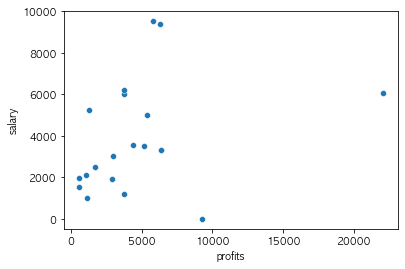

In [438]:
sns.scatterplot(x='profits', y='salary', data=salary)

In [439]:
salary.loc[:, ['profits', 'salary']].corr()

profits    salary
profits  1.000000  0.301959
salary   0.301959  1.000000

In [440]:
### Simple Model fit
model = smf.ols(formula="salary ~ profits", data=salary)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     1.806
Date:                Thu, 31 Aug 2023   Prob (F-statistic):              0.196
Time:                        12:43:08   Log-Likelihood:                -184.30
No. Observations:                  20   AIC:                             372.6
Df Residuals:                      18   BIC:                             374.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3024.1107    822.629      3.676      0.002    1295.832    4752.390
profits        0.1675      0.125      1.344      0.196      -0.094       0.429
==============================================================================
Omnibus:                        3.644   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.162   Jarque-Bera (JB):                2.071
Skew:                           0.770   Prob(JB):                        0.355
Kurtosis:                       3.334   Cond. No.                     9.48e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [441]:
### Multiple Model fit
model = smf.ols(formula="salary ~ age + sales", data=salary)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                 -0.088
Method:                 Least Squares   F-statistic:                    0.2316
Date:                Thu, 31 Aug 2023   Prob (F-statistic):              0.796
Time:                        12:43:08   Log-Likelihood:                -184.99
No. Observations:                  20   AIC:                             376.0
Df Residuals:                      17   BIC:                             379.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1012.7782   8955.327     -0.113      0.911   -1.99e+04    1.79e+04
age           70.4102    144.228      0.488      0.632    -233.885     374.705
sales          0.0087      0.016      0.556      0.585      -0.024       0.042
==============================================================================
Omnibus:                        3.919   Durbin-Watson:                   1.810
Prob(Omnibus):                  0.141   Jarque-Bera (JB):                2.458
Skew:                           0.853   Prob(JB):                        0.293
Kurtosis:                       3.191   Cond. No.                     1.16e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [442]:
### Multiple Model fit
model = smf.ols(formula="salary ~ profits + age + sales + tenure + assets", data=salary)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                 -0.164
Method:                 Least Squares   F-statistic:                    0.4658
Date:                Thu, 31 Aug 2023   Prob (F-statistic):              0.795
Time:                        12:43:08   Log-Likelihood:                -183.72
No. Observations:                  20   AIC:                             379.4
Df Residuals:                      14   BIC:                             385.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    629.5358   2.13e+04      0.030      0.977    -4.5e+04    4.62e+04
profits        0.2069      0.199      1.040      0.316      -0.220       0.633
age           38.8728    361.115      0.108      0.916    -735.641     813.387
sales         -0.0063      0.020     -0.324      0.751      -0.048       0.036
tenure        48.8144    189.934      0.257      0.801    -358.553     456.182
assets        -0.0002      0.001     -0.212      0.835      -0.002       0.002
==============================================================================
Omnibus:                        4.237   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.120   Jarque-Bera (JB):                2.144
Skew:                           0.641   Prob(JB):                        0.342
Kurtosis:                       3.965   Cond. No.                     2.89e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.89e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [443]:
y, x = dmatrices("salary ~ profits + age + sales + tenure + assets", data=salary, return_type="dataframe")

In [444]:
### Backward selection
backward_model(x, y).summary()

Criteria, Before selection: 377.43326978089874
Processed  5 models on 4 predictors in 0.007131099700927734
Selected predictors: ['assets', 'profits', 'sales', 'tenure', 'Intercept'] Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87601b2670>
backward
Criteria:  377.4485646428145
Total elapsed time: 0.012624979019165039 seconds.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 salary   R-squared (uncentered):                   0.735
Model:                            OLS   Adj. R-squared (uncentered):              0.647
Method:                 Least Squares   F-statistic:                              8.341
Date:                Thu, 31 Aug 2023   Prob (F-statistic):                    0.000609
Time:                        12:43:08   Log-Likelihood:                         -183.72
No. Observations:                  20   AIC:                                      377.4
Df Residuals:                      15   BIC:                                      382.4
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           49.5384     24.511      2.021      0.061      -2.706     101.783
assets        -0.0002      0.001     -0.232      0.820      -0.002       0.001
profits        0.2101      0.162      1.300      0.213      -0.134       0.554
sales         -0.0063      0.019     -0.334      0.743      -0.046       0.034
tenure        43.8730     87.604      0.501      0.624    -142.850     230.597
==============================================================================
Omnibus:                        4.436   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.109   Jarque-Bera (JB):                2.291
Skew:                           0.659   Prob(JB):                        0.318
Kurtosis:                       4.006   Cond. No.                     1.25e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.25e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [445]:
### Forward selection
forward_model(x, y).summary()

Criteria, Before selection: 372.5100000708426
Processed  5 models on 1 predictors in
Selected predictors: ['profits', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87a19d9e80>
forward
Criteria:  372.59784786557896
Total elapsed time: 0.012636899948120117 seconds.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 31 Aug 2023   Prob (F-statistic):                nan
Time:                        12:43:08   Log-Likelihood:                -185.26
No. Observations:                  20   AIC:                             372.5
Df Residuals:                      19   BIC:                             373.5
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3817.3500    584.988      6.526      0.000    2592.955    5041.745
==============================================================================
Omnibus:                        3.238   Durbin-Watson:                   1.719
Prob(Omnibus):                  0.198   Jarque-Bera (JB):                2.186
Skew:                           0.809   Prob(JB):                        0.335
Kurtosis:                       2.945   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [446]:
### Stepwise selection
stepwise_model(x, y).summary()

Criteria, Before selection: 372.5100000708426
Processed  5 models on 1 predictors in
Selected predictors: ['profits', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87a19ea8e0>
forward
Processed  1 models on 0 predictors in 0.0019299983978271484
Selected predictors: ['Intercept'] Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87a19eae50>
backward
Criteria:  372.5100000708426
Processed  5 models on 1 predictors in
Selected predictors: ['profits', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87a19f5250>
forward
Processed  1 models on 0 predictors in 0.0018320083618164062
Selected predictors: ['Intercept'] Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87a19eadc0>
backward
Criteria:  372.5100000708426
Processed  5 models on 1 predictors in
Selected predictors: ['profits', 'Intercept']  Criteria:  <stat

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 31 Aug 2023   Prob (F-statistic):                nan
Time:                        12:43:08   Log-Likelihood:                -185.26
No. Observations:                  20   AIC:                             372.5
Df Residuals:                      19   BIC:                             373.5
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3817.3500    584.988      6.526      0.000    2592.955    5041.745
==============================================================================
Omnibus:                        3.238   Durbin-Watson:                   1.719
Prob(Omnibus):                  0.198   Jarque-Bera (JB):                2.186
Skew:                           0.809   Prob(JB):                        0.335
Kurtosis:                       2.945   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [447]:
### Cars data
# 데이터 불러오기
cars = pd.read_csv('./ADP_book_ver01/data/Cars93.csv')
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Manufacturer        93 non-null     object 
 1   Model               93 non-null     object 
 2   Type                93 non-null     object 
 3   Min.Price           93 non-null     float64
 4   Price               93 non-null     float64
 5   Max.Price           93 non-null     float64
 6   MPG.city            93 non-null     int64  
 7   MPG.highway         93 non-null     int64  
 8   AirBags             93 non-null     object 
 9   DriveTrain          93 non-null     object 
 10  Cylinders           93 non-null     object 
 11  EngineSize          93 non-null     float64
 12  Horsepower          93 non-null     int64  
 13  RPM                 93 non-null     int64  
 14  Rev.per.mile        93 non-null     int64  
 15  Man.trans.avail     93 non-null     object 
 16  Fuel.tank.

In [448]:
# ols 모델의 formula을 정의할 때, 일부 특수문자는 쓸 수 없기에, 컬럼 특수문자 제거 
cars.columns = cars.columns.str.replace(".","")

In [449]:
model = smf.ols(formula="Price ~ EngineSize + RPM + Weight + Length + MPGcity + MPGhighway", data=cars)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     19.14
Date:                Thu, 31 Aug 2023   Prob (F-statistic):           4.88e-14
Time:                        12:43:08   Log-Likelihood:                -302.94
No. Observations:                  93   AIC:                             619.9
Df Residuals:                      86   BIC:                             637.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -32.2157     17.812     -1.809      0.074     -67.625       3.193
EngineSize     4.4732      1.410      3.172      0.002       1.670       7.276
RPM            0.0071      0.001      5.138      0.000       0.004       0.010
Weight         0.0056      0.003      1.634      0.106      -0.001       0.012
Length        -0.0464      0.094     -0.496      0.621      -0.232       0.139
MPGcity       -0.3478      0.448     -0.776      0.440      -1.239       0.544
MPGhighway     0.0582      0.460      0.126      0.900      -0.856       0.973
==============================================================================
Omnibus:                       62.984   Durbin-Watson:                   1.446
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              383.289
Skew:                           2.074   Prob(JB):                     5.89e-84
Kurtosis:                      12.039   Cond. No.                     1.61e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [450]:
### correlation 확인
cars[['EngineSize', 'RPM', 'Weight', 'Length', 'MPGcity', 'MPGhighway']].corr()

EngineSize       RPM    Weight    Length   MPGcity  MPGhighway
EngineSize    1.000000 -0.547898  0.845075  0.780283 -0.710003   -0.626795
RPM          -0.547898  1.000000 -0.427931 -0.441249  0.363045    0.313469
Weight        0.845075 -0.427931  1.000000  0.806274 -0.843139   -0.810658
Length        0.780283 -0.441249  0.806274  1.000000 -0.666239   -0.542897
MPGcity      -0.710003  0.363045 -0.843139 -0.666239  1.000000    0.943936
MPGhighway   -0.626795  0.313469 -0.810658 -0.542897  0.943936    1.000000

In [451]:
### VIF 계산
y, x = dmatrices("Price ~ EngineSize + RPM + Weight + Length + MPGcity + MPGhighway", data=cars, return_type="dataframe")

# 독립변수끼리의 VIF값을 계산하여 데이터프레임으로 만드는 과정 
vif_list = []
for i in range(1, len(x.columns)): 
    vif_list.append([variance_inflation_factor(x.values, i), x.columns[i]])
pd.DataFrame(vif_list, columns=['vif', 'variable'])

vif    variable
0   4.605118  EngineSize
1   1.446859         RPM
2   8.685973      Weight
3   4.013002      Length
4  13.668288     MPGcity
5  12.943133  MPGhighway

In [452]:
### MPGcity 변수 제거
model = smf.ols(formula="Price ~ EngineSize + RPM + Weight + MPGhighway", data=cars)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     28.98
Date:                Thu, 31 Aug 2023   Prob (F-statistic):           2.26e-15
Time:                        12:43:08   Log-Likelihood:                -303.29
No. Observations:                  93   AIC:                             616.6
Df Residuals:                      88   BIC:                             629.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -37.7063     14.846     -2.540      0.013     -67.210      -8.203
EngineSize     4.5884      1.343      3.418      0.001       1.920       7.256
RPM            0.0071      0.001      5.232      0.000       0.004       0.010
Weight         0.0049      0.003      1.690      0.095      -0.001       0.011
MPGhighway    -0.2646      0.221     -1.200      0.234      -0.703       0.174
==============================================================================
Omnibus:                       62.072   Durbin-Watson:                   1.398
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              368.013
Skew:                           2.047   Prob(JB):                     1.22e-80
Kurtosis:                      11.843   Cond. No.                     1.35e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [453]:
y, x, vif_df = apply_vif(cars[['EngineSize', 'RPM', 'Weight', 'Length', 'MPGcity', 'MPGhighway', 'Price']], "Price")
vif_df

vif    variable
0  4.471987  EngineSize
1  3.456037      Length
2  3.281779  MPGhighway
3  1.445721         RPM
4  8.597026      Weight

다중공선성 변수(MPGcity) 제거 후 MPGhighway의 유의성이 올라갔음.

In [454]:
### Stepwise selection
stepwise_model(x=x, y=y).summary()

Criteria, Before selection: 686.7529864151061
Processed  5 models on 1 predictors in
Selected predictors: ['Weight', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87923dd460>
forward
Processed  1 models on 0 predictors in 0.0021109580993652344
Selected predictors: ['Intercept'] Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87923dda60>
Criteria:  638.2790669305498
Processed  4 models on 2 predictors in
Selected predictors: ['Weight', 'RPM', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87923f3c10>
forward
Processed  2 models on 1 predictors in 0.0035817623138427734
Selected predictors: ['Weight', 'Intercept'] Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87923dd700>
Criteria:  624.5241529342444
Processed  3 models on 3 predictors in
Selected predictors: ['Weight', 'RPM', 'EngineSize', 'Intercept'] 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     37.98
Date:                Thu, 31 Aug 2023   Prob (F-statistic):           6.75e-16
Time:                        12:43:08   Log-Likelihood:                -304.05
No. Observations:                  93   AIC:                             616.1
Df Residuals:                      89   BIC:                             626.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Weight         0.0073      0.002      3.372      0.001       0.003       0.012
RPM            0.0071      0.001      5.208      0.000       0.004       0.010
EngineSize     4.3054      1.325      3.249      0.002       1.673       6.938
Intercept    -51.7933      9.106     -5.688      0.000     -69.887     -33.699
==============================================================================
Omnibus:                       62.441   Durbin-Watson:                   1.406
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              361.880
Skew:                           2.076   Prob(JB):                     2.62e-79
Kurtosis:                      11.726   Cond. No.                     8.27e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [455]:
### Backward selection
backward_model(x=x, y=y).summary()

Criteria, Before selection: 621.0794757132378
Processed  5 models on 4 predictors in 0.008352041244506836
Selected predictors: ['EngineSize', 'MPGhighway', 'RPM', 'Weight', 'Intercept'] Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87601db760>
backward
Criteria:  616.5890684898023
Processed  4 models on 3 predictors in 0.006348133087158203
Selected predictors: ['EngineSize', 'RPM', 'Weight', 'Intercept'] Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87601db8e0>
backward
Criteria:  616.0976497740974
Processed  3 models on 2 predictors in 0.0043218135833740234
Selected predictors: ['RPM', 'Weight', 'Intercept'] Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87601e4310>
backward
Criteria:  624.5241529342444
Total elapsed time: 0.030751943588256836 seconds.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     37.98
Date:                Thu, 31 Aug 2023   Prob (F-statistic):           6.75e-16
Time:                        12:43:08   Log-Likelihood:                -304.05
No. Observations:                  93   AIC:                             616.1
Df Residuals:                      89   BIC:                             626.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
EngineSize     4.3054      1.325      3.249      0.002       1.673       6.938
RPM            0.0071      0.001      5.208      0.000       0.004       0.010
Weight         0.0073      0.002      3.372      0.001       0.003       0.012
Intercept    -51.7933      9.106     -5.688      0.000     -69.887     -33.699
==============================================================================
Omnibus:                       62.441   Durbin-Watson:                   1.406
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              361.880
Skew:                           2.076   Prob(JB):                     2.62e-79
Kurtosis:                      11.726   Cond. No.                     8.27e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [456]:
### Forward selection
forward_model(x=x, y=y).summary()

Criteria, Before selection: 686.7529864151061
Processed  5 models on 1 predictors in
Selected predictors: ['Weight', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87601db790>
forward
Criteria:  638.2790669305498
Processed  4 models on 2 predictors in
Selected predictors: ['Weight', 'RPM', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87a19f22e0>
forward
Criteria:  624.5241529342444
Processed  3 models on 3 predictors in
Selected predictors: ['Weight', 'RPM', 'EngineSize', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87601e8400>
forward
Criteria:  616.0976497740975
Processed  2 models on 4 predictors in
Selected predictors: ['Weight', 'RPM', 'EngineSize', 'MPGhighway', 'Intercept']  Criteria:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87923ee9a0>
forward
Criteria:  616.5890684898023
Total e

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     37.98
Date:                Thu, 31 Aug 2023   Prob (F-statistic):           6.75e-16
Time:                        12:43:08   Log-Likelihood:                -304.05
No. Observations:                  93   AIC:                             616.1
Df Residuals:                      89   BIC:                             626.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Weight         0.0073      0.002      3.372      0.001       0.003       0.012
RPM            0.0071      0.001      5.208      0.000       0.004       0.010
EngineSize     4.3054      1.325      3.249      0.002       1.673       6.938
Intercept    -51.7933      9.106     -5.688      0.000     -69.887     -33.699
==============================================================================
Omnibus:                       62.441   Durbin-Watson:                   1.406
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              361.880
Skew:                           2.076   Prob(JB):                     2.62e-79
Kurtosis:                      11.726   Cond. No.                     8.27e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

[결과해석]
- (1) 모델 설명 <br>
Stepwise selection을 통해 Weight, RPM, EngineSize가 포함된 다중 선형 회귀 모델을 채택하였다. 이 모델은  Adj.R-square 값이 0.547로 전체 데이터의 약 54.7%를 설명한다. <br>
설명력이 높은 모델은 아니므로 추가적인 변수를 찾아 데이터를 보완해야 할 필요성이 있다.
- (2) 회귀식  <br>
y = 0.0073Weight + 0.0071RPM + 4.3054EngineSize - 51.7933
- (3) 회귀계수 설명  <br>
모델의 성능이 좋지 않아 회귀계수의 값이 정확하다고 말할 수는 없지만, 회귀식에서 차량의 가격에 가장 큰 영향을 주는 변수는 EngineSize라고 할 수 있다. <br>
반면 Weight, RPM은 유의한 변수이지만, 회귀계수가 너무 작아 영향력이 거의 없다.

## Robust-linear Regression

### (1) Huber Regression
- Huber loss fuction 사용

In [458]:
boston = pd.read_csv('./data/housing.csv')
boston.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0    0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1    0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2    0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3    0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4    0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...    ...   
501  0.06263   0.0  11.93     0  0.573  6.593  69.1  2.4786    1  273.0   
502  0.04527   0.0  11.93     0  0.573  6.120  76.7  2.2875    1  273.0   
503  0.06076   0.0  11.93     0  0.573  6.976  91.0  2.1675    1  273.0   
504  0.10959   0.0  11.93     0  0.573  6.794  89.3  2.3889    1  273.0   
505  0.04741   0.0  11.93     0  0.573  6.030  80.8  2.5050    1  273.0   

     PTRATIO       B  LSTAT  MEDV  
0       15.3  396.90   4.98  24.0  
1       17.8  396.90   9.14  21.6  
2       17.8  392.83   4.03  34.7  
3       18.7  394.63   2.94  33.4  
4       18.7  396.90   5.33  36.2  
..       ...     ...    ...   ...  
501     21.0  391.99   9.67  22.4  
502     21.0  396.90   9.08  20.6  
503     21.0  396.90   5.64  23.9  
504     21.0  393.45   6.48  22.0  
505     21.0  396.90   7.88  11.9  

[506 rows x 14 columns]

In [459]:
x = boston.drop('MEDV', axis=1)
y = boston['MEDV']

In [460]:
# The predictor variables should include a constant term.
x = sm.add_constant(x)

# Fit the robust regression model
robust_model = sm.RLM(y, x, M=sm.robust.norms.HuberT())
robust_results = robust_model.fit()
robust_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                   MEDV   No. Observations:                  506
Model:                            RLM   Df Residuals:                      492
Method:                          IRLS   Df Model:                           13
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 31 Aug 2023                                         
Time:                        12:43:09                                         
No. Iterations:                    30                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.9275      3.744      5.056      0.000      11.590      26.265
CRIM          -0.1058      0.024     -4.390      0.000      -0.153      -0.059
ZN             0.0352      0.010      3.496      0.000       0.015       0.055
INDUS      -3.553e-05      0.045     -0.001      0.999      -0.088       0.088
CHAS           1.6097      0.632      2.547      0.011       0.371       2.848
NOX          -10.3676      2.802     -3.700      0.000     -15.860      -4.876
RM             5.0559      0.307     16.491      0.000       4.455       5.657
AGE           -0.0234      0.010     -2.412      0.016      -0.042      -0.004
DIS           -1.1057      0.146     -7.557      0.000      -1.392      -0.819
RAD            0.1957      0.049      4.021      0.000       0.100       0.291
TAX           -0.0112      0.003     -4.058      0.000      -0.017      -0.006
PTRATIO       -0.7722      0.096     -8.046      0.000      -0.960      -0.584
B              0.0110      0.002      5.585      0.000       0.007       0.015
LSTAT         -0.3418      0.037     -9.187      0.000      -0.415      -0.269
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

### (2) Quantile Regression
- 선형 회귀 조건이 충족되지 않을 때 사용되는 선형 회귀의 확장 버전
- 이상치가 많아 이에 대한 영향을 줄인 선형 회귀선을 구할 수 있음
- 점 추정이 아닌 구간추정을 통해 결과의 정확도를 높일 수 있음

In [461]:
# Constructing Distance column
rows = 20
Distance = np.random.uniform(1, 10, rows)
 
# Constructing Emission column
Emission = 40 + Distance + np.random.normal(loc=0, scale=.25*Distance,size=20)
 
# Creating the data set
df = pd.DataFrame({'Distance': Distance,
                   'Emission': Emission})

In [462]:
qreg = smf.quantreg('Emission ~ Distance', df).fit(q=0.5)
qreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:               Emission   Pseudo R-squared:               0.5394
Model:                       QuantReg   Bandwidth:                       4.392
Method:                 Least Squares   Sparsity:                        7.129
Date:                Thu, 31 Aug 2023   No. Observations:                   20
Time:                        12:43:09   Df Residuals:                       18
                                        Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.1763      1.887     20.757      0.000      35.211      43.142
Distance       1.3499      0.306      4.409      0.000       0.707       1.993
==============================================================================
"""

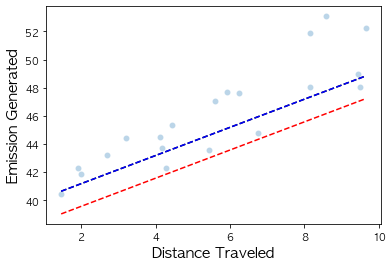

In [463]:
color_dict = {0.1: 'red', 0.5: 'black', 0.9: 'blue'}
for quantile in [0.1, 0.5, 0.9]:
    quantile_reg = smf.quantreg('Emission ~ Distance', df).fit(q = quantile)

    # get y values
    y_line = lambda a, b: a + Distance
    y = y_line(quantile_reg.params['Intercept'], quantile_reg.params['Distance'])
 
    # Plotting data points with the help
    # pf quantile regression equation
    sns.lineplot(x=Distance, y=y, color=color_dict[quantile], linestyle='dashed')

sns.scatterplot(x=Distance, y=Emission, alpha=.3)
plt.xlabel('Distance Traveled', fontsize=15)
plt.ylabel('Emission Generated', fontsize=15)
plt.show()

## Non-linear Regression

### (1) Polymonial Regression

In [464]:
df = pd.DataFrame({'x': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'y': [5, 3, 2, 3, 4, 6, 10, 12, 18]})
df

x   y
0  1   5
1  2   3
2  3   2
3  4   3
4  5   4
5  6   6
6  7  10
7  8  12
8  9  18

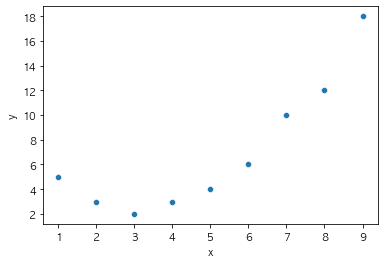

In [465]:
x = df['x']
y = df['y']

sns.scatterplot(x=x, y=y)
plt.show()

In [466]:
model = smf.ols(formula="y ~ x", data=df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     16.99
Date:                Thu, 31 Aug 2023   Prob (F-statistic):            0.00445
Time:                        12:43:09   Log-Likelihood:                -21.732
No. Observations:                   9   AIC:                             47.46
Df Residuals:                       7   BIC:                             47.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1667      2.230     -0.523      0.617      -6.439       4.106
x              1.6333      0.396      4.122      0.004       0.696       2.570
==============================================================================
Omnibus:                        1.451   Durbin-Watson:                   0.696
Prob(Omnibus):                  0.484   Jarque-Bera (JB):                1.008
Skew:                           0.668   Prob(JB):                        0.604
Kurtosis:                       2.051   Cond. No.                         12.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

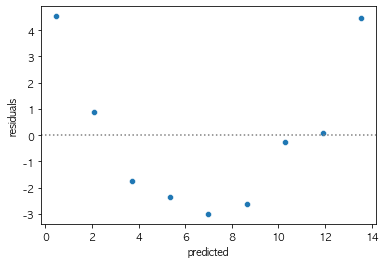

In [467]:
### Manual residual plot
# create a DataFrame of predicted values and residuals
plot_df = pd.DataFrame()
plot_df["predicted"] = result.predict(x)
plot_df["residuals"] = result.resid

sns.scatterplot(data=plot_df, x="predicted", y="residuals") # 2차식이 필요해 보인다.
plt.axhline(y=0, color='gray', linestyle='dotted')

<AxesSubplot:xlabel='x'>

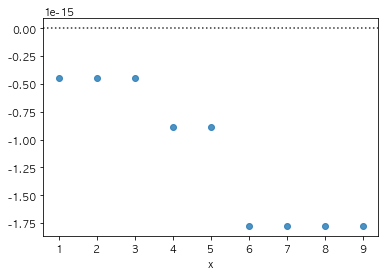

In [468]:
### x값에 따른 residuals
sns.residplot(x=x, y=result.predict(x), data=df)

In [469]:
x_sq = x**2
df['x_sq'] = x_sq

In [470]:
model = smf.ols(formula="y ~ x + x_sq", data=df)
result = model.fit()

y_pred = result.predict(x)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     292.2
Date:                Thu, 31 Aug 2023   Prob (F-statistic):           1.05e-06
Time:                        12:43:10   Log-Likelihood:                -6.6251
No. Observations:                   9   AIC:                             19.25
Df Residuals:                       6   BIC:                             19.84
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.1667      0.787      9.103      0.000       5.240       9.093
x             -2.9121      0.361     -8.056      0.000      -3.797      -2.028
x_sq           0.4545      0.035     12.893      0.000       0.368       0.541
==============================================================================
Omnibus:                        0.843   Durbin-Watson:                   3.026
Prob(Omnibus):                  0.656   Jarque-Bera (JB):                0.023
Skew:                          -0.122   Prob(JB):                        0.989
Kurtosis:                       2.962   Cond. No.                         173.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

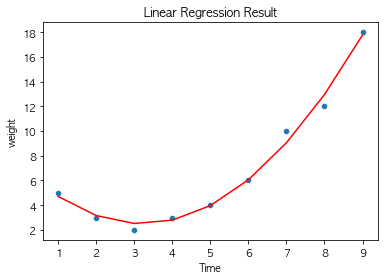

In [471]:
sns.scatterplot(x=x, y=y)
plt.plot(x, y_pred, color='red') ## 회귀직선 추가 
plt.xlabel('Time', fontsize=10)
plt.ylabel('weight',fontsize=10)
plt.title('Linear Regression Result')
plt.show()

<AxesSubplot:xlabel='x', ylabel='y'>

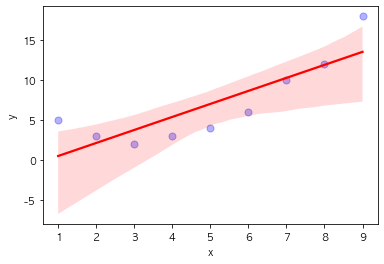

In [472]:
sns.regplot(x=x, y=y, scatter_kws={"fc":"b", "ec":"b", "s":50, "alpha":0.3}, color="r") # regplot으로 한줄 실행

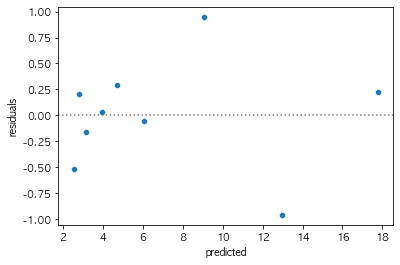

In [473]:
### Manual residual plot
# create a DataFrame of predicted values and residuals
plot_df = pd.DataFrame()
plot_df["predicted"] = result.predict(x)
plot_df["residuals"] = result.resid

sns.scatterplot(data=plot_df, x="predicted", y="residuals")
plt.axhline(y=0, color='gray', linestyle='dotted')

In [474]:
### house data before
# 2차항 추가
model_poly = smf.ols(formula='AdjSalePrice ~ SqFtTotLiving + np.power(SqFtTotLiving, 2) + ' + 
                'SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_98105)
result_poly = model_poly.fit()
result_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     211.6
Date:                Thu, 31 Aug 2023   Prob (F-statistic):          9.95e-106
Time:                        12:43:11   Log-Likelihood:                -4217.9
No. Observations:                 313   AIC:                             8450.
Df Residuals:                     306   BIC:                             8476.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                  -6.159e+05   1.03e+05     -5.953      0.000   -8.19e+05   -4.12e+05
SqFtTotLiving                  7.4521     55.418      0.134      0.893    -101.597     116.501
np.power(SqFtTotLiving, 2)     0.0388      0.010      4.040      0.000       0.020       0.058
SqFtLot                       32.5594      5.436      5.990      0.000      21.863      43.256
Bathrooms                  -1435.1231   1.95e+04     -0.074      0.941   -3.99e+04     3.7e+04
Bedrooms                   -9191.9441   1.33e+04     -0.693      0.489   -3.53e+04    1.69e+04
BldgGrade                   1.357e+05   1.49e+04      9.087      0.000    1.06e+05    1.65e+05
==============================================================================
Omnibus:                       75.161   Durbin-Watson:                   1.625
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              637.978
Skew:                           0.699   Prob(JB):                    2.92e-139
Kurtosis:                       9.853   Cond. No.                     7.37e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.37e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

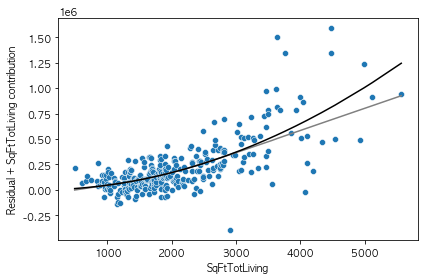

0.038791281682311475


In [475]:
def partialResidualPlot(model, df, outcome, feature):
    y_pred = model.predict(df)
    copy_df = df.copy()
    for c in copy_df.columns:
        if c == feature:
            continue
        copy_df[c] = 0.0
    feature_prediction = model.predict(copy_df)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': df[outcome] - y_pred,
        'ypartial': feature_prediction - model.params[0],
    })
    results = results.sort_values(by=['feature'])
    smoothed = sm.nonparametric.lowess(results.ypartial, results.feature, frac=1/3)
    
    sns.scatterplot(x=results.feature, y = results.ypartial + results.residual)
    sns.lineplot(x=smoothed[:, 0], y=smoothed[:, 1], color='gray') # spline line
    sns.lineplot(x=results.feature, y=results.ypartial, color='black')
    plt.xlabel(feature)
    plt.ylabel(f'Residual + {feature} contribution')

partialResidualPlot(result_poly, house_98105, 'AdjSalePrice', 'SqFtTotLiving')

plt.tight_layout()
plt.show()
print(result_poly.params[2])

### (2) Spline Regression

In [476]:
### house data - continued
formula = ('AdjSalePrice ~ bs(SqFtTotLiving, df=6, degree=3) + ' + # b-spline addec
           'SqFtLot + Bathrooms + Bedrooms + BldgGrade')
model_spline = smf.ols(formula=formula, data=house_98105)
result_spline = model_spline.fit()
result_spline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     131.8
Date:                Thu, 31 Aug 2023   Prob (F-statistic):          7.10e-104
Time:                        12:43:17   Log-Likelihood:                -4211.4
No. Observations:                 313   AIC:                             8445.
Df Residuals:                     302   BIC:                             8486.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                            -4.142e+05   1.43e+05     -2.899      0.004   -6.95e+05   -1.33e+05
bs(SqFtTotLiving, df=6, degree=3)[0] -1.995e+05   1.86e+05     -1.076      0.283   -5.65e+05    1.66e+05
bs(SqFtTotLiving, df=6, degree=3)[1] -1.206e+05   1.23e+05     -0.983      0.326   -3.62e+05    1.21e+05
bs(SqFtTotLiving, df=6, degree=3)[2] -7.164e+04   1.36e+05     -0.525      0.600    -3.4e+05    1.97e+05
bs(SqFtTotLiving, df=6, degree=3)[3]  1.957e+05   1.62e+05      1.212      0.227   -1.22e+05    5.14e+05
bs(SqFtTotLiving, df=6, degree=3)[4]  8.452e+05   2.18e+05      3.878      0.000    4.16e+05    1.27e+06
bs(SqFtTotLiving, df=6, degree=3)[5]  6.955e+05   2.14e+05      3.255      0.001    2.75e+05    1.12e+06
SqFtLot                                 33.3258      5.454      6.110      0.000      22.592      44.059
Bathrooms                            -4778.2080   1.94e+04     -0.246      0.806    -4.3e+04    3.34e+04
Bedrooms                             -5778.7045   1.32e+04     -0.437      0.663   -3.18e+04    2.03e+04
BldgGrade                             1.345e+05   1.52e+04      8.842      0.000    1.05e+05    1.64e+05
==============================================================================
Omnibus:                       58.816   Durbin-Watson:                   1.633
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              622.021
Skew:                           0.330   Prob(JB):                    8.51e-136
Kurtosis:                       9.874   Cond. No.                     1.97e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

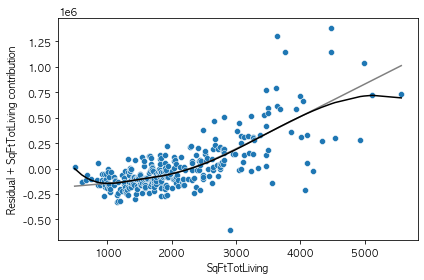

In [477]:
partialResidualPlot(result_spline, house_98105, 'AdjSalePrice', 'SqFtTotLiving')
plt.tight_layout()
plt.show()

In [478]:
from statsmodels.gam.api import GLMGam, BSplines

In [479]:
### Generalized Additive Models
# Spline 회귀를 찾는 데 사용가능
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

x_spline = house_98105[predictors]
bs = BSplines(x_spline, df=[10] + [3] * 4, degree=[3] + [2] * 4)

# penalization weight
alpha = np.array([0] * 5)

formula = 'AdjSalePrice ~ SqFtTotLiving + SqFtLot + Bathrooms + Bedrooms + BldgGrade'
gam_sm = GLMGam.from_formula(formula, data=house_98105, smoother=bs, alpha=alpha)
res_sm = gam_sm.fit()
print(res_sm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           AdjSalePrice   No. Observations:                  313
Model:                         GLMGam   Df Residuals:                      295
Model Family:                Gaussian   Df Model:                        17.00
Link Function:               identity   Scale:                      2.7471e+10
Method:                         PIRLS   Log-Likelihood:                -4196.6
Date:                Thu, 31 Aug 2023   Deviance:                   8.1039e+12
Time:                        12:43:24   Pearson chi2:                 8.10e+12
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9901
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -3.481e+05   1.18e+05  

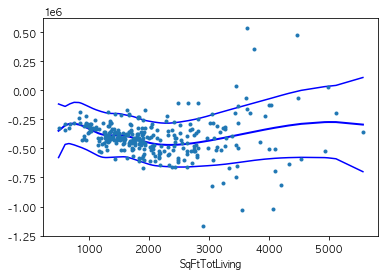

In [480]:
res_sm.plot_partial(0, cpr=True);

### (3) Logistic Regression
- Statistics version

In [481]:
test_result = pd.read_csv("./stats_for_python/6-3-1-logistic-regression.csv")
test_result.head(3)

hours  result
0      0       0
1      0       0
2      0       0

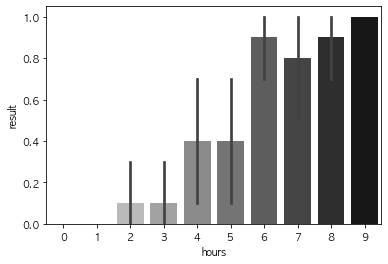

In [482]:
# 공부시간 별 시험 합격률
sns.barplot(x="hours", y="result", data=test_result, palette='gray_r')
plt.show()

In [483]:
# 공부 시간 당 합격률
test_result.groupby("hours").mean()

result
hours        
0         0.0
1         0.0
2         0.1
3         0.1
4         0.4
5         0.4
6         0.9
7         0.8
8         0.9
9         1.0

In [484]:
# Modeling
mod_glm = smf.glm(formula = "result ~ hours", data = test_result, family=sm.families.Binomial()).fit()
mod_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 result   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -34.014
Date:                Thu, 31 Aug 2023   Deviance:                       68.028
Time:                        12:43:25   Pearson chi2:                     84.9
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5032
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.5587      0.901     -5.061      0.000      -6.324      -2.793
hours          0.9289      0.174      5.345      0.000       0.588       1.270
==============================================================================
"""

In [485]:
### Null과 AIC 비교
# Null Model
mod_glm_null = smf.glm("result ~ 1", data = test_result, family=sm.families.Binomial()).fit()
print("Null 모델:", mod_glm_null.aic.round(3))
print("변수가 있는 모델:", mod_glm.aic.round(3))

Null 모델: 139.989
변수가 있는 모델: 72.028


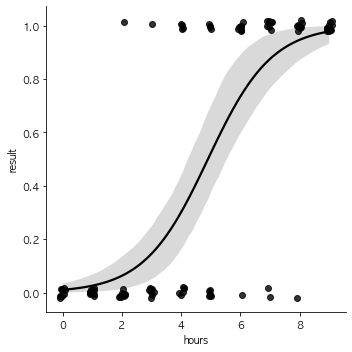

In [486]:
# lmplot 회귀 곡선
sns.lmplot(x="hours", y="result",
           data=test_result, 
           logistic=True,
           scatter_kws={"color": "black"},
           line_kws={"color": "black"},
           x_jitter=0.1, y_jitter=0.02)

In [487]:
exp_val = pd.DataFrame({
    "hours": np.arange(0, 10, 1)
})

# 합격 확률 예측
pred = mod_glm.predict(exp_val)
pred

0    0.010367
1    0.025836
2    0.062920
3    0.145291
4    0.300876
5    0.521427
6    0.733929
7    0.874741
8    0.946467
9    0.978147
dtype: float64

In [488]:
### Odds ratio 계산
# 공부시간 1시간일 때의 합격률
exp_val_1 = pd.DataFrame({"hours": [1]})
pred_1 = mod_glm.predict(exp_val_1)

# 공부시간 2시간일 때의 합격률
exp_val_2 = pd.DataFrame({"hours": [2]})
pred_2 = mod_glm.predict(exp_val_2)

# Odds
odds_1 = pred_1 / (1 - pred_1)
odds_2 = pred_2 / (1 - pred_2)

# Log Odds ratio -> Parameter
np.log(odds_2 / odds_1)

0    0.92889
dtype: float64

In [489]:
mod_glm.params["hours"]

0.9288901756284946

In [490]:
# Pearson Residual
mod_glm.resid_pearson.head(3)

0   -0.102351
1   -0.102351
2   -0.102351
dtype: float64

In [491]:
# Pearson chi-square statistic
mod_glm.pearson_chi2

84.91138782569973

In [492]:
np.sum(mod_glm.resid_pearson**2)

84.91138782569973

In [493]:
# Deviance Residual
mod_glm.resid_deviance.head(3)

0   -0.144369
1   -0.144369
2   -0.144369
dtype: float64

In [494]:
# Deviance statistic
np.sum(mod_glm.resid_deviance ** 2)

68.02788118117269

In [495]:
from sklearn.datasets import load_iris

In [496]:
### Iris data
iris = load_iris()
iris = pd.DataFrame(iris.data, columns=iris.feature_names)
iris['Class'] = load_iris().target
iris['Class'] = iris['Class'].map({0: 'Setosa', 1: 'Versicolour', 2: 'Virginica'})

iris.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

    Class  
0  Setosa  
1  Setosa  
2  Setosa  
3  Setosa  
4  Setosa

In [497]:
# Binary class & 숫자 label로 변경 -> ROC, AUC를 구해보기 위함
iris = iris[iris.Class != 'Setosa']
iris['Class'] = np.where(iris.Class=='Virginica', 1, 0) 

In [498]:
### sepal length 별 Class 확률
iris.groupby('sepal length (cm)')['Class'].mean()

sepal length (cm)
4.9    0.500000
5.0    0.000000
5.1    0.000000
5.2    0.000000
5.4    0.000000
5.5    0.000000
5.6    0.166667
5.7    0.166667
5.8    0.500000
5.9    0.333333
6.0    0.333333
6.1    0.333333
6.2    0.500000
6.3    0.666667
6.4    0.714286
6.5    0.800000
6.6    0.000000
6.7    0.625000
6.8    0.666667
6.9    0.750000
7.0    0.000000
7.1    1.000000
7.2    1.000000
7.3    1.000000
7.4    1.000000
7.6    1.000000
7.7    1.000000
7.9    1.000000
Name: Class, dtype: float64

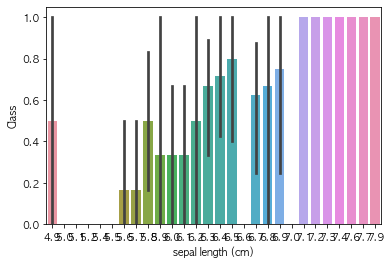

In [499]:
sns.barplot(x="sepal length (cm)", y="Class", data=iris)
plt.show()

In [500]:
iris['sepal_length'] = iris['sepal length (cm)'] # formula 에러 방지

In [501]:
model = smf.glm(formula="Class ~ sepal_length", data=iris, family=sm.families.Binomial())
results = model.fit()

print(results.summary()) # coef에 대해서는 wald test 결과를 보여줌

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Class   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -55.273
Date:                Thu, 31 Aug 2023   Deviance:                       110.55
Time:                        12:43:31   Pearson chi2:                     100.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2448
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -12.5708      2.907     -4.325   

In [502]:
results.predict(iris['sepal_length'])

50     0.820495
51     0.577361
52     0.788918
53     0.182473
54     0.625566
         ...   
145    0.714191
146    0.527636
147    0.625566
148    0.477357
149    0.333030
Length: 100, dtype: float64

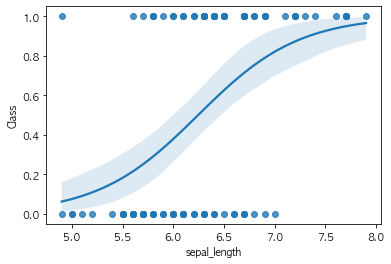

In [503]:
# plot logistic regression curve
sns.regplot(x='sepal_length', y='Class', data=iris, logistic=True, ci=95)
plt.show()

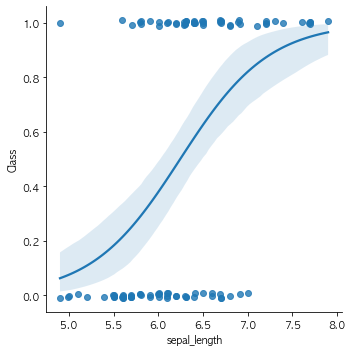

In [504]:
sns.lmplot(x='sepal_length', y='Class', data=iris, logistic=True, ci=95, x_jitter=0.01, y_jitter=0.01) # jitter: data를 흐트리는 옵션
plt.show()

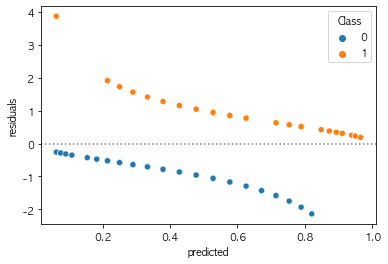

In [505]:
plot_df = pd.DataFrame()
plot_df["predicted"] = results.predict(iris['sepal_length'])
plot_df["residuals"] = results.resid_pearson

sns.scatterplot(data=plot_df, x="predicted", y="residuals", hue=iris['Class'])
plt.axhline(y=0, color='gray', linestyle='dotted')
plt.show()

In [506]:
# pearson chi-sq
print(results.pearson_chi2)
print(np.sum(results.resid_pearson**2))

100.14283284175455
100.14283284175455


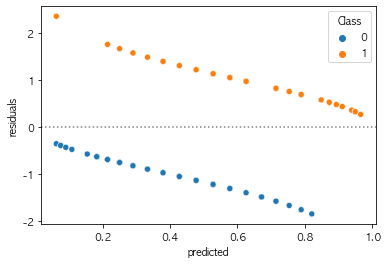

In [507]:
plot_df["residuals"] = results.resid_deviance

sns.scatterplot(data=plot_df, x="predicted", y="residuals", hue=iris['Class'])
plt.axhline(y=0, color='gray', linestyle='dotted')
plt.show()

In [508]:
# summary의 Deviance 값과 일치
# logistic에서는 cross-entropy 개념과 동일
np.sum(results.resid_deviance**2) 

110.54652398942652

In [509]:
### Multiple Logistic
mtcars.head()

mpg  cyl   disp   hp  drat     wt   qsec  vs  am  gear  \
Mazda RX4          21.0    6  160.0  110  3.90  2.620  16.46   0   1     4   
Mazda RX4 Wag      21.0    6  160.0  110  3.90  2.875  17.02   0   1     4   
Datsun 710         22.8    4  108.0   93  3.85  2.320  18.61   1   1     4   
Hornet 4 Drive     21.4    6  258.0  110  3.08  3.215  19.44   1   0     3   
Hornet Sportabout  18.7    8  360.0  175  3.15  3.440  17.02   0   0     3   

                   carb  mpg_sqrt  
Mazda RX4             4  4.582576  
Mazda RX4 Wag         4  4.582576  
Datsun 710            1  4.774935  
Hornet 4 Drive        1  4.626013  
Hornet Sportabout     2  4.324350

In [510]:
model = smf.glm(formula="vs ~ mpg + am", data=mtcars, family=sm.families.Binomial())
results = model.fit()

print(results.summary()) # coef에 대해서는 wald test 결과를 보여줌

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     vs   No. Observations:                   32
Model:                            GLM   Df Residuals:                       29
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10.323
Date:                Thu, 31 Aug 2023   Deviance:                       20.646
Time:                        12:43:39   Pearson chi2:                     20.2
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5159
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.7051      4.625     -2.747      0.0

In [511]:
results.aic

26.64629286928622

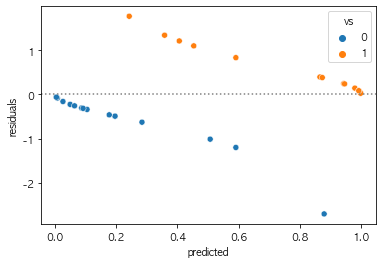

In [512]:
plot_df = pd.DataFrame()
plot_df["predicted"] = results.predict(mtcars.loc[:, ['mpg', 'am']])
plot_df["residuals"] = results.resid_pearson

sns.scatterplot(data=plot_df, x="predicted", y="residuals", hue=mtcars['vs'])
plt.axhline(y=0, color='gray', linestyle='dotted')
plt.show()

In [513]:
results.cov_params()

Intercept       mpg        am
Intercept  21.392589 -1.155050  4.406337
mpg        -1.155050  0.063693 -0.267584
am          4.406337 -0.267584  2.558336

### (4) Probit Regression
- Dose-Response analysis
- 정규분포 누적확률변수를 이용한 이진 분류
- 이진 변수 y는 베르누이 분포를 따른다고 가정

In [514]:
hmda = pd.read_csv("./r_csv/AER/HMDA.csv", index_col="Unnamed: 0")
hmda.head()

deny  pirat  hirat     lvrat  chist  mhist phist  unemp selfemp insurance  \
1   no  0.221  0.221  0.800000      5      2    no    3.9      no        no   
2   no  0.265  0.265  0.921875      2      2    no    3.2      no        no   
3   no  0.372  0.248  0.920398      1      2    no    3.2      no        no   
4   no  0.320  0.250  0.860465      1      2    no    4.3      no        no   
5   no  0.360  0.350  0.600000      1      1    no    3.2      no        no   

  condomin afam single hschool  
1       no   no     no     yes  
2       no   no    yes     yes  
3       no   no     no     yes  
4       no   no     no     yes  
5       no   no     no     yes

In [515]:
hmda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2380 entries, 1 to 2380
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   deny       2380 non-null   object 
 1   pirat      2380 non-null   float64
 2   hirat      2380 non-null   float64
 3   lvrat      2380 non-null   float64
 4   chist      2380 non-null   int64  
 5   mhist      2380 non-null   int64  
 6   phist      2380 non-null   object 
 7   unemp      2380 non-null   float64
 8   selfemp    2380 non-null   object 
 9   insurance  2380 non-null   object 
 10  condomin   2380 non-null   object 
 11  afam       2380 non-null   object 
 12  single     2380 non-null   object 
 13  hschool    2380 non-null   object 
dtypes: float64(4), int64(2), object(8)
memory usage: 278.9+ KB


In [516]:
hmda["deny_binary"] = hmda["deny"].apply(lambda x: 1 if x=="yes" else 0)

In [517]:
from statsmodels.discrete.discrete_model import Probit

In [518]:
x = hmda["pirat"]
x = sm.add_constant(x)
y = hmda["deny_binary"]

probit = Probit(y, x).fit()
probit.summary()

Optimization terminated successfully.
         Current function value: 0.349493
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:            deny_binary   No. Observations:                 2380
Model:                         Probit   Df Residuals:                     2378
Method:                           MLE   Df Model:                            1
Date:                Thu, 31 Aug 2023   Pseudo R-squ.:                 0.04620
Time:                        12:43:39   Log-Likelihood:                -831.79
converged:                       True   LL-Null:                       -872.09
Covariance Type:            nonrobust   LLR p-value:                 2.783e-19
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1942      0.129    -17.010      0.000      -2.447      -1.941
pirat          2.9679      0.359      8.265      0.000       2.264       3.672
==============================================================================
"""

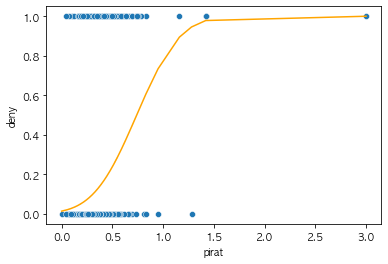

In [519]:
## 시각화
hmda["probit"]= probit.predict(x)

plt.xlabel("pirat")
plt.ylabel("deny")
sns.scatterplot(x=hmda["pirat"], y=hmda["deny_binary"])
sns.lineplot(data=hmda, x="pirat", y="probit", color='orange')
plt.show()

In [520]:
## new_data
pirat = np.array([0.3, 0.4])
const = np.array([1, 1])

x_new = pd.DataFrame([const, pirat]).T
x_new.columns = ["const", "pirat"]
probit.predict(x_new).diff()[1] ### 0.3 -> 0.4로 갈 때의 deny 확률 변화

0.06081519410509767

In [521]:
### Race의 deny 영향도
hmda["black"] = hmda["afam"].apply(lambda x :1 if x=="yes" else 0)

x2 = hmda[["pirat", "black"]]
x2 = sm.add_constant(x2)

probit2 = Probit(y, x2).fit()
probit2.summary()

Optimization terminated successfully.
         Current function value: 0.334931
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:            deny_binary   No. Observations:                 2380
Model:                         Probit   Df Residuals:                     2377
Method:                           MLE   Df Model:                            2
Date:                Thu, 31 Aug 2023   Pseudo R-squ.:                 0.08594
Time:                        12:43:46   Log-Likelihood:                -797.14
converged:                       True   LL-Null:                       -872.09
Covariance Type:            nonrobust   LLR p-value:                 2.818e-33
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2587      0.130    -17.391      0.000      -2.513      -2.004
pirat          2.7416      0.360      7.624      0.000       2.037       3.446
black          0.7082      0.083      8.488      0.000       0.545       0.872
==============================================================================
"""

In [522]:
## new_data
black =np.array([0, 1])
pirat =np.array([0.3, 0.3])
const = np.array([1, 1])

x_new = pd.DataFrame([const, pirat, black]).T
x_new.columns = ["const", "pirat", "black"]
probit2.predict(x_new).diff()[1] ### black 여부에 따른 확률 변화

0.15781349122942923

### (5) Isotonic Regression
- x가 커질 때 y도 같이 커지는(monotonous increase) 경우

In [523]:
n = 20
x = np.arange(n)
print('Input:\n',x)
y = np.random.randint(0, 20, size=n) + 10 * np.log1p(np.arange(n))
print("Target :\n",y)

Input:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Target :
 [ 3.         19.93147181 29.98612289 27.86294361 34.09437912 32.91759469
 33.45910149 20.79441542 33.97224577 36.02585093 27.97895273 30.8490665
 25.64949357 29.3905733  44.08050201 32.72588722 42.33213344 35.90371758
 43.44438979 33.95732274]


In [524]:
from sklearn.isotonic import IsotonicRegression

In [525]:
ir = IsotonicRegression() 
  
# Fit isotonic regression model
y_ir = ir.fit_transform(x, y) # fit the model and transform the data
print('Isotonic Regression Predictions  :\n', y_ir)

Isotonic Regression Predictions  :
 [ 3.         19.93147181 28.92453325 28.92453325 30.31637268 30.31637268
 30.31637268 30.31637268 30.6443638  30.6443638  30.6443638  30.6443638
 30.6443638  30.6443638  38.40319462 38.40319462 38.90939089 38.90939089
 38.90939089 38.90939089]


In [526]:
from matplotlib.collections import LineCollection

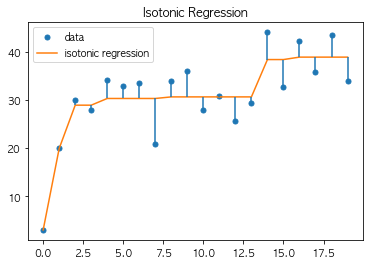

In [527]:
lines=[[[i,y[i]],[i,y_ir[i]]] for i in range(n)]
  
# Line to measure the difference between actual and target value
lc=LineCollection(lines)
  
# plt.figure(figsize=(10,4))
plt.plot(x, y, '.', markersize=10, label='data')
plt.plot(x, y_ir, '-', markersize=10,label='isotonic regression' )
  
plt.gca().add_collection(lc)
plt.legend() # add a legend
  
plt.title("Isotonic Regression")
plt.show()

### (6) Poisson Regression
- 연속형 변수가 카운트 변수에 미치는 영향 파악

In [528]:
# 맥주 판매 개수 예측
beer = pd.read_csv("./stats_for_python/6-5-1-poisson-regression.csv")
beer.head(3)

beer_number  temperature
0            6         17.5
1           11         26.6
2            2          5.0

In [529]:
# Modeling
mod_pois = smf.glm("beer_number ~ temperature", beer, family=sm.families.Poisson()).fit()
mod_pois.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            beer_number   No. Observations:                   30
Model:                            GLM   Df Residuals:                       28
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -57.672
Date:                Thu, 31 Aug 2023   Deviance:                       5.1373
Time:                        12:43:47   Pearson chi2:                     5.40
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9708
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.4476      0.199      2.253      0.024       0.058       0.837
temperature     0.0761      0.008      9.784      0.000       0.061       0.091
===============================================================================
"""

In [530]:
### Null과 AIC 비교
# Null Model
mod_pois_null = smf.glm("beer_number ~ 1", data=beer, family=sm.families.Poisson()).fit()
print("Null 모델:", mod_pois_null.aic.round(3))
print("변수가 있는 모델:", mod_pois.aic.round(3))

Null 모델: 223.363
변수가 있는 모델: 119.343


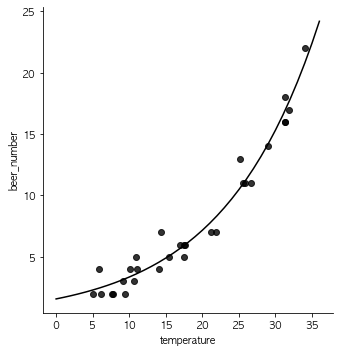

In [531]:
x_plot = np.arange(0, 37)
pred = mod_pois.predict(pd.DataFrame({"temperature": x_plot}))

sns.lmplot(y="beer_number", x="temperature", data=beer, fit_reg = False,
          scatter_kws = {"color":"black"})
sns.lineplot(x=x_plot, y=pred, color="black")
plt.show()

In [532]:
# 기온이 1도일 때 판매 개수 기댓값
exp_val_1 = pd.DataFrame({"temperature": [1]})
pred_1 = mod_pois.predict(exp_val_1)

# 기온이 2도일 때 판매 개수 기댓값
exp_val_2 = pd.DataFrame({"temperature": [2]})
pred_2 = mod_pois.predict(exp_val_2)

# 비율 확인
pred_2 / pred_1

0    1.079045
dtype: float64

In [533]:
np.exp(mod_pois.params["temperature"])

1.079045054586893

### (7) Bayesian Regression
- Likeilhood (관측값에서 모델이 가지는 가능도)를 최소화하는 회귀식 도출
- Bayes Method 관련 상세 설명은 Bayesian Analysis 파트 참조

#### PyMC3

In [534]:
from sklearn.datasets import make_regression

In [535]:
x, y_data, coef = make_regression(n_samples=100, n_features=1, bias=0, noise=20, coef=True, random_state=1)
x = x.flatten()
coef

array(80.71051956)

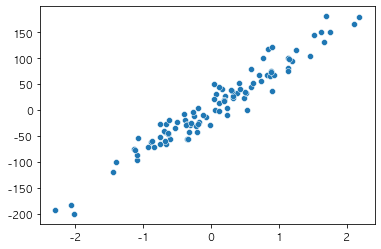

In [536]:
sns.scatterplot(x=x, y=y_data)
plt.show()

In [537]:
import pymc3 as pm

In [538]:
### Normal dist를 가정한 1차원 Regression
with pm.Model() as m:
    w = pm.Normal('w', mu=0, sd=50)
    b = pm.Normal('b', mu=0, sd=50)
    esd = pm.HalfCauchy('esd', 5)
    y = pm.Normal('y', mu=w * x + b, sd=esd, observed=y_data)

    start = pm.find_MAP()
    step = pm.NUTS()
    trace1 = pm.sample(10000, step=step, start=start)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [esd, b, w]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 39 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


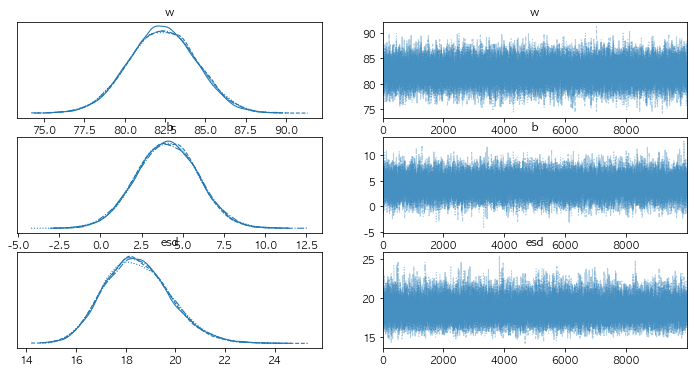

In [539]:
pm.traceplot(trace1)
plt.show()

In [540]:
pm.summary(trace1)

Got error No model on context stack. trying to find log_likelihood in translation.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
w    82.353  2.113  78.373   86.268      0.010    0.007   45457.0   29333.0   
b     4.058  1.875   0.622    7.663      0.008    0.006   51373.0   30161.0   
esd  18.479  1.337  16.089   21.049      0.006    0.004   49493.0   28206.0   

     r_hat  
w      1.0  
b      1.0  
esd    1.0

In [541]:
data = pd.read_csv("https://raw.githubusercontent.com/ADPclass/ADP_book_ver01/main/data/26_problem7.csv")
data.head()

height  weight  waistline
0  174.396  72.102    79.3787
1  179.656  81.255    80.6649
2  175.079  76.207    80.3166
3  180.804  81.354    80.8794
4  177.448  78.768    80.3499

In [542]:
# 1000번의 burn-in 이후 10,000의 MCMC를 수행
# 회귀계수의 사전분포는 부적절한 균일분포(inproper uniform prior distribution),
# 오차항의 분산의 사전분포는 역감마 분포로 지정. 형상(Shape)모수와 척도(Scale)모수는 각각 0.005로 지정.
# Random seed 1234
with pm.Model() as m:
    x_1 = pm.Data('x_1', data["height"])
    x_2 = pm.Data('x_2', data["weight"])
    y = pm.Data('y', data["waistline"])

    w_1 = pm.Uniform('w_1')
    w_2 = pm.Uniform('w_2')
    b = pm.Uniform('b')
    esd = pm.InverseGamma('esd', alpha=0.005, beta=0.005)
    y_pred = pm.Normal('y_pred', mu=b + (w_1 * x_1) + (w_2 * x_2), sd=esd, observed=y)
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(10000, step=step, start=start, tune=1000, random_seed=1234) # tune -> burn-in

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [esd, b, w_2, w_1]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 57 seconds.
There were 620 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.718609063058261, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1917 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5995900657377911, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1284 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6106822288675913, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1504 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5999407032000418, but should be cl

In [543]:
with m:
    pm.set_data({'x_1': [180], 'x_2': [85]})
    y_test = pm.sample_posterior_predictive(trace)

In [544]:
y_test['y_pred'].mean()

82.1938519666769

#### ARDRegression
- Automatic Relevance Determination Regression (ARD)
- Lasso Regression의 Bayesian 버전

In [545]:
from sklearn.linear_model import ARDRegression

In [546]:
x = data[["height", "weight"]]
y = data["waistline"]

In [547]:
# 1000번의 burn-in 이후 10,000의 MCMC를 수행
# 회귀계수의 사전분포는 부적절한 균일분포(inproper uniform prior distribution),
# 오차항의 분산의 사전분포는 역감마 분포로 지정. 형상(Shape)모수와 척도(Scale)모수는 각각 0.005로 지정.
ard = ARDRegression(threshold_lambda=10000, alpha_2=0.005, lambda_2=0.005, fit_intercept=False) ## 부적절한 균일분포, inverse gamma를 0.005로 지정
ard.fit(x, y)

ARDRegression(alpha_2=0.005, fit_intercept=False, lambda_2=0.005,
              threshold_lambda=10000)

In [548]:
ard.coef_

array([ 0.54450434, -0.20484747])

In [549]:
ard.predict([[180, 85]])

array([80.59874677])

#### BayesianRidge

In [550]:
from sklearn.linear_model import BayesianRidge

In [551]:
# 1000번의 burn-in 이후 10,000의 MCMC를 수행
# 회귀계수의 사전분포는 부적절한 균일분포(inproper uniform prior distribution),
# 오차항의 분산의 사전분포는 역감마 분포로 지정. 형상(Shape)모수와 척도(Scale)모수는 각각 0.005로 지정.
bridge = BayesianRidge(alpha_2=0.005, lambda_2=0.005, fit_intercept=False) ## 부적절한 균일분포, inverse gamma를 0.005로 지정
bridge.fit(x, y)

BayesianRidge(alpha_2=0.005, fit_intercept=False, lambda_2=0.005)

In [552]:
bridge.coef_

array([ 0.54469948, -0.20530278])

In [553]:
bridge.predict([[180, 85]])

array([80.59517033])

## Survival Analysis
- 관심 있는 사건이 발생할 때까지 예상되는 기간 조사
    - Event: 관심 경험 (생존/사망 또는 체류/사퇴)
    - Survival time: event가 발생할 때 까지의 기간
- Survival Function: T는 사건이 발생하고 t가 관측 중인 임의의 시점일 때 생존 S(t)는 T가 t보다 클 확률
- Censorship Problem(절단 문제): 관측 중단 관측치(Censored observations)는 사건이 일부 개인에 대해 기록되지 않은 경우 사건 발생 시간 데이터에서 발생함
    - 이벤트가 아직 발생하지 않은 경우(즉, 생존 시간을 알 수 없음/아직 사임하지 않은 사람의 경우 오해의 소지가 있음)
    - 데이터가 누락되거나(즉, 드롭아웃) contact 하는 포인트를 잃게 된 것 경우
- Censorship Problem Type
    - 좌측 관측 중단(Left-Censored): 생존 기간이 관찰된 기간보다 작음
    - 우측 관측 중단(Right-Censored): 생존 기간이 관찰된 기간보다 큼
    - 구간 관측 중단됨(Interval-Censored): 생존 기간을 정확히 정의할 수 없음
- Hazard Function
    - 위험 함수 또는 위험률 h(t)는 개인이 시간 t까지 생존하고 정확히 시간 t에 관심 있는 사건을 경험할 확률
    - 조위험함수는 조건부 확률로 정의되어 있다. 즉, 모든 개체에 대한 사건이 아니라 시간 t까지 살아있는 개체들에 대한 위험율
    - 위험함수는 아주 짧은 시간에 일아날 사건의 확률로서 순간적인(instantaneous)인 의미를 가지며, 아주 짧은 시간에 일어나는 극한의 의미임
    - 위험함수는 확률로서 정의되지만 발생률(rate)로 이해할 수 있음 분모는 확률이고 분자는 시간으로 표시되기 때문에 단위 시간당 일어나는 발생률로 이해할 수 있음

### (1) Kaplan-Meier Estimator
- 우측 관측 중단 관측치 처리
- 비모수적 방법으로 분포 가정이 필요하지 않음

In [554]:
df = pd.read_csv('./data/HR-Employee-Attrition.csv')
df[['YearsAtCompany', 'Attrition']].head()

YearsAtCompany Attrition
0               6       Yes
1              10        No
2               0       Yes
3               8        No
4               2        No

In [555]:
# !pip install lifelines
from sklearn.preprocessing import LabelEncoder
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

In [556]:
# Convert the Attrition into binary variable
encoder = LabelEncoder()
df['Attrition'] = encoder.fit_transform(df['Attrition'])

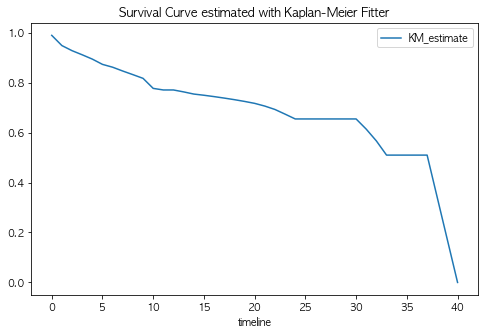

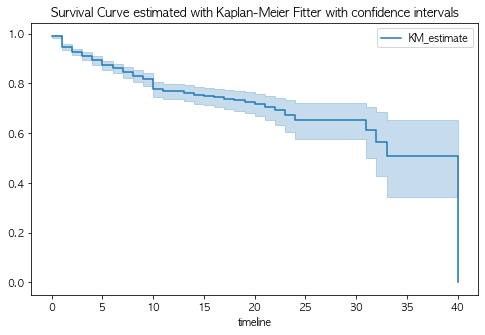

In [557]:
kmf = KaplanMeierFitter()
kmf.fit(durations=df['YearsAtCompany'], event_observed=df['Attrition'])

kmf.survival_function_.plot(figsize=(8, 5))
plt.title('Survival Curve estimated with Kaplan-Meier Fitter')
plt.show()

kmf.plot_survival_function(figsize=(8, 5))
plt.title('Survival Curve estimated with Kaplan-Meier Fitter with confidence intervals')
plt.show()

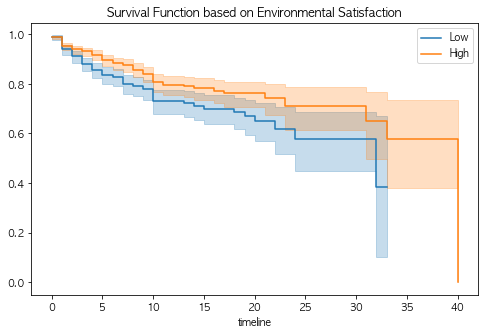

In [558]:
EnvironmentalLow = ((df['EnvironmentSatisfaction']==1) | (df['EnvironmentSatisfaction']==2))
EnvironmentalHigh = ((df['EnvironmentSatisfaction']==3) | (df['EnvironmentSatisfaction']==4))

ax = plt.subplot()
kmf = KaplanMeierFitter()

kmf.fit(durations=df[EnvironmentalLow]['YearsAtCompany'], 
        event_observed=df[EnvironmentalLow]['Attrition'], 
        label='Low')
kmf.plot_survival_function(figsize=(8, 5), ax=ax)

kmf.fit(durations=df[EnvironmentalHigh]['YearsAtCompany'], 
        event_observed=df[EnvironmentalHigh]['Attrition'], 
        label='High')
kmf.plot_survival_function(figsize=(8, 5), ax=ax)
plt.title('Survival Function based on Environmental Satisfaction')
plt.show();

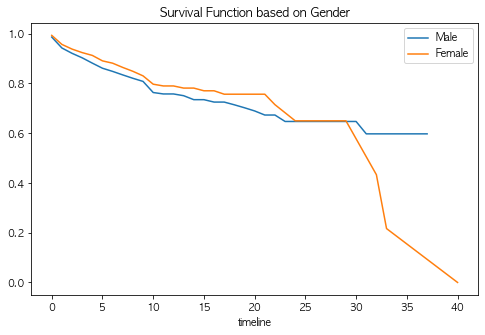

In [559]:
male = (df['Gender']=='Male')
female = (df['Gender']=='Female')

ax = plt.subplot()
kmf = KaplanMeierFitter()

kmf.fit(durations=df[male]['YearsAtCompany'], event_observed=df[male]['Attrition'], label='Male')
kmf.survival_function_.plot(figsize=(8, 5), ax=ax)
kmf.fit(durations=df[female]['YearsAtCompany'], event_observed=df[female]['Attrition'], label='Female')
kmf.survival_function_.plot(figsize=(8, 5), ax=ax)
plt.title('Survival Function based on Gender')
plt.show();

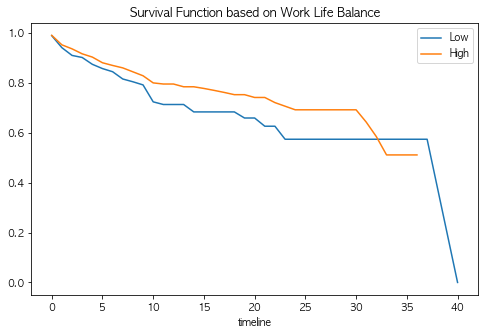

In [560]:
worklifelow = ((df['WorkLifeBalance'] == 1) | (df['WorkLifeBalance'] == 2))
worklifehigh = ((df['WorkLifeBalance'] == 3) | (df['WorkLifeBalance'] == 4))

ax = plt.subplot()
kmf = KaplanMeierFitter()

kmf.fit(durations=df[worklifelow]['YearsAtCompany'], 
        event_observed=df[worklifelow]['Attrition'], 
        label='Low')
kmf.survival_function_.plot(figsize=(8,5), ax=ax)

kmf.fit(durations=df[worklifehigh]['YearsAtCompany'], 
        event_observed=df[worklifehigh]['Attrition'], 
        label='High')
kmf.survival_function_.plot(figsize=(8,5), ax=ax)
plt.title('Survival Function based on Work Life Balance')
plt.show();

In [561]:
### Log rank test
# H0: both groups have the same distribution curve
# H1: the two groups are different
output = logrank_test(durations_A = df[worklifelow]['YearsAtCompany'],
                      durations_B = df[worklifehigh]['YearsAtCompany'],
                      event_observed_A = df[worklifelow]['Attrition'],
                      event_observed_B = df[worklifehigh]['Attrition'])
output.print_summary

<bound method StatisticalResult.print_summary of <lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.40 0.04      4.80>

In [562]:
### Probability predict
kmf.predict(6)

0.8689826396104314

In [563]:
from itertools import combinations

BusinessTravel ['Travel_Rarely', 'Travel_Frequently', 'Non-Travel']
Department ['Sales', 'Research & Development', 'Human Resources']
EducationField ['Life Sciences', 'Other', 'Medical', 'Marketing', 'Technical Degree', 'Human Resources']
Gender ['Female', 'Male']
JobRole ['Sales Executive', 'Research Scientist', 'Laboratory Technician', 'Manufacturing Director', 'Healthcare Representative', 'Manager', 'Sales Representative', 'Research Director', 'Human Resources']
MaritalStatus ['Single', 'Married', 'Divorced']
Over18 ['Y']
OverTime ['Yes', 'No']


<AxesSubplot:xlabel='p_value', ylabel='Count'>

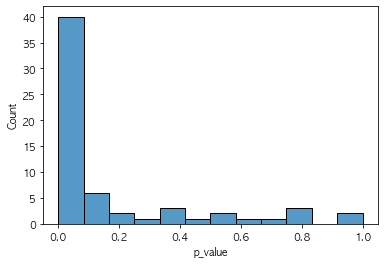

In [564]:
group_cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']
results = []
for col in group_cols :
    choices = list(df[col].unique())
    print(col,choices)
    candidates = list(combinations(choices, 2))
    for a_group, b_group in candidates :
        A_GROUP = df.query(f"{col}=='{a_group}'")
        B_GROUP = df.query(f"{col}=='{b_group}'")

        output = logrank_test(durations_A = A_GROUP['YearsAtCompany'],
                            durations_B = B_GROUP['YearsAtCompany'],
                            event_observed_A = A_GROUP['Attrition'],
                            event_observed_B = B_GROUP['Attrition'])
        p_value = output.p_value
        results.append([col,a_group,b_group,p_value])
result_table = pd.DataFrame(results,columns=['column', "a_group", "b_group", "p_value"])
sns.histplot(result_table['p_value'])

### (2) Cox Proportional-Hazards Model
- 생존 기간과 영향을 미치는 여러 가지 요인들을 알아보는 분석 방법
- hazrad assumption이 유지된다는 가정
    - 샘플 간 생존 시간은 독립적
    - 예측 변수와 hazard 사이에 곱셈 관계
    - 시간이 지남에 따라 일정한 위험 비율
- 위험(Hazard)은 생존 곡선의 기울기로 정의됨. 피험자가 얼마나 빨리 죽어가는지를 측정
- 위험 비율은 두 그룹 비교. 위험비가 2.0이면 한 그룹의 사망률은 다른 그룹의 사망률의 두 배

In [565]:
from lifelines import CoxPHFitter

In [566]:
columns_selected = ['Attrition', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 
                    'PercentSalaryHike', 'RelationshipSatisfaction', 'StockOptionLevel', 'TrainingTimesLastYear', 'YearsAtCompany']
df = df[columns_selected]

In [567]:
coxph = CoxPHFitter()
coxph.fit(df, duration_col='YearsAtCompany', event_col='Attrition')

# Current employees
df_new = df.loc[df['Attrition'] == 0]

# Years at the company of current employees
df_new_obs = df_new['YearsAtCompany']

# Predict survival function for the employes still in the company
predictions = coxph.predict_survival_function(df_new, conditional_after=df_new_obs)
pd.DataFrame(predictions).head(11).iloc[:, :5]

1         3         4         5         6
0.0   1.000000  1.000000  1.000000  1.000000  1.000000
1.0   0.986432  0.954723  0.960284  0.962204  0.988253
2.0   0.986432  0.832633  0.916395  0.921246  0.978083
3.0   0.967805  0.809508  0.861182  0.810189  0.966473
4.0   0.945323  0.809508  0.827520  0.789045  0.951264
5.0   0.932830  0.778306  0.780170  0.789045  0.941632
6.0   0.915764  0.741487  0.733267  0.760458  0.927576
7.0   0.896696  0.721424  0.683692  0.726633  0.913012
8.0   0.873145  0.694475  0.556009  0.708160  0.896843
9.0   0.842240  0.664989  0.532844  0.683295  0.850746
10.0  0.805808  0.629479  0.532844  0.656022  0.841555

<AxesSubplot:>

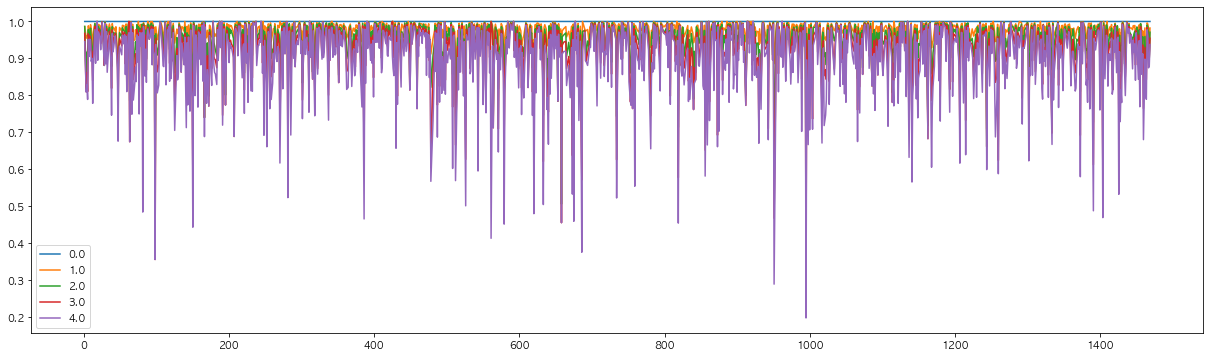

In [568]:
pd.DataFrame(predictions).head().T.plot(figsize=(21, 6))

<AxesSubplot:xlabel='log(HR) (95% CI)'>

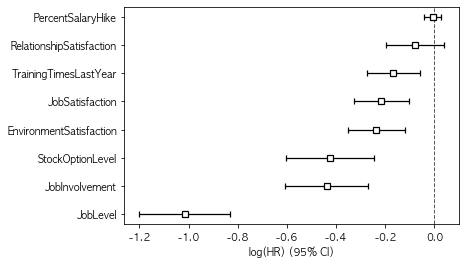

In [569]:
coxph.plot()

In [570]:
coxph.check_assumptions(df)

Proportional hazard assumption looks okay.


[]

### (3) Accelerated Failure Time (AFT) Model
- Cox-PH 모델의 비례 위험 가정 기준을 만족하지 못하는 경우에는 파라메트릭 모델을 사용하는 것이 더 나은 접근 방식이며, AFT는 파라메트릭 모델 중 하나
- 생존 함수가 모수적 연속 분포를 따른다고 가정 (Weibull 분포 또는 로그 정규 분포 등)
- 두 모집단(예: P 및 Q)에서 파생된 생존 함수가 공변량의 함수로 모델링할 수 있는 acceleration 계수 람다(λ)와 관련이 있다고 가정
- 공변량을 기반으로 고장 시간을 가속화하거나 감속

In [571]:
from lifelines import WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter

In [572]:
# Instantiate each fitter
wb = WeibullFitter()
ex = ExponentialFitter()
log = LogNormalFitter()
loglogis = LogLogisticFitter()

# Fit to data
for model in [wb, ex, log, loglogis]:
    model.fit(durations = df["YearsAtCompany"].replace(0 , 0.000001), event_observed = df["Attrition"])
    # Print AIC
    print("The AIC value for", model.__class__.__name__, "is",  model.AIC_)

The AIC value for WeibullFitter is 2138.2708129525727
The AIC value for ExponentialFitter is 2263.9437336059136
The AIC value for LogNormalFitter is 2276.8859677966007
The AIC value for LogLogisticFitter is 2151.579769001517


In [573]:
LogLogistic_aft = LogLogisticFitter() # best model
LogLogistic_aft.fit(durations=df['YearsAtCompany'].replace(0 , 0.000001), event_observed=df['Attrition'])
LogLogistic_aft.print_summary(3)

<lifelines.LogLogisticFitter:"LogLogistic_estimate", fitted with 1470 total observations, 1233 right-censored observations>
   number of observations = 1470
number of events observed = 237
           log-likelihood = -1073.790
               hypothesis = alpha_ != 1, beta_ != 1

---
          coef   se(coef)   coef lower 95%   coef upper 95%
alpha_ 123.013     26.194           71.673          174.353
beta_    0.581      0.035            0.513            0.648

         cmp to       z       p   -log2(p)
alpha_    1.000   4.658 <0.0005     18.257
beta_     1.000 -12.130 <0.0005    110.073
---
AIC = 2151.580

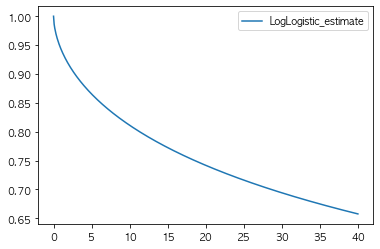

In [574]:
LogLogistic_aft.survival_function_.plot()
plt.show()

In [575]:
# 공변량의 단위 증가는 평균/중간 생존 시간이 exp(계수)만큼 변경됨을 나타냅니다.
# 계수가 양수이면 exp(계수)가 >1이 되어 사건/이벤트 시간이 느려지며, 마찬가지로 음의 계수는 평균/중간 생존 시간을 줄입니다.
LogLogistic_aft.median_survival_time_

123.01280287855722

<AxesSubplot:>

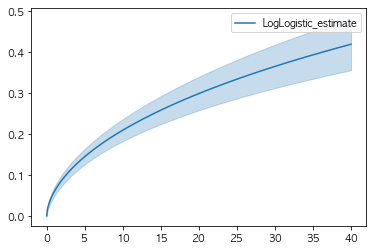

In [576]:
LogLogistic_aft.plot()

## Correlation Analysis
- 두 변수의 관계를 알아보기 위함
- 상관계수를 구하고, 상관계수의 유의성 검정 진행
    - H0: 변수 간 상관성이 없다 (상관계수가 0이다)
    - 검정통계량은 df n-2인 T분포
- 상관계수 종류
    - Covariance
    - Pearson correlation: 선형 관계 측정. 일반적으로 사용
    - Spearman correlation: Rank correlation으로, 비선형 관계도 측정 가능
    - Kendall's Tau
    - Cramer's V
    - Auto-correlation coef

In [297]:
mtcars.head()

mpg  cyl   disp   hp  drat     wt   qsec  vs  am  gear  \
Mazda RX4          21.0    6  160.0  110  3.90  2.620  16.46   0   1     4   
Mazda RX4 Wag      21.0    6  160.0  110  3.90  2.875  17.02   0   1     4   
Datsun 710         22.8    4  108.0   93  3.85  2.320  18.61   1   1     4   
Hornet 4 Drive     21.4    6  258.0  110  3.08  3.215  19.44   1   0     3   
Hornet Sportabout  18.7    8  360.0  175  3.15  3.440  17.02   0   0     3   

                   carb  
Mazda RX4             4  
Mazda RX4 Wag         4  
Datsun 710            1  
Hornet 4 Drive        1  
Hornet Sportabout     2

### (1) Covariance matrix

In [299]:
mtcars.cov()

mpg         cyl          disp           hp       drat  \
mpg    36.324103   -9.172379   -633.097208  -320.732056   2.195064   
cyl    -9.172379    3.189516    199.660282   101.931452  -0.668367   
disp -633.097208  199.660282  15360.799829  6721.158669 -47.064019   
hp   -320.732056  101.931452   6721.158669  4700.866935 -16.451109   
drat    2.195064   -0.668367    -47.064019   -16.451109   0.285881   
wt     -5.116685    1.367371    107.684204    44.192661  -0.372721   
qsec    4.509149   -1.886855    -96.051681   -86.770081   0.087141   
vs      2.017137   -0.729839    -44.377621   -24.987903   0.118649   
am      1.803931   -0.465726    -36.564012    -8.320565   0.190151   
gear    2.135685   -0.649194    -50.802621    -6.358871   0.275988   
carb   -5.363105    1.520161     79.068750    83.036290  -0.078407   

              wt       qsec         vs         am       gear       carb  
mpg    -5.116685   4.509149   2.017137   1.803931   2.135685  -5.363105  
cyl     1.367371  -1.886855  -0.729839  -0.465726  -0.649194   1.520161  
disp  107.684204 -96.051681 -44.377621 -36.564012 -50.802621  79.068750  
hp     44.192661 -86.770081 -24.987903  -8.320565  -6.358871  83.036290  
drat   -0.372721   0.087141   0.118649   0.190151   0.275988  -0.078407  
wt      0.957379  -0.305482  -0.273661  -0.338105  -0.421081   0.675790  
qsec   -0.305482   3.193166   0.670565  -0.204960  -0.280403  -1.894113  
vs     -0.273661   0.670565   0.254032   0.042339   0.076613  -0.463710  
am     -0.338105  -0.204960   0.042339   0.248992   0.292339   0.046371  
gear   -0.421081  -0.280403   0.076613   0.292339   0.544355   0.326613  
carb    0.675790  -1.894113  -0.463710   0.046371   0.326613   2.608871

### (2) Correlation

#### Pearson
- scipy.stats 라이브러리를 이용할 경우, 상관계수에 대한 유의검정 p-value 추출 가능

In [ ]:
mtcars.loc[:, ['drat', 'disp']].corr() # pearson corr

In [300]:
stats.pearsonr(mtcars.drat, mtcars.disp) # 2개 column 상관분석

(-0.7102139271692701, 5.282021688157213e-06)

In [301]:
mtcars.rcorr() # pingouin import 후에 사용 가능. pearson correlation

mpg     cyl    disp      hp    drat      wt    qsec     vs     am  \
mpg        -     ***     ***     ***     ***     ***       *    ***    ***   
cyl   -0.852       -     ***     ***     ***     ***     ***    ***     **   
disp  -0.848   0.902       -     ***     ***     ***       *    ***    ***   
hp    -0.776   0.832   0.791       -      **     ***     ***    ***          
drat   0.681    -0.7   -0.71  -0.449       -     ***              *    ***   
wt    -0.868   0.782   0.888   0.659  -0.712       -            ***    ***   
qsec   0.419  -0.591  -0.434  -0.708   0.091  -0.175       -    ***          
vs     0.664  -0.811   -0.71  -0.723    0.44  -0.555   0.745      -          
am       0.6  -0.523  -0.591  -0.243   0.713  -0.692   -0.23  0.168      -   
gear    0.48  -0.493  -0.556  -0.126     0.7  -0.583  -0.213  0.206  0.794   
carb  -0.551   0.527   0.395    0.75  -0.091   0.428  -0.656  -0.57  0.058   

       gear carb  
mpg      **   **  
cyl      **   **  
disp    ***    *  
hp           ***  
drat    ***       
wt      ***    *  
qsec         ***  
vs           ***  
am      ***       
gear      -       
carb  0.274    -

In [302]:
# 특정 변수 지정 가능
housing.drop('ocean_proximity', axis=1).corr()["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

#### Spearman
- 범주형 번수의 Pearson 상관계수

In [303]:
stats.spearmanr(mtcars.wt, mtcars.cyl)

SpearmanrResult(correlation=0.8577281622201577, pvalue=3.5741568243795457e-10)

In [304]:
mtcars.corr(method='spearman')

mpg       cyl      disp        hp      drat        wt      qsec  \
mpg   1.000000 -0.910801 -0.908882 -0.894665  0.651455 -0.886422  0.466936   
cyl  -0.910801  1.000000  0.927652  0.901791 -0.678881  0.857728 -0.572351   
disp -0.908882  0.927652  1.000000  0.851043 -0.683592  0.897706 -0.459782   
hp   -0.894665  0.901791  0.851043  1.000000 -0.520125  0.774677 -0.666606   
drat  0.651455 -0.678881 -0.683592 -0.520125  1.000000 -0.750390  0.091869   
wt   -0.886422  0.857728  0.897706  0.774677 -0.750390  1.000000 -0.225401   
qsec  0.466936 -0.572351 -0.459782 -0.666606  0.091869 -0.225401  1.000000   
vs    0.706597 -0.813789 -0.723664 -0.751593  0.447457 -0.587016  0.791571   
am    0.562006 -0.522071 -0.624068 -0.362328  0.686571 -0.737713 -0.203332   
gear  0.542782 -0.564310 -0.594470 -0.331402  0.744816 -0.676128 -0.148200   
carb -0.657498  0.580068  0.539778  0.733379 -0.125223  0.499812 -0.658718   

            vs        am      gear      carb  
mpg   0.706597  0.562006  0.542782 -0.657498  
cyl  -0.813789 -0.522071 -0.564310  0.580068  
disp -0.723664 -0.624068 -0.594470  0.539778  
hp   -0.751593 -0.362328 -0.331402  0.733379  
drat  0.447457  0.686571  0.744816 -0.125223  
wt   -0.587016 -0.737713 -0.676128  0.499812  
qsec  0.791571 -0.203332 -0.148200 -0.658718  
vs    1.000000  0.168345  0.282662 -0.633695  
am    0.168345  1.000000  0.807688 -0.064365  
gear  0.282662  0.807688  1.000000  0.114887  
carb -0.633695 -0.064365  0.114887  1.000000

In [305]:
mtcars.rcorr(method='spearman', padjust='holm') # spearman with holm adjust

mpg     cyl    disp      hp    drat      wt    qsec      vs      am  \
mpg        -     ***     ***     ***      **     ***             ***       *   
cyl   -0.911       -     ***     ***     ***     ***       *     ***       *   
disp  -0.909   0.928       -     ***     ***     ***             ***      **   
hp    -0.895   0.902   0.851       -       *     ***     ***     ***           
drat   0.651  -0.679  -0.684   -0.52       -     ***                     ***   
wt    -0.886   0.858   0.898   0.775   -0.75       -              **     ***   
qsec   0.467  -0.572   -0.46  -0.667   0.092  -0.225       -     ***           
vs     0.707  -0.814  -0.724  -0.752   0.447  -0.587   0.792       -           
am     0.562  -0.522  -0.624  -0.362   0.687  -0.738  -0.203   0.168       -   
gear   0.543  -0.564  -0.594  -0.331   0.745  -0.676  -0.148   0.283   0.808   
carb  -0.657    0.58    0.54   0.733  -0.125     0.5  -0.659  -0.634  -0.064   

       gear carb  
mpg       *   **  
cyl       *    *  
disp     **    *  
hp           ***  
drat    ***       
wt      ***       
qsec          **  
vs            **  
am      ***       
gear      -       
carb  0.115    -

In [306]:
### Subject data
subject.head()

korean  math  english  science
0      85    80       80       90
1      75    60       70      100
2      65    75       69       50
3      78    40       79       80
4      59    50       80       67

In [307]:
subject.rcorr(method='spearman')

korean    math english science
korean       -                        
math     0.497       -                
english  0.202   0.129       -        
science    0.0  -0.062  -0.425       -

#### Kendall's Tau
- Measure of the correspondence between two rankings
- 순위 일치도
- 순위의 상관계수

In [308]:
from scipy.stats import kendalltau

In [309]:
x = [1, 2, 3, 4, 5, 6, 7]
y = [1, 3, 6, 2, 7, 4, 5]
  
# Calculating Kendall Rank correlation
kendalltau(x, y)

KendalltauResult(correlation=0.4285714285714286, pvalue=0.2388888888888889)

#### Kendall's W
- Kendall's coefficient of concordance
- Non-parametric statistic for rank correlation
- 세 집단 이상의 상관성 계산 가능

In [310]:
# !pip install kendall-w
import kendall_w.kendall_w as kw

In [311]:
annotations = [[1, 1, 1, 2], [2, 2, 2, 3], [3, 3, 3, 1]]
kw.compute_w(annotations)

0.4375

#### Cramer's V
- 명목형 (범주형) 변수의 상관관계 계산
- Contingency table 형식으로 input 생성해야 함

In [312]:
dataset = np.array([[13, 17, 11], [4, 6, 9], [20, 31, 42]])
dataset

array([[13, 17, 11],
       [ 4,  6,  9],
       [20, 31, 42]])

In [313]:
# Finding Chi-squared test statistic, sample size, and minimum of rows and columns
chi_2 = stats.chi2_contingency(dataset, correction=False)[0]
n = np.sum(dataset)
minimum_dimension = min(dataset.shape)-1
  
# Calculate Cramer's V
result = np.sqrt((chi_2/n) / minimum_dimension)
  
# Print the result
print(result)

0.12181939439334678


### (3) Partial Correlation
- 일반적인 다중 상관관계 분석을 통한 변수간의 상관계수는 특정 두 변수간의 순수한 상관관계를 나타낸다고 할 수 없음
- 특정 변수의 영향을 제거한 상태에서의 두 변수간의 순수한 상관관계를 파악하기 위해선 편(부분) 상관관계 분석이라는 기법을 사용해야 함
- 두 변수 x, y 각각에서 제 3의 변수 z에 의해 선형적으로 설명되는 부분을 제거하고 남은 잔차들간의 상관계수를 구해야 함

In [314]:
from pingouin import partial_corr

In [315]:
# Pearson
partial_corr(data=mtcars, x='mpg', y='cyl', covar='wt', method='pearson') # covar -> 통제하고자 하는 공변량

n         r           CI95%     p-val
pearson  32 -0.559577  [-0.76, -0.26]  0.001064

In [316]:
# Spearman
partial_corr(data=mtcars, x='mpg', y='cyl', covar='wt', method='spearman') # covar -> 통제하고자 하는 공변량

n         r           CI95%     p-val
spearman  32 -0.632407  [-0.81, -0.36]  0.000135

### (4) Auto Correlation
- 시계열 데이터 사이의 상관성
- 특정 시점(t)의 데이터와 t+n의 데이터 간의 상관계수 파악
- ACF function

#### ACF

In [317]:
arima_data.head()

price
day              
2013-01-01   3794
2013-02-01   3863
2013-03-01   5190
2013-04-01   5783
2013-05-01   6298

In [318]:
from statsmodels.tsa.stattools import acf

In [319]:
acf(arima_data['price'], nlags=20, fft=False)

array([ 1.        ,  0.77575788,  0.47639678,  0.16797485, -0.0878652 ,
       -0.3509353 , -0.41848041, -0.33608992, -0.10503294,  0.09613129,
        0.3563047 ,  0.58874409,  0.70429246,  0.52473355,  0.2821513 ,
        0.03539529, -0.17125724, -0.37462784, -0.42056632, -0.34696581,
       -0.16477475])

In [320]:
acf(arima_data['price'], nlags=20, qstat=True) # Ljung-Box q statistic & p-value 추가. 잔차가 white noise를 따르는 지 확인 -> H0: 잔차가 white noise를 따른다.

(array([ 1.        ,  0.77575788,  0.47639678,  0.16797485, -0.0878652 ,
        -0.3509353 , -0.41848041, -0.33608992, -0.10503294,  0.09613129,
         0.3563047 ,  0.58874409,  0.70429246,  0.52473355,  0.2821513 ,
         0.03539529, -0.17125724, -0.37462784, -0.42056632, -0.34696581,
        -0.16477475]),
 array([ 37.94401844,  52.50037174,  54.34180767,  54.85465569,
         63.18445145,  75.24867676,  83.17693947,  83.96614588,
         84.64021172,  94.08551774, 120.40031253, 158.8424724 ,
        180.63576012, 187.07373436, 187.17730135, 189.65693865,
        201.79850112, 217.46466365, 228.38742506, 230.91244191]),
 array([7.28039383e-10, 3.97822304e-12, 9.48671046e-12, 3.48496886e-11,
        2.66598267e-12, 3.41146236e-14, 3.09359282e-15, 7.75246413e-15,
        1.92493244e-14, 8.26131919e-16, 1.50616176e-20, 9.03974065e-28,
        1.25875615e-31, 2.36853084e-32, 8.44659679e-32, 9.67338596e-32,
        1.24496569e-33, 3.13582644e-36, 7.12714627e-38, 7.85057907e-38]))

In [321]:
acf(arima_data['price'], nlags=20, alpha=0.05) # Confidence Interval

(array([ 1.        ,  0.77575788,  0.47639678,  0.16797485, -0.0878652 ,
        -0.3509353 , -0.41848041, -0.33608992, -0.10503294,  0.09613129,
         0.3563047 ,  0.58874409,  0.70429246,  0.52473355,  0.2821513 ,
         0.03539529, -0.17125724, -0.37462784, -0.42056632, -0.34696581,
        -0.16477475]),
 array([[ 1.        ,  1.        ],
        [ 0.52272762,  1.02878815],
        [ 0.10078526,  0.85200831],
        [-0.24451169,  0.5804614 ],
        [-0.50470823,  0.32897783],
        [-0.76896243,  0.06709184],
        [-0.85496247,  0.01800165],
        [-0.79754545,  0.12536562],
        [-0.58190307,  0.3718372 ],
        [-0.38221769,  0.57448028],
        [-0.12327958,  0.83588897],
        [ 0.09250097,  1.08498722],
        [ 0.16518078,  1.24340414],
        [-0.07037744,  1.11984454],
        [-0.34187969,  0.9061823 ],
        [-0.5967507 ,  0.66754128],
        [-0.80353011,  0.46101562],
        [-1.00986363,  0.26060796],
        [-1.06979327,  0.22866063],
 

In [322]:
from statsmodels.graphics.tsaplots import plot_acf

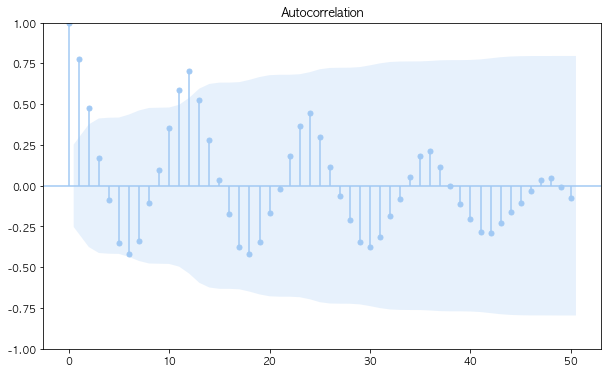

In [323]:
plot_acf(x=arima_data['price'], lags=50)
plt.show()

#### Partial ACF
- 특정 시점(t)의 데이터와 t+n의 데이터 간의 상관계수 파악하되, 그 사이에 있는 시점 데이터의 영향도 제거

In [324]:
from statsmodels.tsa.stattools import pacf

In [325]:
pacf(arima_data['price'], nlags=20)

array([ 1.        ,  0.78890632, -0.34306071, -0.22423997, -0.1232589 ,
       -0.39768343,  0.30771301,  0.13977001,  0.35822355, -0.02132234,
        0.41418364,  0.4704723 ,  0.23373142, -0.65603062, -0.59451517,
       -0.34472427,  0.29950263,  0.57985284, -0.04939371, -1.34571401,
        0.33253078])

In [326]:
pacf(arima_data['price'], nlags=20, alpha=0.05)

(array([ 1.        ,  0.78890632, -0.34306071, -0.22423997, -0.1232589 ,
        -0.39768343,  0.30771301,  0.13977001,  0.35822355, -0.02132234,
         0.41418364,  0.4704723 ,  0.23373142, -0.65603062, -0.59451517,
        -0.34472427,  0.29950263,  0.57985284, -0.04939371, -1.34571401,
         0.33253078]),
 array([[ 1.        ,  1.        ],
        [ 0.53587606,  1.04193658],
        [-0.59609098, -0.09003045],
        [-0.47727023,  0.02879029],
        [-0.37628916,  0.12977137],
        [-0.65071369, -0.14465316],
        [ 0.05468275,  0.56074328],
        [-0.11326026,  0.39280027],
        [ 0.10519328,  0.61125381],
        [-0.2743526 ,  0.23170792],
        [ 0.16115338,  0.6672139 ],
        [ 0.21744204,  0.72350257],
        [-0.01929885,  0.48676168],
        [-0.90906088, -0.40300035],
        [-0.84754543, -0.3414849 ],
        [-0.59775453, -0.09169401],
        [ 0.04647237,  0.5525329 ],
        [ 0.32682258,  0.8328831 ],
        [-0.30242398,  0.20363655],
 

In [327]:
from statsmodels.graphics.tsaplots import plot_pacf

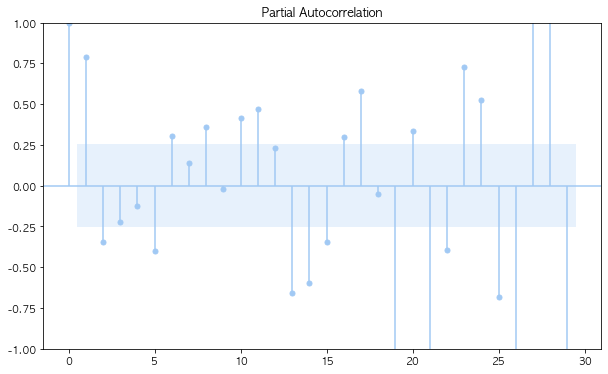

In [328]:
plot_pacf(x=arima_data['price'], lags=29)
plt.show()

### (5) CCA
- Canonical Correlation Analysis (정준상관분석)
- 각 집단의 두 선형 결합에 대한 상관분석. 요인분석과 다변량 회귀분석의 역할을 결합한 분석방법으로 알려져 있음
- 모든 변수들은 원칙적으로 연속형이어야 하지만 범주형 변수일 경우 더미 변수화하여 분석에 사용할 수 있음
- 각각 p, q 개로 이루어진 두 변수 그룹 X와 Y가 있을 때, X와 Y를 소속된 개별 변수들간의 선형결합으로 이루어진 정준변수라 하고, 정준변수 X와 Y 사이의 상관계수 p를 정준상관계수라고 함
- 가능한 모든 선형결합 중 두 변수 X,Y 간 상관계수를 최대화 시키는 선형결합 X,Y를 찾으며 이때, 선형결합을 나타내는 개별 변수들의 계수들을 정준계수라고 함
- 정준변수간 상관계수가 최대일 때는 제1 정준상관계수라고 하고 이에 대응되는 정준변수는 제1 정준변수라 함
- X와 Y의 가능한 모든 선형결합 중에서 제1 정준변수 쌍과는 서로 상관 없으면서 상관계수를 가장 크게 해주는 또 다른 선형결합 X와 Y가 제2 정준변수
- 정준상관분석의 목적은 정준상관계수와 정준변수를 추정하는 것 외에도 정준적재량과 교차적재량을 통해 두 변수 그룹간의 관계에 대한 각 변수의 상대적 영향력을 확인하는 것
    - 정준적재량 (canonical loadings): 정준변수와 해당 정준변수를 구성하는 측정변수들 사이의 상관계수
    - 교차적재량 (cross loadings): 정준변수와 대립하는 정준변수의 측정 변수들 사이의 상관계수
    - 이를 통해 변수 그룹들 사이에 내포된 상대적 중요도의 의미를 파악할 수 있음
- 차원축소 방법으로도 사용

In [329]:
from sklearn.cross_decomposition import CCA

In [330]:
x = cca_data[['Weight', 'Waist', 'Pulse']].values ## 설명 변수 집단: 생리적 변수
y = cca_data[['Chins', 'Situps', 'Jumps']].values ## 종속 변수 집단: 운동량 변수

In [331]:
# 귀무가설: 생리적 변수는 운동량과 연관성이 없다
# 연구가설: 생리적 변수는 운동량과 유의한 상관관계를 가지고 있다.

# 정준변수 구하기
cca = CCA(n_components=1).fit(x, y)
x_c, y_c = cca.transform(x, y)

In [332]:
x_c1 = pd.DataFrame(x_c)[0]
y_c1 = pd.DataFrame(x_c)[0]
print(x_c)
print('\n', y_c)

[[-0.02468003]
 [ 0.28186932]
 [ 0.46275646]
 [ 0.15657182]
 [-0.25055945]
 [ 0.10792552]
 [ 0.15097223]
 [-0.203494  ]
 [-1.2698048 ]
 [-0.23314634]
 [-0.19259852]
 [-0.42858299]
 [ 0.00978148]
 [ 1.77820899]
 [-0.04172843]
 [ 0.00339145]
 [ 0.50445943]
 [-0.54821989]
 [-0.25950936]
 [-0.00361289]]

 [[-0.095968  ]
 [ 0.71700988]
 [ 0.76491769]
 [ 0.03728794]
 [-0.42811337]
 [ 0.54137737]
 [ 0.2989697 ]
 [ 0.11422451]
 [-1.29213118]
 [ 0.1778875 ]
 [-0.39350495]
 [-0.52661561]
 [-0.74610916]
 [ 1.42618716]
 [ 0.72020543]
 [-0.4237238 ]
 [ 0.88430825]
 [-1.05155077]
 [-1.26193648]
 [ 0.53727785]]


In [333]:
# 정준상관계수 구하기
cc_1 = stats.pearsonr(x_c1, y_c1)
print('제1정준상관계수:', cc_1)

# 정준적재량, 교차적재량
print('생리적 정준변수와 해당 변수들간 정준적재량:', np.corrcoef(x_c1.T, x.T)[0, 1:])
print('생리적 정준변수와 운동량 변수들간 교차적재량:', np.corrcoef(x_c1.T, y.T)[0, 1:])
print('운동량 정준변수와 해당 변수들간 정준적재량:', np.corrcoef(y_c1.T, y.T)[0, 1:])
print('운동량 정준변수와 생리적 변수들간 교차적재량:', np.corrcoef(y_c1.T, x.T)[0, 1:])

제1정준상관계수: (1.0, 0.0)
생리적 정준변수와 해당 변수들간 정준적재량: [ 0.62065861  0.92543282 -0.33284891]
생리적 정준변수와 운동량 변수들간 교차적재량: [-0.57890573 -0.65059385 -0.12904413]
운동량 정준변수와 해당 변수들간 정준적재량: [-0.57890573 -0.65059385 -0.12904413]
운동량 정준변수와 생리적 변수들간 교차적재량: [ 0.62065861  0.92543282 -0.33284891]


In [334]:
print(cca.coef_)

[[  2.23882453  29.77930328   4.84091049]
 [ -4.56024769 -60.65727657  -9.86042029]
 [  0.17069351   2.2704476    0.36908297]]


## Association Analysis
- 사건의 연관규칙을 찾는 방법
- A -> B

### (1) Run test
#### One sample

In [590]:
data = ['a', 'a', 'b', 'b', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'a', 'a', 'b', 'b', 'a', 'b', 'b']

test_df = pd.DataFrame(data, columns=["product"])
test_df.head()

product
0       a
1       a
2       b
3       b
4       a

귀무가설(H0) <br>
연속적인 관측값이 임의적이다.<br>
대립가설(H1)<br>
연속적인 관측값이 임의적이지 않다 (연관이 있다).<br>

In [591]:
from statsmodels.sandbox.stats.runs import runstest_1samp

In [592]:
# Run-test를 위한 데이터 변환 
test_df.loc[test_df['product']=='a', 'product']=1
test_df.loc[test_df['product']=='b', 'product']=0

# Perform Runs test
runstest_1samp(test_df['product'], cutoff=0.5, correction=True)

(-1.1144881152070183, 0.26506984027306035)

[결과해석]
P-value가 유의수준 (0.05)보다 크므로 귀무가설을 기각하지 않는다. 즉, 상품 a와 b의 구매에는 연관이 없다.

#### Two sample
- 두 표본이 같은 분포에서 나왔는지 테스트
- Wald–Wolfowitz Run test

H0: The two populations have the same distribution. <br>
H1: The two populations have different distributions. 

In [593]:
from statsmodels.sandbox.stats.runs import runstest_2samp

In [594]:
x = [31.8, 32.8, 39.2, 36, 30, 34.5, 37.4]
y = [35.5, 27.6, 21.3, 24.8, 36.7, 30]

res = runstest_2samp(x, y)
res

ties detected


(0.022428065200812752, 0.9821064931864921)

[결과해석]
P-value가 유의수준 (0.05)보다 크므로 귀무가설을 기각하지 않는다. 즉, x와 y는 같은 분포에서 온 것으로 볼 수 있다.

### (2) Association rules
- 조건-결과 식으로 표현되는 유용한 패턴을 발견해 내는 것
- 장바구니분석, 서열분석
- 간단하지만, 품목수가 많으면 계산량이 기하급수적으로 증가하므로, 적절한 품목 결정 필요
- 측정 지표
    - 지지도 (Support): 전체 거래 중 품목 A, B가 동시에 포함되는 거래의 비율. 전체 구매 경향 파악
    - 신뢰도 (Confidence): 품목 A가 포함된 거래 중 A, B가 동시에 포함되는 거래의 비율. A -> B 연관성 정도
    - 향상도 (Lift): 품목 B를 구매한 고객 중, A를 구매한 후 B를 구매할 확률. 1이면 A, B가 독립, 1보다 크면 양의 상관관계
- Apriori 알고리즘
    - 계산량을 줄이기 위해, 빈발집합(Frequent Item Sets)만을 고려해서 연관 규칙 생성
    - Frequent Item set: 최소지지도 이상의 지지도 값을 갖는 item

In [595]:
# !pip install mlxtend
from mlxtend.preprocessing import TransactionEncoder

In [596]:
dataset = [['Apple', 'Beer', 'Rice', 'Chicken'],
           ['Apple', 'Beer', 'Rice'],
           ['Apple', 'Beer'],
           ['Apple', 'Bananas'],
           ['Milk', 'Beer', 'Rice', 'Chicken'],
           ['Milk', 'Beer', 'Rice'],
           ['Milk', 'Beer'],
           ['Apple', 'Bananas']]

te = TransactionEncoder() # Transaction 형태로 변환
te_ary = te.fit_transform(dataset)
print(te.columns_)
te_ary

['Apple', 'Bananas', 'Beer', 'Chicken', 'Milk', 'Rice']


array([[ True, False,  True,  True, False,  True],
       [ True, False,  True, False, False,  True],
       [ True, False,  True, False, False, False],
       [ True,  True, False, False, False, False],
       [False, False,  True,  True,  True,  True],
       [False, False,  True, False,  True,  True],
       [False, False,  True, False,  True, False],
       [ True,  True, False, False, False, False]])

In [597]:
df = pd.DataFrame(te_ary, columns=te.columns_)
df

Apple  Bananas   Beer  Chicken   Milk   Rice
0   True    False   True     True  False   True
1   True    False   True    False  False   True
2   True    False   True    False  False  False
3   True     True  False    False  False  False
4  False    False   True     True   True   True
5  False    False   True    False   True   True
6  False    False   True    False   True  False
7   True     True  False    False  False  False

In [598]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [599]:
### 지지도 60 % 이상인 품목만 추출 
apriori(df, min_support=0.6, use_colnames=True)

support itemsets
0    0.625  (Apple)
1    0.750   (Beer)

In [600]:
### 규칙의 길이를 추출하는 방법 
frequent_itemsets = apriori(df, min_support=0.3, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

support       itemsets  length
0    0.625        (Apple)       1
1    0.750         (Beer)       1
2    0.375         (Milk)       1
3    0.500         (Rice)       1
4    0.375  (Beer, Apple)       2
5    0.375   (Milk, Beer)       2
6    0.500   (Rice, Beer)       2

In [601]:
df = pd.read_csv('./ADP_book_ver01/data/groceries.csv',)
df

citrus fruit,semi-finished bread,margarine,ready soups
0                          tropical fruit,yogurt,coffee    
1                                            whole milk    
2            pip fruit,yogurt,cream cheese,meat spreads    
3     other vegetables,whole milk,condensed milk,lon...    
4        whole milk,butter,yogurt,rice,abrasive cleaner    
...                                                 ...    
9829  sausage,chicken,beef,hamburger meat,citrus fru...    
9830                                  cooking chocolate    
9831  chicken,citrus fruit,other vegetables,butter,y...    
9832  semi-finished bread,bottled water,soda,bottled...    
9833  chicken,tropical fruit,other vegetables,vinega...    

[9834 rows x 1 columns]

In [602]:
### Comma로 데이터 분할
df_split = df.iloc[:, 0].str.split(',', expand=True)
df_split.values

array([['tropical fruit', 'yogurt', 'coffee', ..., None, None, None],
       ['whole milk', None, None, ..., None, None, None],
       ['pip fruit', 'yogurt', 'cream cheese', ..., None, None, None],
       ...,
       ['chicken', 'citrus fruit', 'other vegetables', ..., None, None,
        None],
       ['semi-finished bread', 'bottled water', 'soda', ..., None, None,
        None],
       ['chicken', 'tropical fruit', 'other vegetables', ..., None, None,
        None]], dtype=object)

In [603]:
### None 제거
df_split_ary = df_split.values
groceries = []
for i in range(len(df_split_ary)) : 
    temp = list(filter(None, df_split_ary[i]))
    groceries.append(temp)

In [604]:
te = TransactionEncoder()
groceries_tr = te.fit(groceries).transform(groceries)
groceries_tr = pd.DataFrame(groceries_tr, columns=te.columns_)
groceries_tr.head()

Instant food products  UHT-milk  abrasive cleaner  artif. sweetener  \
0                  False     False             False             False   
1                  False     False             False             False   
2                  False     False             False             False   
3                  False     False             False             False   
4                  False     False              True             False   

   baby cosmetics  baby food   bags  baking powder  bathroom cleaner   beef  \
0           False      False  False          False             False  False   
1           False      False  False          False             False  False   
2           False      False  False          False             False  False   
3           False      False  False          False             False  False   
4           False      False  False          False             False  False   

   ...  turkey  vinegar  waffles  whipped/sour cream  whisky  white bread  \
0  ...   False    False    False               False   False        False   
1  ...   False    False    False               False   False        False   
2  ...   False    False    False               False   False        False   
3  ...   False    False    False               False   False        False   
4  ...   False    False    False               False   False        False   

   white wine  whole milk  yogurt  zwieback  
0       False       False    True     False  
1       False        True   False     False  
2       False       False    True     False  
3       False        True   False     False  
4       False        True    True     False  

[5 rows x 169 columns]

In [605]:
# 지지도가 5% 이상인 빈번 항목 집합 탐색
groceries_ap = apriori(groceries_tr, min_support=0.05, use_colnames=True)
groceries_ap

support                        itemsets
0   0.052471                          (beef)
1   0.080537                  (bottled beer)
2   0.110535                 (bottled water)
3   0.064877                   (brown bread)
4   0.055420                        (butter)
5   0.077690                   (canned beer)
6   0.082672                  (citrus fruit)
7   0.058064                        (coffee)
8   0.053285                          (curd)
9   0.063453                 (domestic eggs)
10  0.058979                   (frankfurter)
11  0.072300         (fruit/vegetable juice)
12  0.058471                     (margarine)
13  0.052369                       (napkins)
14  0.079825                    (newspapers)
15  0.193512              (other vegetables)
16  0.088977                        (pastry)
17  0.075656                     (pip fruit)
18  0.057657                          (pork)
19  0.183954                    (rolls/buns)
20  0.109010               (root vegetables)
21  0.093960                       (sausage)
22  0.098536                 (shopping bags)
23  0.174395                          (soda)
24  0.104942                (tropical fruit)
25  0.071690            (whipped/sour cream)
26  0.255542                    (whole milk)
27  0.139516                        (yogurt)
28  0.074842  (whole milk, other vegetables)
29  0.056640        (rolls/buns, whole milk)
30  0.056030            (yogurt, whole milk)

In [606]:
# 신뢰도가 0.3 이상인 빈번 항목 집합 탐색
association_rules(groceries_ap, metric="confidence", min_threshold=0.3)

antecedents   consequents  antecedent support  consequent support  \
0  (other vegetables)  (whole milk)            0.193512            0.255542   
1        (rolls/buns)  (whole milk)            0.183954            0.255542   
2            (yogurt)  (whole milk)            0.139516            0.255542   

    support  confidence      lift  leverage  conviction  zhangs_metric  
0  0.074842    0.386758  1.513480  0.025392    1.213971       0.420677  
1  0.056640    0.307905  1.204909  0.009632    1.075659       0.208397  
2  0.056030    0.401603  1.571575  0.020378    1.244088       0.422664

In [607]:
rules = association_rules(groceries_ap, metric="lift", min_threshold=1)

# 규칙의 길이 컬럼 생성 
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
rules

antecedents         consequents  antecedent support  \
0        (whole milk)  (other vegetables)            0.255542   
1  (other vegetables)        (whole milk)            0.193512   
2        (rolls/buns)        (whole milk)            0.183954   
3        (whole milk)        (rolls/buns)            0.255542   
4            (yogurt)        (whole milk)            0.139516   
5        (whole milk)            (yogurt)            0.255542   

   consequent support   support  confidence      lift  leverage  conviction  \
0            0.193512  0.074842    0.292877  1.513480  0.025392    1.140520   
1            0.255542  0.074842    0.386758  1.513480  0.025392    1.213971   
2            0.255542  0.056640    0.307905  1.204909  0.009632    1.075659   
3            0.183954  0.056640    0.221647  1.204909  0.009632    1.048428   
4            0.255542  0.056030    0.401603  1.571575  0.020378    1.244088   
5            0.139516  0.056030    0.219260  1.571575  0.020378    1.102139   

   zhangs_metric  antecedent_len  
0       0.455729               1  
1       0.420677               1  
2       0.208397               1  
3       0.228437               1  
4       0.422664               1  
5       0.488538               1

In [608]:
rules[(rules['antecedent_len'] >=1) & (rules['confidence'] >=0.4) & (rules['lift'] >=1)]

antecedents   consequents  antecedent support  consequent support  support  \
4    (yogurt)  (whole milk)            0.139516            0.255542  0.05603   

   confidence      lift  leverage  conviction  zhangs_metric  antecedent_len  
4    0.401603  1.571575  0.020378    1.244088       0.422664               1

In [609]:
### Adult data
adult = pd.read_csv('./data/adult.csv')
adult.head()

items  transactionID
0  {age=Middle-aged,workclass=State-gov,education...              1
1  {age=Senior,workclass=Self-emp-not-inc,educati...              2
2  {age=Middle-aged,workclass=Private,education=H...              3
3  {age=Senior,workclass=Private,education=11th,m...              4
4  {age=Middle-aged,workclass=Private,education=B...              5

In [610]:
adult['items'][0]

'{age=Middle-aged,workclass=State-gov,education=Bachelors,marital-status=Never-married,occupation=Adm-clerical,relationship=Not-in-family,race=White,sex=Male,capital-gain=Low,capital-loss=None,hours-per-week=Full-time,native-country=United-States,income=small}'

In [611]:
### Comma로 데이터 분할
adult['items'] = adult['items'].str.replace('{', '')
adult['items'] = adult['items'].str.replace('}', '')
adult_split = adult['items'].str.split(',', expand=True)
adult_split.values

array([['age=Middle-aged', 'workclass=State-gov', 'education=Bachelors',
        ..., 'hours-per-week=Full-time', 'native-country=United-States',
        'income=small'],
       ['age=Senior', 'workclass=Self-emp-not-inc',
        'education=Bachelors', ..., 'hours-per-week=Part-time',
        'native-country=United-States', 'income=small'],
       ['age=Middle-aged', 'workclass=Private', 'education=HS-grad', ...,
        'hours-per-week=Full-time', 'native-country=United-States',
        'income=small'],
       ...,
       ['age=Middle-aged', 'workclass=Private', 'education=Bachelors',
        ..., 'hours-per-week=Over-time', 'native-country=United-States',
        None],
       ['age=Middle-aged', 'workclass=Private', 'education=Bachelors',
        ..., 'hours-per-week=Full-time', 'native-country=United-States',
        None],
       ['age=Middle-aged', 'workclass=Self-emp-inc',
        'education=Bachelors', ..., 'hours-per-week=Over-time',
        'native-country=United-States', No

In [612]:
### None 제거
adult_split_ary = adult_split.values
adult_list = []
for i in range(len(adult_split_ary)) : 
    temp = list(filter(None, adult_split_ary[i]))
    adult_list.append(temp)

In [613]:
te = TransactionEncoder()
adult_tr = te.fit(adult_list).transform(adult_list)
adult_tr = pd.DataFrame(adult_tr, columns=te.columns_)
adult_tr

age=Middle-aged  age=Old  age=Senior  age=Young  capital-gain=High  \
0                 True    False       False      False              False   
1                False    False        True      False              False   
2                 True    False       False      False              False   
3                False    False        True      False              False   
4                 True    False       False      False              False   
...                ...      ...         ...        ...                ...   
48837             True    False       False      False              False   
48838            False    False        True      False              False   
48839             True    False       False      False              False   
48840             True    False       False      False              False   
48841             True    False       False      False              False   

       capital-gain=Low  capital-gain=None  capital-loss=High  \
0                  True              False              False   
1                 False               True              False   
2                 False               True              False   
3                 False               True              False   
4                 False               True              False   
...                 ...                ...                ...   
48837             False               True              False   
48838             False               True              False   
48839             False               True              False   
48840              True              False              False   
48841             False               True              False   

       capital-loss=Low  capital-loss=None  ...  sex=Female  sex=Male  \
0                 False               True  ...       False      True   
1                 False               True  ...       False      True   
2                 False               True  ...       False      True   
3                 False               True  ...       False      True   
4                 False               True  ...        True     False   
...                 ...                ...  ...         ...       ...   
48837             False               True  ...        True     False   
48838             False               True  ...       False      True   
48839             False               True  ...       False      True   
48840             False               True  ...       False      True   
48841             False               True  ...       False      True   

       workclass=Federal-gov  workclass=Local-gov  workclass=Never-worked  \
0                      False                False                   False   
1                      False                False                   False   
2                      False                False                   False   
3                      False                False                   False   
4                      False                False                   False   
...                      ...                  ...                     ...   
48837                  False                False                   False   
48838                  False                False                   False   
48839                  False                False                   False   
48840                  False                False                   False   
48841                  False                False                   False   

       workclass=Private  workclass=Self-emp-inc  workclass=Self-emp-not-inc  \
0                  False                   False                       False   
1                  False                   False                        True   
2                   True                   False                       False   
3                   True                   False                       False   
4                   True                   False                       False   
...                

In [614]:
# 지지도가 10% 이상인 빈번 항목 집합 탐색
adult_ap = apriori(adult_tr, min_support=0.1, use_colnames=True)
adult_ap

support                                           itemsets
0     0.505119                                  (age=Middle-aged)
1     0.260862                                       (age=Senior)
2     0.197105                                        (age=Young)
3     0.917387                                (capital-gain=None)
4     0.953278                                (capital-loss=None)
...        ...                                                ...
2611  0.110172  (marital-status=Married-civ-spouse, capital-ga...
2612  0.176999  (marital-status=Married-civ-spouse, capital-ga...
2613  0.102821  (marital-status=Married-civ-spouse, capital-ga...
2614  0.108595  (marital-status=Married-civ-spouse, capital-lo...
2615  0.105667  (marital-status=Married-civ-spouse, capital-ga...

[2616 rows x 2 columns]

In [615]:
# 신뢰도가 0.6 이상인 빈번 항목 집합 탐색
ar = association_rules(adult_ap, metric="confidence", min_threshold=0.6)
ar.head()

antecedents                     consequents  \
0           (age=Middle-aged)             (capital-gain=None)   
1           (age=Middle-aged)             (capital-loss=None)   
2  (hours-per-week=Over-time)               (age=Middle-aged)   
3           (age=Middle-aged)  (native-country=United-States)   
4           (age=Middle-aged)                    (race=White)   

   antecedent support  consequent support   support  confidence      lift  \
0            0.505119            0.917387  0.463208    0.917028  0.999609   
1            0.505119            0.953278  0.480079    0.950428  0.997010   
2            0.259531            0.505119  0.156873    0.604449  1.196649   
3            0.505119            0.897424  0.448876    0.888655  0.990228   
4            0.505119            0.855043  0.425351    0.842082  0.984842   

   leverage  conviction  zhangs_metric  
0 -0.000181    0.995678      -0.000790  
1 -0.001440    0.942502      -0.006023  
2  0.025779    1.251120       0.221931  
3 -0.004430    0.921239      -0.019551  
4 -0.006547    0.917926      -0.030163

In [616]:
# 특정 consequents 찾기
ar[(ar.consequents == frozenset({'income=small'})) | (ar.consequents == frozenset({'income=large'}))]

antecedents     consequents  \
16                                           (age=Young)  (income=small)   
116                       (marital-status=Never-married)  (income=small)   
119                             (relationship=Own-child)  (income=small)   
353                       (capital-gain=None, age=Young)  (income=small)   
373                       (capital-loss=None, age=Young)  (income=small)   
...                                                  ...             ...   
14497  (capital-gain=None, capital-loss=None, sex=Fem...  (income=small)   
15756  (marital-status=Never-married, capital-gain=No...  (income=small)   
15786  (capital-gain=None, sex=Female, workclass=Priv...  (income=small)   
16660  (marital-status=Never-married, capital-loss=No...  (income=small)   
19560  (marital-status=Never-married, capital-gain=No...  (income=small)   

       antecedent support  consequent support   support  confidence      lift  \
16               0.197105            0.506122  0.128926    0.654098  1.292372   
116              0.329982            0.506122  0.208673    0.632376  1.249454   
119              0.155215            0.506122  0.102391    0.659676  1.303393   
353              0.191393            0.506122  0.125691    0.656718  1.297549   
373              0.192560            0.506122  0.126182    0.655290  1.294727   
...                   ...                 ...       ...         ...       ...   
14497            0.176139            0.506122  0.108513    0.616064  1.217225   
15756            0.181504            0.506122  0.117501    0.647377  1.279094   
15786            0.168011            0.506122  0.102473    0.609920  1.205085   
16660            0.184186            0.506122  0.117931    0.640285  1.265080   
19560            0.176057            0.506122  0.114225    0.648796  1.281898   

       leverage  conviction  zhangs_metric  
16     0.029167    1.427797       0.281767  
116    0.041662    1.343432       0.297978  
119    0.023834    1.451198       0.275539  
353    0.028823    1.438695       0.283594  
373    0.028724    1.432734       0.281924  
...         ...         ...            ...  
14497  0.019365    1.286356       0.216613  
15756  0.025638    1.400586       0.266582  
15786  0.017439    1.266093       0.204549  
16660  0.024711    1.372969       0.256843  
19560  0.025119    1.406245       0.266896  

[103 rows x 10 columns]

In [617]:
# frozenset data extract
[i for i in ar.consequents[0]]

['capital-gain=None']

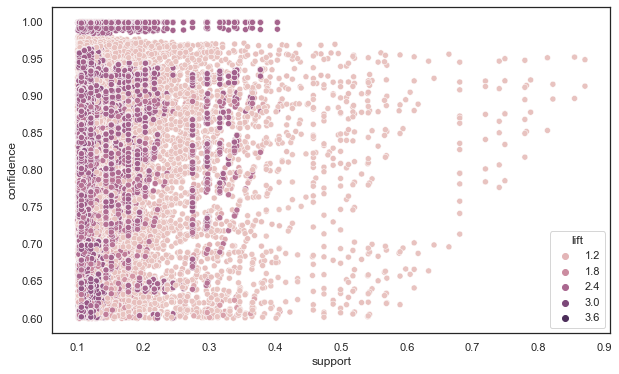

In [618]:
# 성능변수 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x=ar['support'], y=ar['confidence'], hue=ar['lift'])
plt.show()

In [619]:
import networkx as nx

In [620]:
### Visualize network
def draw_graph(rules, rules_to_show):
    G1 = nx.DiGraph()
   
    color_map = []
    colors = np.random.rand(rules_to_show)    
    strs = ["R"+str(i+1) for i in range(rules_to_show + 2)]
   
    for i in range (rules_to_show):      
        G1.add_nodes_from(["R"+str(i)])
     
        for a in rules.iloc[i]['antecedents']:
            G1.add_nodes_from([a])
            G1.add_edge(a, "R"+str(i), color=colors[i] , weight=2)
       
        for c in rules.iloc[i]['consequents']:
            G1.add_nodes_from([])
            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)
 
    for node in G1:
        found_a_string = False
        for item in strs: 
            if node==item:
                found_a_string = True
        if found_a_string:
            color_map.append('yellow')
        else:
            color_map.append('green')       

    edges = G1.edges()
    
    colors = [G1[u][v]['color'] for u,v in edges]
    weights = [G1[u][v]['weight'] for u,v in edges]
    print(len(colors))
    pos = nx.spring_layout(G1, k=16, scale=1)
    nx.draw(G1, pos, node_color = color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)            
   
    for p in pos:  # raise text positions
        pos[p][1] += 0.07
    nx.draw_networkx_labels(G1, pos)
    plt.show()

20


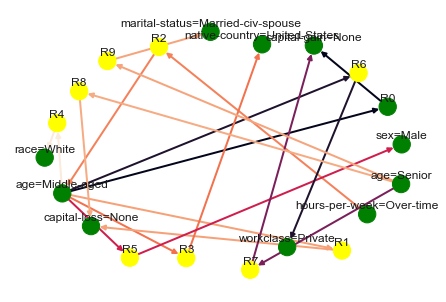

In [621]:
draw_graph(ar, 10)

## Bayesian Analysis
- 관측값을 통해 모델의 확률분포(파라미터)를 업데이트하는 추론

### (1) Markov Chain
- Markov property
- 다음 상태의 사건이 발생할 확률 정의
- 각 이벤트의 확률은 이전 상태에만 영향을 받음

In [100]:
# The statespace
states = ["Sleep", "Icecream", "Run"]

# Possible sequences of events
transition_name = [["SS", "SR", "SI"],["RS", "RR", "RI"],["IS", "IR", "II"]]

# Probabilities matrix (transition matrix)
transition_matrix = [[0.2, 0.6, 0.2], [0.1, 0.6, 0.3], [0.2, 0.7, 0.1]]

In [101]:
# 확률의 합은 1 미만이어야 함
if sum(transition_matrix[0]) + sum(transition_matrix[1]) + sum(transition_matrix[2]) != 3:
    print("Somewhere, something went wrong. Transition matrix, perhaps?")
else: print("All is gonna be okay, you should move on!! ;)")

All is gonna be okay, you should move on!! ;)


In [102]:
# A function that implements the Markov model to forecast the state/mood.
def activity_forecast(days):
    # Choose the starting state
    activity_today = "Sleep"
    print("Start state: " + activity_today)
    
    # Shall store the sequence of states taken. So, this only has the starting state for now.
    activity_list = [activity_today]
    i = 0
    # To calculate the probability of the activityList
    prob = 1
    while i != days:
        if activity_today == "Sleep":
            change = np.random.choice(transition_name[0], replace=True, p=transition_matrix[0])
            if change == "SS":
                prob = prob * 0.2
                activity_list.append("Sleep")
                pass
            elif change == "SR":
                prob = prob * 0.6
                activity_today = "Run"
                activity_list.append("Run")
            else:
                prob = prob * 0.2
                activity_today = "Icecream"
                activity_list.append("Icecream")
        elif activity_today == "Run":
            change = np.random.choice(transition_name[1],replace=True, p=transition_matrix[1])
            if change == "RR":
                prob = prob * 0.5
                activity_list.append("Run")
                pass
            elif change == "RS":
                prob = prob * 0.2
                activity_today = "Sleep"
                activity_list.append("Sleep")
            else:
                prob = prob * 0.3
                activity_today = "Icecream"
                activity_list.append("Icecream")
        elif activity_today == "Icecream":
            change = np.random.choice(transition_name[2], replace=True, p=transition_matrix[2])
            if change == "II":
                prob = prob * 0.1
                activity_list.append("Icecream")
                pass
            elif change == "IS":
                prob = prob * 0.2
                activity_today = "Sleep"
                activity_list.append("Sleep")
            else:
                prob = prob * 0.7
                activity_today = "Run"
                activity_list.append("Run")
        i += 1 
    print("Possible states: " + str(activity_list))
    print("End state after "+ str(days) + " days: " + activity_today)
    print("Probability of the possible sequence of states: " + str(prob))

    return activity_list

# Function that forecasts the possible state for the next 2 days
activity_forecast(2)

Start state: Sleep
Possible states: ['Sleep', 'Run', 'Run']
End state after 2 days: Run
Probability of the possible sequence of states: 0.3


['Sleep', 'Run', 'Run']

In [103]:
# To save every activityList
list_activity = []
count = 0

# `Range` starts from the first count up until but excluding the last count
for iterations in range(1, 10):
    list_activity.append(activity_forecast(2))


# Iterate through the list to get a count of all activities ending in state:'Run'
for smaller_list in list_activity:
    if(smaller_list[2] == "Run"):
        count += 1

# Calculate the probability of starting from state:'Sleep' and ending at state:'Run'
percentage = (count/10000) * 100
print("The probability of starting at state:'Sleep' and ending at state:'Run'= " + str(percentage) + "%")

Start state: Sleep
Possible states: ['Sleep', 'Run', 'Run']
End state after 2 days: Run
Probability of the possible sequence of states: 0.3
Start state: Sleep
Possible states: ['Sleep', 'Run', 'Run']
End state after 2 days: Run
Probability of the possible sequence of states: 0.3
Start state: Sleep
Possible states: ['Sleep', 'Run', 'Run']
End state after 2 days: Run
Probability of the possible sequence of states: 0.3
Start state: Sleep
Possible states: ['Sleep', 'Run', 'Run']
End state after 2 days: Run
Probability of the possible sequence of states: 0.3
Start state: Sleep
Possible states: ['Sleep', 'Run', 'Run']
End state after 2 days: Run
Probability of the possible sequence of states: 0.3
Start state: Sleep
Possible states: ['Sleep', 'Run', 'Run']
End state after 2 days: Run
Probability of the possible sequence of states: 0.3
Start state: Sleep
Possible states: ['Sleep', 'Run', 'Icecream']
End state after 2 days: Icecream
Probability of the possible sequence of states: 0.18
Start sta

### (2) Hidden Markov Model
- 독립 혼합 모형에서 연속 확률 분포를 선택하는 이산 확률 과정 𝐶𝑡가 Markov Chain이고 연속 확률 분포𝑋𝑡 가 그 시점의 이산 확률 과정의 값에만 의존하는 모형
- 연속 확률 분포의 값 𝑋𝑡 만 측정 가능하고 이산 확률 과정의 값 𝐶𝑡 는 측정할 수 없음
- 독립 혼합 모형(Independent Mixuture Model)
    - 연속 확률 변수이지만 단일한 확률 분포를 가지지 않고 복수의 연속 확률 분포 중 하나를 확률적으로 선택하는 모형
    - ex. 베르누이-정규 혼합 모형(Bernoulli Normal-Mixuture Model)은 베르누이 확률 변수의 값에 따라 두 개의 서로 다른 연속 정규 분포 중 하나를 선택하는 확률 분포

In [104]:
# !pip install hmmlearn
from hmmlearn import hmm

In [105]:
# 베르누이 - 정규분포
model = hmm.GaussianHMM(n_components=2, covariance_type="diag")
model.startprob_ = np.array([0.9, 0.1])
model.transmat_ = np.array([[0.95, 0.05], [0.15, 0.85]])
model.means_ = np.array([[1.0], [-3.0]])
model.covars_ = np.array([[15.0], [40.0]])
X, Z = model.sample(500)

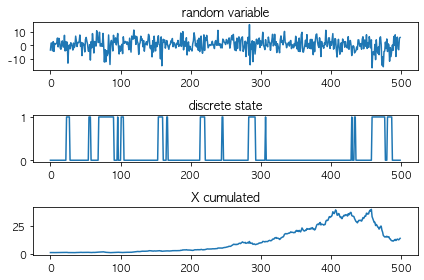

In [106]:
plt.subplot(311)
plt.plot(X)
plt.title("random variable")
plt.subplot(312)
plt.plot(Z)
plt.title("discrete state")
plt.subplot(313)
plt.plot((1 + 0.01*X).cumprod())
plt.title("X cumulated")
plt.tight_layout()
plt.show()

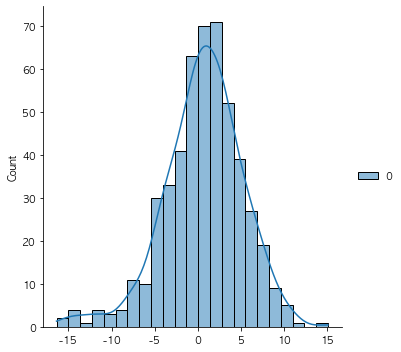

In [107]:
sns.displot(X, kde=True)
plt.show()

In [108]:
### Decode
# 관측된 히든 마코프 모형의 연속 확률 변수 값으로부터 내부의 이산 확률 변수 값을 추정하는 과정
model2 = hmm.GaussianHMM(n_components=2, n_iter=len(X)).fit(X)
model2

GaussianHMM(n_components=2, n_iter=500)

In [109]:
Z_hat = model2.decode(X)[1]
X_cum = (1 + 0.01*X).cumprod()
X_cum_hat = X_cum.copy()
X_cum_hat[Z_hat == 0] = np.nan

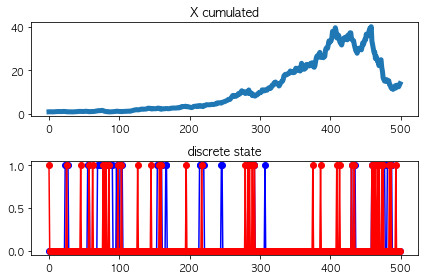

In [110]:
plt.subplot(211)
plt.plot(X_cum, lw=5)
plt.plot(X_cum_hat, 'r-', lw=5)
plt.title("X cumulated")
plt.subplot(212)
plt.plot(Z, 'bo-')
plt.plot(Z_hat, 'ro-')
plt.title("discrete state")
plt.tight_layout()
plt.show()

### (3) MCMC (Markov Chain Monte Carlo)
- Markov Chain을 이용하는 표본 생성 방법
- 어떤 상태가 끊임없이 움직이고 있는 체인 상태의 샘플링
- Markov Chain인의 수렴분포가 원하는 분포 𝑝(𝑥)가 되도록 하는 마코프 체인을 만들고 이 마코프 체인을 𝑡′시간 이상 가동하면 그 다음부터는 원하는 분포의 표본을 얻을 수 있음
- Metropolis-Hastings(MH) 알고리즘
    - 사전분포를 제안하고, 현재 샘플링 파라미터 θt가 다음 샘플 θnew 로 전이될 확률을 사후확률의 비로 결정
- 수행 단계
    - 현재 위치에서 시작한다
    - 새로 이동할 위치를 조사한다 → 주변의 sample을 조사
    - 데이터와 사전확률분포에 따른 위치를 바탕으로 새로운 위치를 수용하거나 기각한다 → sample이 해당 사후확률분포에서 나올 가능성을 조사
    - 수용한다면 새로운 위치로 이동하고 1단계로 돌아간다.

In [111]:
# !pip install pymc3
import pymc3 as pm

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


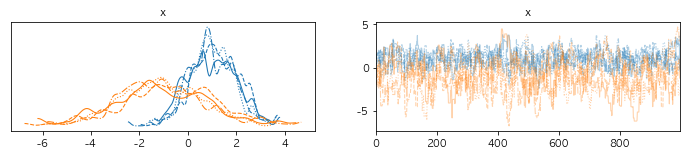

In [112]:
# 2차원 정규분포 표본 생성
cov = np.array([[1., 1.5], [1.5, 4]])
mu = np.array([1, -1])

with pm.Model() as model:
    x = pm.MvNormal('x', mu=mu, cov=cov, shape=(1, 2))
    step = pm.Metropolis()
    trace = pm.sample(1000, step)

pm.traceplot(trace)
plt.show()

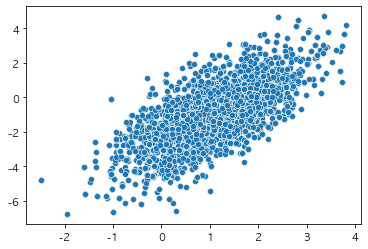

In [113]:
sns.scatterplot(x=trace['x'][:, 0, 0], y=trace['x'][:, 0, 1])
plt.show()

In [114]:
### Baysian Estimation
# 𝑃(𝜃): Beta - 사전분포
# 𝑃(𝑥1,…,𝑥𝑁∣𝜃): Binomial - 사후분포
theta0 = 0.7
np.random.seed(0)
x_data1 = stats.bernoulli(theta0).rvs(10) # 10개의 베르누이 표본
x_data1

array([1, 0, 1, 1, 1, 1, 1, 0, 0, 1])

In [115]:
with pm.Model() as model:
    theta = pm.Beta('theta', alpha=1, beta=1) # Beta dist
    x = pm.Bernoulli('x', p=theta, observed=x_data1)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace1 = pm.sample(2000, step=step, start=start)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


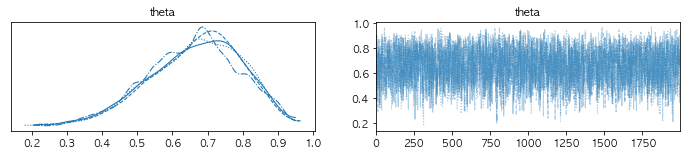

In [116]:
pm.traceplot(trace1)
plt.show()

Got error No model on context stack. trying to find log_likelihood in translation.


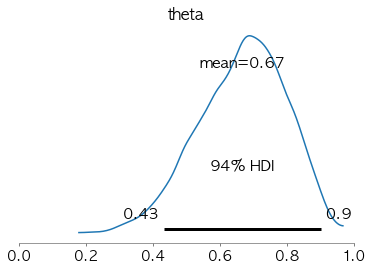

In [117]:
pm.plot_posterior(trace1)
plt.xlim(0, 1)
plt.show()

In [118]:
pm.summary(trace1)

Got error No model on context stack. trying to find log_likelihood in translation.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.665  0.131   0.431    0.903      0.002    0.002    3484.0    4822.0   

       r_hat  
theta    1.0

In [119]:
x_data2 = stats.bernoulli(theta0).rvs(500) # 500개의 베르누이 표본

In [120]:
with pm.Model() as model:
    theta = pm.Beta('theta', alpha=1, beta=1)
    x = pm.Bernoulli('x', p=theta, observed=x_data2)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace2 = pm.sample(1000, step=step, start=start)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


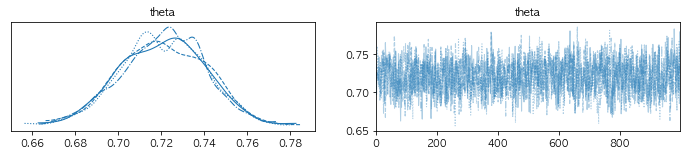

In [121]:
pm.traceplot(trace2)
plt.show()

Got error No model on context stack. trying to find log_likelihood in translation.


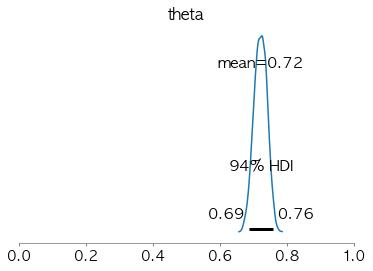

In [122]:
pm.plot_posterior(trace2)
plt.xlim(0, 1)
plt.show()

In [123]:
pm.summary(trace2)

Got error No model on context stack. trying to find log_likelihood in translation.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.721  0.02   0.685    0.758        0.0      0.0    1654.0    2839.0   

       r_hat  
theta    1.0

## Time-Series Analysis
- 시간에 흐름에 따른 데이터 분석
- 미래의 변화에 대한 추세 분석
- 정상성
    - 평균이 일정
    - 분산이 시점과 독립
    - 공분산은 시차에만 의존
- Log transformation(분산 변동폭 제거), Differencing(추세와 계절성 제거)

### (1) ARIMA
- AR(Autoregressive): 현 시점의 자료가 p 시점 전의 유한개의 과거 자료로 설명됨. AR(p)
- MA(Moving Average): 현 시점의 자료를 백색잡음의 선형결함으로 표현하며, 항상 정상성이 만족됨. MA(q)
- AR 모형은 ACF가 연속적인 (감소) 형태, PACF가 p+1 시차에서 절단된 형태
- MA 모형은 PACF가 연속적인 형태, ACF가 p+1 시차에서 절단된 형태

In [622]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [623]:
arima_data = pd.read_csv('./ADP_book_ver01/data/arima_data.csv', names=['day', 'price'])
arima_data.head()

day  price
0  2013-01-01   3794
1  2013-02-01   3863
2  2013-03-01   5190
3  2013-04-01   5783
4  2013-05-01   6298

In [624]:
arima_data['day'] = pd.to_datetime(arima_data['day'], format="%Y-%m-%d")
arima_data.set_index('day', inplace=True)
arima_data.head(3)

price
day              
2013-01-01   3794
2013-02-01   3863
2013-03-01   5190

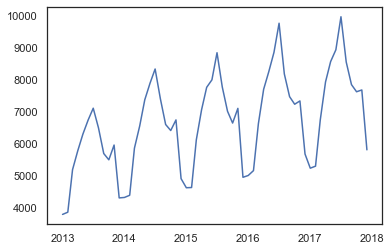

In [625]:
plt.plot(arima_data.index, arima_data['price'])
plt.show()

In [626]:
# Train, Test 데이터 구분
training = arima_data[:"2016-12-01"]
test = arima_data.drop(training.index)

귀무가설(H0) <br>
데이터가 정상성을 갖지 않는다.<br>
대립가설(H1)<br>
데이터가 정상성을 갖는다.<br>

In [627]:
### 정상성 검정
adf = adfuller(training, regression='ct')
print('ADF Statistic: {}'.format(adf[0]))
print('p-value : {}'.format(adf[1]))

ADF Statistic: -1.9997199341327438
p-value : 0.6015863303794374


<AxesSubplot:xlabel='day'>

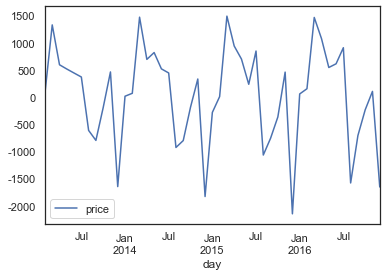

In [628]:
### 차분 실행
diff_data = training.diff(1)
diff_data = diff_data.dropna()
diff_data.plot()

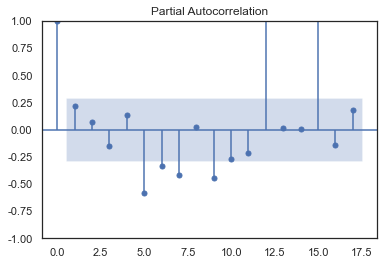

In [629]:
plot_pacf(diff_data) # AR(p)의 값 확인 가능?
plt.show()

In [630]:
from statsmodels.tsa.arima.model import ARIMA

In [631]:
model = ARIMA(training, order=(2, 1, 2))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                   48
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -375.875
Date:                Thu, 31 Aug 2023   AIC                            761.750
Time:                        12:55:19   BIC                            771.000
Sample:                    01-01-2013   HQIC                           765.231
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3168      0.189     -6.970      0.000      -1.687      -0.947
ar.L2         -0.3192      0.190     -1.683      0.092      -0.691       0.053
ma.L1          1.9711      0.241      8.195      0.000       1.500       2.443
ma.L2          0.9961      0.239      4.168      0.000       0.528       1.465
sigma2      4.447e+05   1.11e-06      4e+11      0.000    4.45e+05    4.45e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.38
Prob(Q):                              0.74   Prob(JB):                         0.83
Heteroskedasticity (H):               1.49   Skew:                            -0.21
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.82e+26. Standard errors may be unstable.
"""

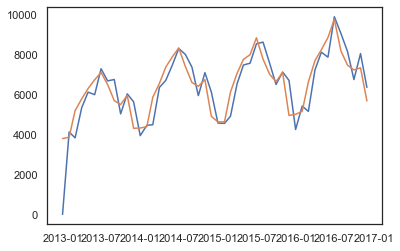

In [632]:
plt.plot(res.predict())
plt.plot(training)

In [633]:
# 학습 데이터셋으로부터 test 데이터 길이만큼 예측합니다.
forecast_data = res.forecast(steps=len(test), alpha=0.05) 

pred_y = forecast_data
pred_y

2017-01-01    5830.868987
2017-02-01    5508.634583
2017-03-01    5884.167944
2017-04-01    5492.512278
2017-05-01    5888.384640
2017-06-01    5492.106038
2017-07-01    5887.573563
2017-08-01    5493.303775
2017-09-01    5886.255241
2017-10-01    5494.657460
2017-11-01    5884.893482
2017-12-01    5496.018563
Freq: MS, Name: predicted_mean, dtype: float64

In [634]:
test_y = test # 실제 데이터
test_y

price
day              
2017-01-01   5236
2017-02-01   5299
2017-03-01   6744
2017-04-01   7927
2017-05-01   8561
2017-06-01   8930
2017-07-01   9960
2017-08-01   8548
2017-09-01   7843
2017-10-01   7620
2017-11-01   7676
2017-12-01   5809

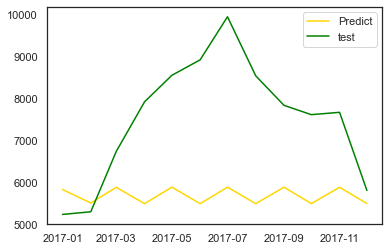

In [635]:
plt.plot(pred_y, color="gold", label='Predict') # 모델이 예상한 가격 그래프
plt.plot(test_y, color="green" , label='test') # 실제 가격 그래프
plt.legend()
plt.show()

In [636]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [637]:
print("r2_score : ", r2_score(test_y, pred_y))
RMSE = mean_squared_error(test_y, pred_y)**0.5
print("RMSE : " , RMSE)

r2_score :  -1.6425726376790446
RMSE :  2302.0574524839035


In [638]:
### Nile강 data
nile = pd.read_csv('./r_csv/datasets/Nile.csv').drop('Unnamed: 0', axis=1)
nile.set_index('time', inplace=True)
nile.head()

value
time       
1871   1120
1872   1160
1873    963
1874   1210
1875   1160

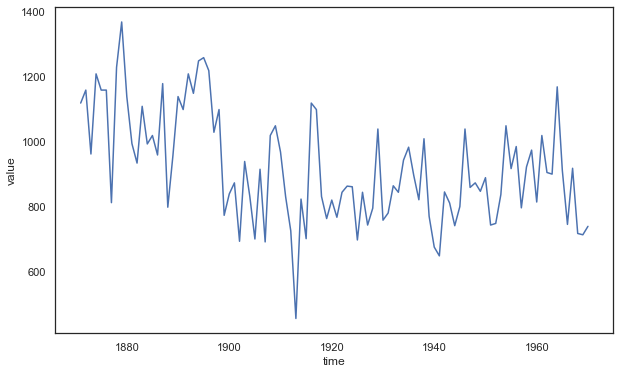

In [639]:
plt.figure(figsize=(10,6))
sns.lineplot(x='time', y='value', data=nile)
plt.show()

In [640]:
### 정상성 검정 -> 만족
adf = adfuller(nile, regression='ct')
print('ADF Statistic: {}'.format(adf[0]))
print('p-value : {}'.format(adf[1]))

ADF Statistic: -4.7907655179831234
p-value : 0.0004861430290081328


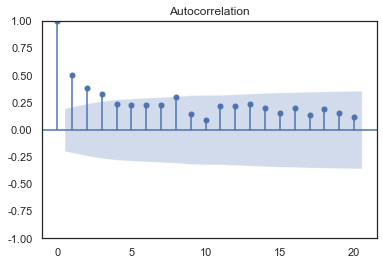

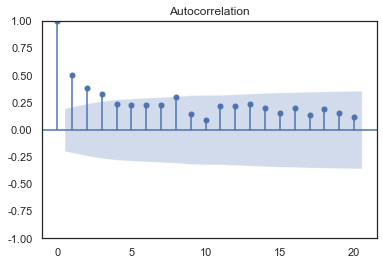

In [641]:
plot_acf(nile) # MA(q)의 값 확인 가능?

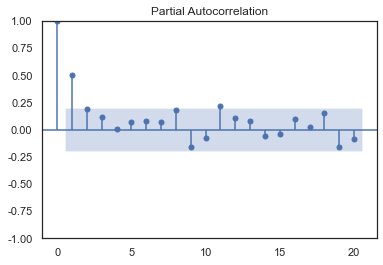

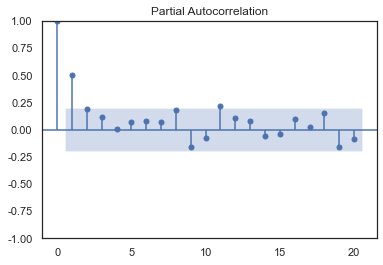

In [642]:
plot_pacf(nile) # AR(p)의 값 확인 가능?

In [643]:
model = ARIMA(nile, order=(2, 0, 1))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -636.269
Date:                Thu, 31 Aug 2023   AIC                           1282.538
Time:                        12:55:22   BIC                           1295.564
Sample:                             0   HQIC                          1287.810
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        934.4066     77.600     12.041      0.000     782.314    1086.499
ar.L1          1.2100      0.151      8.000      0.000       0.914       1.507
ar.L2         -0.2359      0.133     -1.773      0.076      -0.497       0.025
ma.L1         -0.8431      0.102     -8.287      0.000      -1.043      -0.644
sigma2      1.954e+04   3019.272      6.473      0.000    1.36e+04    2.55e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.23
Prob(Q):                              0.84   Prob(JB):                         0.89
Heteroskedasticity (H):               0.61   Skew:                            -0.02
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [644]:
forecast_data = res.forecast(steps=10, alpha=0.05) 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: DeprecationWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [645]:
pred_y = forecast_data
pred_y.index = range(1971, 1981) # index 조정

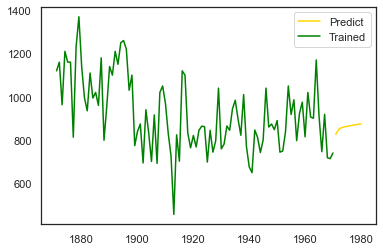

In [646]:
plt.plot(pred_y, color="gold", label='Predict') # 모델이 예상한 가격 그래프
plt.plot(nile['value'], color="green" , label='Trained') # 실제 가격 그래프
plt.legend()
plt.show()

In [647]:
### air passengers data
data = pd.read_csv('./data/AirPassengers.csv')
data = data.rename(columns = {'Month':'month', '#Passengers':'passengers'})
data['month'] = pd.to_datetime(data['month'])
data = data.set_index('month') ### 시간 컬럼을 인덱스로 만들어줌
data.head()

passengers
month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121

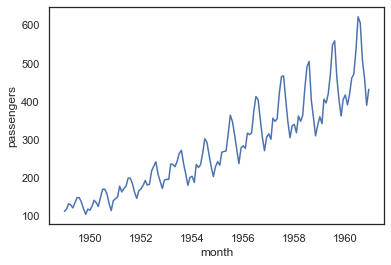

In [648]:
sns.lineplot(x=data.index, y='passengers', data=data)
plt.show()

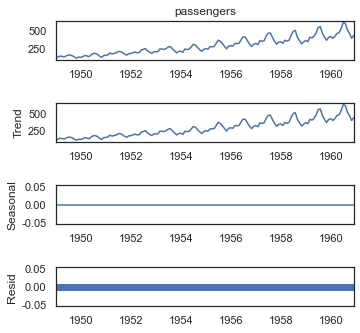

In [649]:
decomposition = sm.tsa.seasonal_decompose(data['passengers'], model = 'additive', period=1)
fig = decomposition.plot()
fig.set_size_inches(5, 5)
plt.show()

In [650]:
from sklearn.model_selection import train_test_split

In [651]:
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

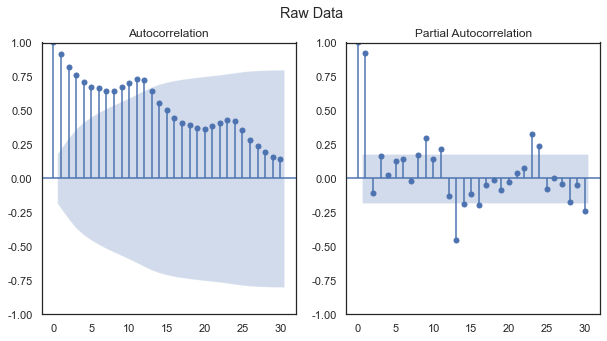

In [652]:
# ACF, PACF plot
fig, ax = plt.subplots(1,2, figsize = (10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags = 30, ax = ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags = 30, ax = ax[1])
plt.show()
### ACF 그래프가 점진적으로 감소하는 것은 전형적인 Non-stationary 데이터이다 = 정상성이 없음

In [653]:
# Differencing
diff_train_data = train_data.copy()
diff_train_data = diff_train_data['passengers'].diff()
diff_train_data = diff_train_data.dropna()

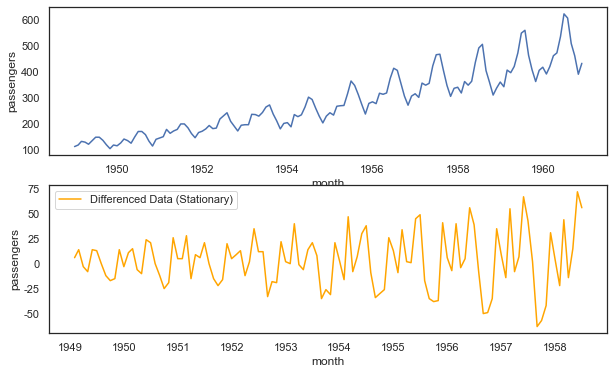

In [654]:
# differenced data plot
plt.figure(figsize = (10, 6))
plt.subplot(211)
sns.lineplot(x=data.index, y='passengers', data=data)
plt.subplot(212)
sns.lineplot(x=diff_train_data.index, y=diff_train_data, color='orange')
plt.legend(['Differenced Data (Stationary)'])
plt.show()

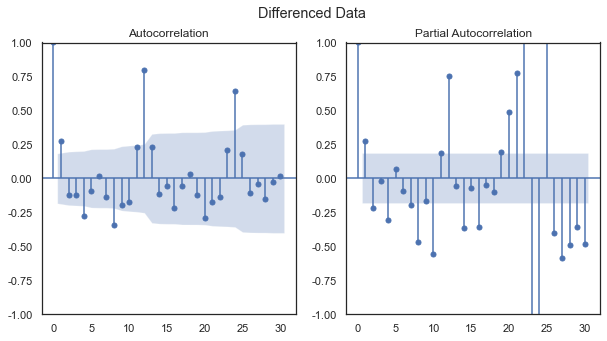

In [655]:
# ACF, PACF plot
# ACF는 sin 곡선의 형태로 점차 감소한다고 보이고, PACF는 애매하지만 Lag 1 이후 절단면을 가지는 것으로 판단하여 AR(1) 모델을 선택함
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Differenced Data')
plot_acf(diff_train_data.values.squeeze(), lags = 30, ax = ax[0])
plot_pacf(diff_train_data.values.squeeze(), lags = 30, ax = ax[1])
plt.show()

In [656]:
# ARIMA model fitting
# The (p, d, q) order of the model for the number of AR parameters, differences, and MA parameters to use.
model = ARIMA(train_data.values, order=(1, 1, 0))
model_fit = model.fit()
model_fit.summary()

# AIC 값은 1068.54

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -532.268
Date:                Thu, 31 Aug 2023   AIC                           1068.536
Time:                        12:55:26   BIC                           1074.008
Sample:                             0   HQIC                          1070.757
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2904      0.089      3.278      0.001       0.117       0.464
sigma2       664.7320     89.253      7.448      0.000     489.800     839.664
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                 3.25
Prob(Q):                              0.57   Prob(JB):                         0.20
Heteroskedasticity (H):               6.18   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [657]:
# Parameter search
print('Examples of parameter combinations for ARIMA...')
p = range(0, 3)
d = range(1, 2)
q = range(0, 3)

pdq = list(itertools.product(p, d, q))
pdq

Examples of parameter combinations for ARIMA...


[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2)]

In [658]:
aic=[]
for i in pdq:
    model = ARIMA(train_data.values, order=(i))
    model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC : {round(model_fit.aic, 2)}')
    aic.append(round(model_fit.aic,2))

# Search optimal parameters
optimal = [(pdq[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

ARIMA: (0, 1, 0) >> AIC : 1076.27
ARIMA: (0, 1, 1) >> AIC : 1063.65
ARIMA: (0, 1, 2) >> AIC : 1060.69
ARIMA: (1, 1, 0) >> AIC : 1068.54
ARIMA: (1, 1, 1) >> AIC : 1058.25
ARIMA: (1, 1, 2) >> AIC : 1057.33
ARIMA: (2, 1, 0) >> AIC : 1065.64
ARIMA: (2, 1, 1) >> AIC : 1058.65
ARIMA: (2, 1, 2) >> AIC : 1057.52


[((1, 1, 2), 1057.33)]

In [659]:
# 위 최적 값으로 만든 모델 다시 Summary
model_opt = ARIMA(train_data.values, order = optimal[0][0])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

# AIC score가 1057.33으로 임의의 모델보다 성능이 좋아졌고, p-value도 모두 유의미하게 나옴

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -524.664
Date:                Thu, 31 Aug 2023   AIC                           1057.328
Time:                        12:55:26   BIC                           1068.272
Sample:                             0   HQIC                          1061.769
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5387      0.128      4.219      0.000       0.288       0.789
ma.L1         -0.2053      0.122     -1.688      0.091      -0.444       0.033
ma.L2         -0.5606      0.084     -6.647      0.000      -0.726      -0.395
sigma2       578.5728    105.827      5.467      0.000     371.155     785.991
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):                 4.81
Prob(Q):                              0.47   Prob(JB):                         0.09
Heteroskedasticity (H):               5.54   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [660]:
### Model for predict
prediction = model_opt_fit.forecast(steps=len(test_data), alpha=0.05)
predicted_value = prediction[0]

In [661]:
from sklearn.metrics import r2_score

In [662]:
prediction = model_opt_fit.forecast(len(test_data))
predicted_value = prediction[0]
predict_index = list(test_data.index)

r2 = r2_score(test_data, prediction)

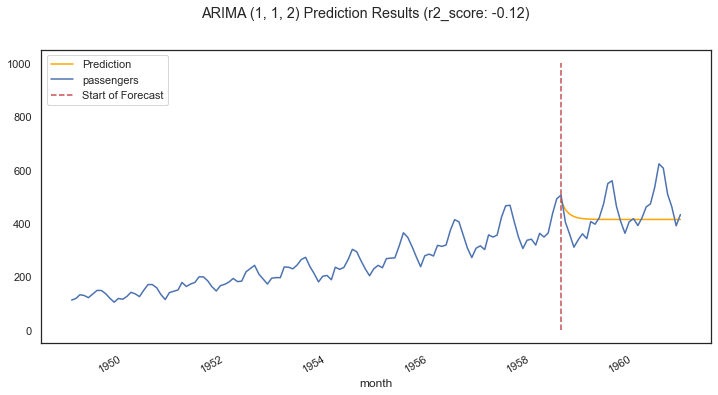

In [663]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(predict_index, prediction, color = 'orange', label = 'Prediction') # 예측값(위 vline 이후 구간에 표시됨)

data.plot(ax = ax);
ax.vlines('1958-08-01', 0, 1000, linestyle = '--', color = 'r', label = 'Start of Forecast') # x좌표를 날짜로 적음
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {optimal[0][0]} Prediction Results (r2_score: {round(r2,2)})')

plt.show()

# 빨간 점선 이후의 주황색 선이 예측값
# 대체로 추세를 따라가나 피크 값을 완벽히 예측하기에는 다소 무리가 있는 것을 볼 수 있다.
# R2 score도 마이너스인 것을 확인할 수 있었다.

### (2) SARIMA
- Seasonal ARIMA
- 총 7개의 파라미터 존재. trend에 대한 부분(p, d, q)과 seasonal에 대한 부분(P, D, Q, m)
    - trend 파라미터는 ARIMA와 동일
    - P: pacf에서 계절성이 주기가 몇 번 반복 됐는지 확인
    - D: 계절성이 있는지 확인하고 계절성 차분의 필요성에 따라 1 or 0
    - Q: acf기준 계절성 주기가 몇 번 반복 됐는지 확인
    - m: 계절성 주기
- 모델 검증
    - Ljung-Box(L1): 잔차가 white noise를 따르는지 확인
        - 귀무가설: 잔차가 white noise를 따른다
        - p-value가 낮으면 white noise를 따르지 않고 시간대 별 잔차가 corrleated 되어 있는 것으로 판단
    - Jarque-Bera : 잔차의 정규성 판단
        - 귀무가설: 잔차가 normal distribution을 따른다
    - Heteroskedasticity: 각 시간대 별 잔차의 분산이 일정한지 확인
        - 귀무가설: 잔차의 분산이 일정하다

In [664]:
# !pip install pmdarima
from pmdarima import auto_arima

In [665]:
auto_model = auto_arima(training, start_p=0, d=1, start_q=0,
                        max_p=3, max_q=3, 
                        start_P=0, start_Q=0,
                        max_P=3, max_Q=3, m=12,
                        seasonal=True, information_criterion='aic',
                        trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=481.846, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=482.652, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=482.466, Time=0.13 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=483.637, Time=0.08 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=483.669, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=481.031, Time=0.06 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=482.740, Time=0.16 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=482.616, Time=0.07 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=482.682, Time=0.11 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=480.687, Time=0.05 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=482.403, Time=0.13 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=48

In [666]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -238.344
Date:                             Thu, 31 Aug 2023   AIC                            480.687
Time:                                     12:55:30   BIC                            483.798
Sample:                                 01-01-2013   HQIC                           481.761
                                      - 12-01-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3185      0.177     -1.801      0.072      -0.665       0.028
sigma2      4.803e+04   1.64e+04      2.924      0.003    1.58e+04    8.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.15
Prob(Q):                              0.95   Prob(JB):                         0.56
Heteroskedasticity (H):               1.56   Skew:                            -0.14
Prob(H) (two-sided):                  0.45   Kurtosis:                         2.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [667]:
# 학습 데이터셋으로부터 test 데이터 길이만큼 예측
auto_pred_y = pd.DataFrame(auto_model.predict(n_periods=len(test)), index=test.index) 
auto_pred_y.columns = ['predicted_price']
auto_pred_y

predicted_price
day                        
2017-01-01      5609.436979
2017-02-01      5761.436979
2017-03-01      7225.436979
2017-04-01      8298.436979
2017-05-01      8841.436979
2017-06-01      9452.436979
2017-07-01     10359.436979
2017-08-01      8777.436979
2017-09-01      8068.436979
2017-10-01      7832.436979
2017-11-01      7935.436979
2017-12-01      6279.436979

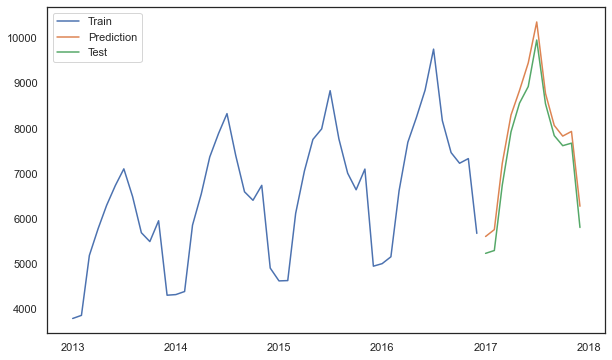

In [668]:
plt.figure(figsize=(10,6))
plt.plot(training, label="Train") # Train 데이터 
plt.plot(auto_pred_y, label="Prediction") # 모델이 예상한 그래프 
plt.plot(test, label="Test") # 실제 가격 그래프 
plt.legend(loc='upper left')
plt.show()

In [669]:
print("r2_score : ", r2_score(test_y, auto_pred_y))
RMSE = mean_squared_error(test_y, auto_pred_y)**0.5
print("RMSE : " , RMSE)

r2_score :  0.9305467061841242
RMSE :  373.2064274724195


In [ ]:
### air passengers data
auto_arima_model = auto_arima(train_data, start_p=1, start_q=1, # p, q 시작값
                             max_p=3, max_q=3, # p, q 최대값
                             m=12, seasonal=True, # 계절성 있는지와 구간(True = SARIMA) / 계절성 없다고 생각되면 m빼고, False
                             d=1, D=1, # 차분 최소, 최대
                             max_P=3, max_Q=3, # P, Q 최대  ## start_P, start_Q의 default 값은 1이라 생략했음
                             trace=True,  # 각 결과값은 print 해줌
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=False)

In [671]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                          y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -370.278
Date:                                    Thu, 31 Aug 2023   AIC                            752.557
Time:                                            12:57:00   BIC                            768.307
Sample:                                        01-01-1949   HQIC                           758.934
                                             - 07-01-1958                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2218      0.093     -2.388      0.017      -0.404      -0.040
ar.S.L12       0.9288      0.275      3.374      0.001       0.389       1.468
ma.S.L12      -1.2065      0.448     -2.692      0.007      -2.085      -0.328
ma.S.L24       0.2771      0.174      1.596      0.111      -0.063       0.618
ma.S.L36       0.1251      0.164      0.765      0.444      -0.195       0.446
sigma2        75.0386     19.073      3.934      0.000      37.656     112.421
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.50
Prob(Q):                              0.91   Prob(JB):                         0.29
Heteroskedasticity (H):               1.05   Skew:                             0.37
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [672]:
prediction = auto_arima_model.predict(len(test_data), return_conf_int=True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

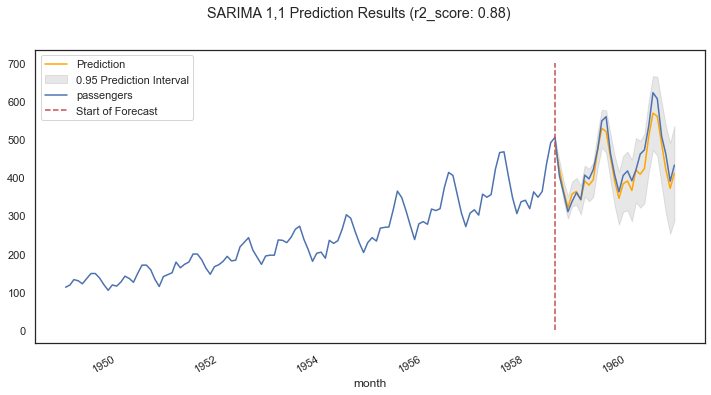

In [673]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(predict_index, predicted_value, color = 'orange', label = 'Prediction') # 예측값(위 vline 이후 구간에 표시됨)
ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label = '0.95 Prediction Interval')

data.plot(ax = ax);
ax.vlines('1958-08-01', 0, 700, linestyle = '--', color = 'r', label = 'Start of Forecast') # x좌표를 날짜로 적음
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {optimal[0][0][0]},{optimal[0][0][1]} Prediction Results (r2_score: {round(r2,2)})')

plt.show()

# 예측 값의 추세가 실제 값을 상당히 잘 따라가고 있으며,
# r2 score가 0.89로 훨씬 더 성능이 향상됨
# 계절성을 반영한 것이 예측 성능을 향상시키는데 기여를 했다고 볼 수 있다.

In [674]:
### J&J data: for native sarima
data = pd.read_csv('./data/jj.csv')
data.head()

date  data
0  1960-01-01  0.71
1  1960-04-01  0.63
2  1960-07-02  0.85
3  1960-10-01  0.44
4  1961-01-01  0.61

ADF Statistic: 2.742016573457476
p-value: 1.0


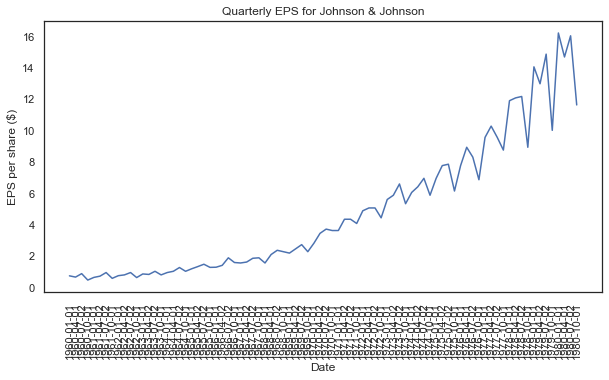

In [675]:
plt.figure(figsize=[10, 5]); # Set dimensions for figure
sns.lineplot(x=data['date'], y=data['data'])
plt.title('Quarterly EPS for Johnson & Johnson')
plt.ylabel('EPS per share ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)# Augmented Dickey-Fuller test

ad_fuller_result = adfuller(data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
plt.show()

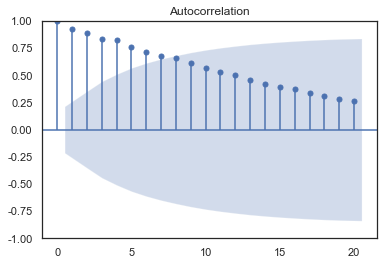

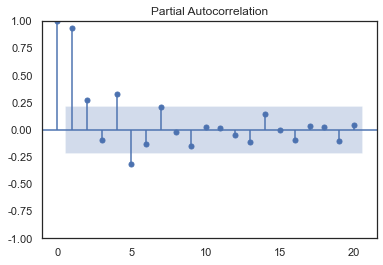

In [676]:
plot_acf(data['data']);
plot_pacf(data['data']);

In [677]:
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.742016573457476
p-value: 1.0


In [678]:
# Take the log difference to make data stationary
data['data'] = np.log(data['data'])
data['data'] = data['data'].diff()
data = data.drop(data.index[0])

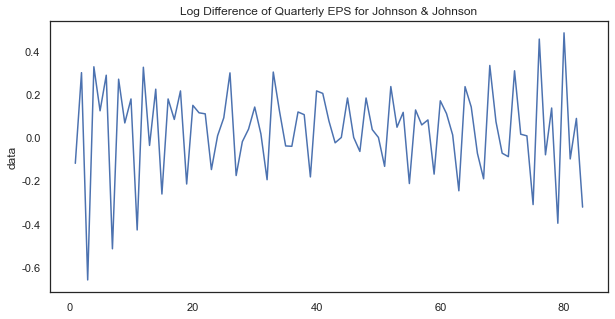

In [679]:
plt.figure(figsize=[10, 5]); # Set dimensions for figure
sns.lineplot(data=data['data'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

In [680]:
# Seasonal differencing
data['data'] = data['data'].diff(4)
data = data.drop([1, 2, 3, 4], axis=0).reset_index(drop=True)
data.head()

date      data
0  1961-04-02  0.242778
1  1961-07-02 -0.011834
2  1961-10-01  0.144006
3  1962-01-01 -0.057351
4  1962-04-02 -0.056093

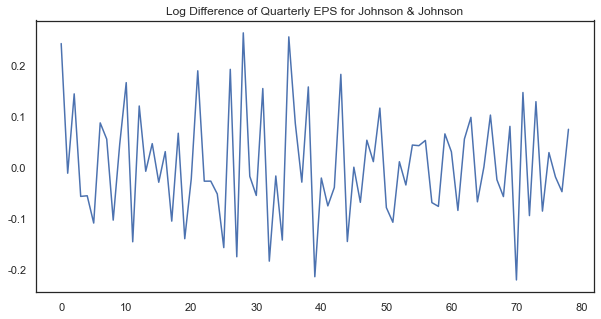

In [681]:
plt.figure(figsize=[10, 5]); # Set dimensions for figure
plt.plot(data['data'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

In [682]:
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.630805109914263
p-value: 5.72157869513621e-09


In [683]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

In [684]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in parameters_list:
        model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        aic = model.aic
        results.append([param, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [685]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [686]:
result_df = optimize_SARIMA(parameters_list, d, D, s, data['data'])

In [687]:
result_df[result_df.AIC==result_df.AIC.min()]

(p,q)x(P,Q)         AIC
0  (0, 2, 0, 2) -114.458756

In [688]:
best_model = SARIMAX(data['data'], order=(0, 2, 0), seasonal_order=(0, 2, 0, 2)).fit(dis=-1)
best_model.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.78376D-01    |proj g|=  1.40740D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3     12      1     0     0   5.704D-05   7.769D-01
  F =  0.77689613546325442     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              data   No. Observations:                   79
Model:             SARIMAX(0, 2, 0)x(0, 2, 0, 2)   Log Likelihood                 -61.375
Date:                           Thu, 31 Aug 2023   AIC                            124.750
Time:                                   12:59:35   BIC                            127.040
Sample:                                        0   HQIC                           125.662
                                            - 79                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.3146      0.063      4.997      0.000       0.191       0.438
===================================================================================
Ljung-Box (L1) (Q):                  14.89   Jarque-Bera (JB):                 1.54
Prob(Q):                              0.00   Prob(JB):                         0.46
Heteroskedasticity (H):               0.64   Skew:                             0.17
Prob(H) (two-sided):                  0.29   Kurtosis:                         2.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [689]:
data

date      data
0   1961-04-02  0.242778
1   1961-07-02 -0.011834
2   1961-10-01  0.144006
3   1962-01-01 -0.057351
4   1962-04-02 -0.056093
..         ...       ...
74  1979-10-01 -0.086260
75  1980-01-01  0.028690
76  1980-04-01 -0.019164
77  1980-07-02 -0.048099
78  1980-10-01  0.074444

[79 rows x 2 columns]

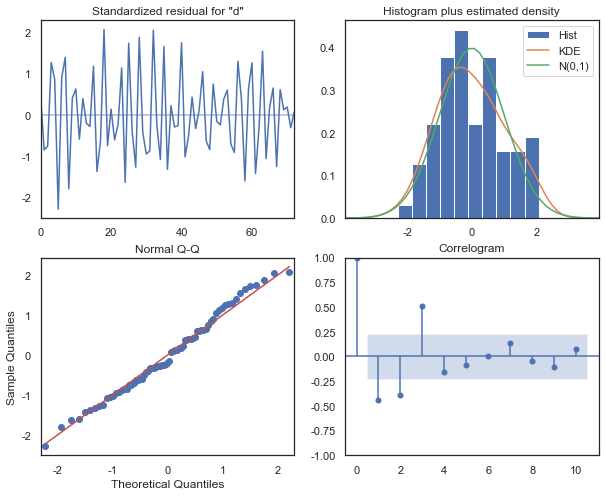

In [690]:
best_model.plot_diagnostics(figsize=(10, 8));

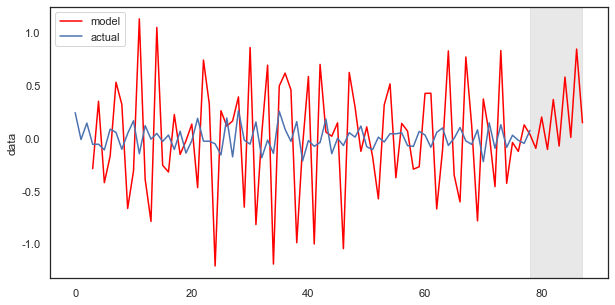

In [691]:
data['arima_model'] = best_model.fittedvalues
data['arima_model'][:2 + 1] = np.NaN # 첫 주기까지(여기서는 2)는 NaN으로 처리하는 듯

forecast = best_model.predict(start=data.shape[0], end=data.shape[0] + 8)
forecast = data['arima_model']._append(forecast)

plt.figure(figsize=(10, 5))
sns.lineplot(data=forecast, color='red', label='model')
plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
sns.lineplot(data=data['data'], label='actual')
plt.legend()
plt.show()

### (3) MARIMA
- Multi-variate ARIMA
- VAR (Vector AR)

In [692]:
air_quality = pd.read_excel('./data/AirQualityUCI.xlsx')
air_quality.head()

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)   C6H6(GT)  \
0 2004-03-10  18:00:00     2.6      1360.00       150  11.881723   
1 2004-03-10  19:00:00     2.0      1292.25       112   9.397165   
2 2004-03-10  20:00:00     2.2      1402.00        88   8.997817   
3 2004-03-10  21:00:00     2.2      1375.50        80   9.228796   
4 2004-03-10  22:00:00     1.6      1272.25        51   6.518224   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0        1045.50    166.0       1056.25    113.0       1692.00      1267.50   
1         954.75    103.0       1173.75     92.0       1558.75       972.25   
2         939.25    131.0       1140.00    114.0       1554.50      1074.00   
3         948.25    172.0       1092.00    122.0       1583.75      1203.25   
4         835.50    131.0       1205.00    116.0       1490.00      1110.00   

       T         RH        AH  
0  13.60  48.875001  0.757754  
1  13.30  47.700000  0.725487  
2  11.90  53.975000  0.750239  
3  11.00  60.000000  0.786713  
4  11.15  59.575001  0.788794

In [693]:
air_quality['Date_Time'] = air_quality['Date'].astype(str) + ' ' + air_quality['Time'].astype(str)

In [694]:
air_quality['Date_Time'] = pd.to_datetime(air_quality.Date_Time , format = '%Y-%m-%d %H:%M:%S')
air_quality.index = air_quality.Date_Time
air_quality = air_quality.drop(['Date_Time', 'Date', 'Time'], axis=1)

In [695]:
air_quality = air_quality.dropna()
air_quality.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         9357 non-null   float64
 1   PT08.S1(CO)    9357 non-null   float64
 2   NMHC(GT)       9357 non-null   int64  
 3   C6H6(GT)       9357 non-null   float64
 4   PT08.S2(NMHC)  9357 non-null   float64
 5   NOx(GT)        9357 non-null   float64
 6   PT08.S3(NOx)   9357 non-null   float64
 7   NO2(GT)        9357 non-null   float64
 8   PT08.S4(NO2)   9357 non-null   float64
 9   PT08.S5(O3)    9357 non-null   float64
 10  T              9357 non-null   float64
 11  RH             9357 non-null   float64
 12  AH             9357 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 1023.4 KB


In [696]:
air_quality.head()

CO(GT)  PT08.S1(CO)  NMHC(GT)   C6H6(GT)  PT08.S2(NMHC)  \
Date_Time                                                                      
2004-03-10 18:00:00     2.6      1360.00       150  11.881723        1045.50   
2004-03-10 19:00:00     2.0      1292.25       112   9.397165         954.75   
2004-03-10 20:00:00     2.2      1402.00        88   8.997817         939.25   
2004-03-10 21:00:00     2.2      1375.50        80   9.228796         948.25   
2004-03-10 22:00:00     1.6      1272.25        51   6.518224         835.50   

                     NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
Date_Time                                                           
2004-03-10 18:00:00    166.0       1056.25    113.0       1692.00   
2004-03-10 19:00:00    103.0       1173.75     92.0       1558.75   
2004-03-10 20:00:00    131.0       1140.00    114.0       1554.50   
2004-03-10 21:00:00    172.0       1092.00    122.0       1583.75   
2004-03-10 22:00:00    131.0       1205.00    116.0       1490.00   

                     PT08.S5(O3)      T         RH        AH  
Date_Time                                                     
2004-03-10 18:00:00      1267.50  13.60  48.875001  0.757754  
2004-03-10 19:00:00       972.25  13.30  47.700000  0.725487  
2004-03-10 20:00:00      1074.00  11.90  53.975000  0.750239  
2004-03-10 21:00:00      1203.25  11.00  60.000000  0.786713  
2004-03-10 22:00:00      1110.00  11.15  59.575001  0.788794

In [697]:
### Granger 인과검정
# VAR 예측을 수행하기 전에 해당 변수들이 모두 상호연관성이 있는가를 확인해줄 필요가 있다.
# Granger 인과검정의 영가설은 X가 Y에 영향을 미치지 않는다 이다. 즉, 검정 결과 p_value가 유의수준 0.05 이하라면 영가설을 기각하고 해당 변수를 예측모델의 인자로 사용하도록 한다.
df_pairs = pd.DataFrame(data=np.zeros((len(air_quality.columns), len(air_quality.columns))),
                        columns = ['X_'+ x for x in air_quality.columns],
                        index = ['Y_'+ x for x in air_quality.columns])

In [698]:
from statsmodels.tsa.stattools import grangercausalitytests

In [ ]:
maxlag = 14
for col_i, col in enumerate(air_quality.columns):
    for idx_i, idx in enumerate(air_quality.columns):
        outs = grangercausalitytests(air_quality[[col,idx]], maxlag=maxlag)
        pval_min = np.min([round(outs[x][0]['ssr_chi2test'][1],2) for x in range(1, maxlag + 1)])
        df_pairs.iloc[idx_i, col_i] = pval_min

In [700]:
df_pairs

X_CO(GT)  X_PT08.S1(CO)  X_NMHC(GT)  X_C6H6(GT)  \
Y_CO(GT)             1.00            0.0        0.00         0.0   
Y_PT08.S1(CO)        0.00            1.0        0.00         0.0   
Y_NMHC(GT)           0.00            0.0        1.00         0.0   
Y_C6H6(GT)           0.00            0.0        0.01         1.0   
Y_PT08.S2(NMHC)      0.00            0.0        0.00         0.0   
Y_NOx(GT)            0.00            0.0        0.00         0.0   
Y_PT08.S3(NOx)       0.00            0.0        0.00         0.0   
Y_NO2(GT)            0.00            0.0        0.00         0.0   
Y_PT08.S4(NO2)       0.00            0.0        0.00         0.0   
Y_PT08.S5(O3)        0.00            0.0        0.00         0.0   
Y_T                  0.02            0.0        0.22         0.0   
Y_RH                 0.13            0.0        0.13         0.0   
Y_AH                 0.08            0.0        0.17         0.0   

                 X_PT08.S2(NMHC)  X_NOx(GT)  X_PT08.S3(NOx)  X_NO2(GT)  \
Y_CO(GT)                    0.00       0.00             0.0        0.0   
Y_PT08.S1(CO)               0.00       0.00             0.0        0.0   
Y_NMHC(GT)                  0.01       0.00             0.0        0.0   
Y_C6H6(GT)                  0.00       0.00             0.0        0.0   
Y_PT08.S2(NMHC)             1.00       0.00             0.0        0.0   
Y_NOx(GT)                   0.00       1.00             0.0        0.0   
Y_PT08.S3(NOx)              0.00       0.00             1.0        0.0   
Y_NO2(GT)                   0.00       0.00             0.0        1.0   
Y_PT08.S4(NO2)              0.00       0.00             0.0        0.0   
Y_PT08.S5(O3)               0.00       0.00             0.0        0.0   
Y_T                         0.00       0.00             0.0        0.0   
Y_RH                        0.00       0.00             0.0        0.0   
Y_AH                        0.00       0.08             0.0        0.1   

                 X_PT08.S4(NO2)  X_PT08.S5(O3)   X_T  X_RH  X_AH  
Y_CO(GT)                    0.0           0.00  0.00   0.0  0.11  
Y_PT08.S1(CO)               0.0           0.00  0.00   0.0  0.25  
Y_NMHC(GT)                  0.0           0.01  0.00   0.0  0.00  
Y_C6H6(GT)                  0.0           0.00  0.00   0.0  0.09  
Y_PT08.S2(NMHC)             0.0           0.00  0.00   0.0  0.13  
Y_NOx(GT)                   0.0           0.00  0.00   0.0  0.06  
Y_PT08.S3(NOx)              0.0           0.00  0.00   0.0  0.21  
Y_NO2(GT)                   0.0           0.00  0.00   0.0  0.21  
Y_PT08.S4(NO2)              1.0           0.00  0.01   0.0  0.44  
Y_PT08.S5(O3)               0.0           1.00  0.00   0.0  0.12  
Y_T                         0.0           0.00  1.00   0.0  0.09  
Y_RH                        0.0           0.00  0.00   1.0  0.10  
Y_AH                        0.0           0.00  0.00   0.0  1.00

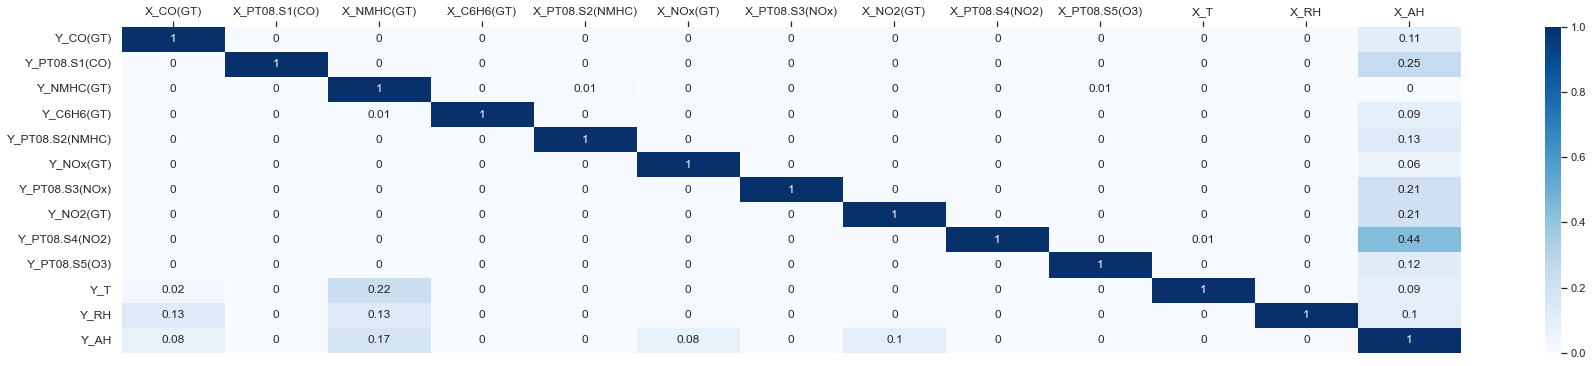

In [701]:
plt.figure(figsize=(30, 6))
ax = sns.heatmap(df_pairs, annot=True, cmap='Blues')
ax.xaxis.tick_top()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [702]:
# 상호 영향이 일부 없는 변수 제거 -> AH, T, RH
air_quality = air_quality.drop(['AH', 'T', 'RH'], axis=1)

In [703]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [704]:
### 공적분 검정(혹은 요한슨 검정)은 다중 시계열 간 적분상 균형관계가 존재하는가를 판단한다.
# 즉, Granger 검정이 단일 시계열보다 다중 시계열로 설명력을 더 얻을수 있는가? 를 확인해주었다면, 
# Cointegration 검정은 다중 시계열이 장기적 기간을 두고 안정적인 연관성을 보이는가? 를 확인해준다.
def calc_sig_dist(cols):
    out = coint_johansen(air_quality[cols], 1, 1)
    stats = [round(x,2) for x in out.lr1]
    sigs = [round(x,2) for x in out.cvt[:, 1]]
    yns = [x>y for x,y in zip(stats,sigs)]
    dist = np.mean(np.array(stats) - np.array(sigs))
    
    print('stats: ',stats)
    print('sig-level: ',sigs)
    print('significant_yn: ',[x>y for x,y in zip(stats,sigs)])
    print('dist: ', round(dist,2))

In [705]:
calc_sig_dist(air_quality.columns)

stats:  [6270.43, 4851.05, 3769.61, 2837.98, 1950.93, 1366.9, 856.81, 548.68, 294.68, 122.83]
sig-level:  [259.03, 215.13, 175.16, 139.28, 107.34, 79.34, 55.25, 35.01, 18.4, 3.84]
significant_yn:  [True, True, True, True, True, True, True, True, True, True]
dist:  2178.21


In [706]:
target_lag = 30

df_train = air_quality.iloc[:-target_lag, :]
df_test = air_quality.iloc[-target_lag:, :]

print(df_train.shape, df_test.shape)

(9327, 10) (30, 10)


In [707]:
### 정상성 확인
# 모든 변수가 정상성 만족
for col in air_quality.columns:
    adf_sample = adfuller(df_train[col], autolag='AIC') # AIC가 가장 낮은 lag(시차)를 자동 선택
    print(col, adf_sample)

CO(GT) (-9.54119871701311, 2.723730091306091e-16, 28, 9298, {'1%': -3.43105349604789, '5%': -2.8618509008205946, '10%': -2.566935487428262}, 91943.79062877542)
PT08.S1(CO) (-10.661045851202164, 4.406450662947555e-19, 36, 9290, {'1%': -3.431054102024705, '5%': -2.8618511685923385, '10%': -2.5669356299642776}, 115233.89909366149)
NMHC(GT) (-6.381669321615312, 2.2145261745440538e-08, 37, 9289, {'1%': -3.4310541778452177, '5%': -2.8618512020962417, '10%': -2.5669356477985454}, 95619.85423085194)
C6H6(GT) (-11.015559368025079, 6.169575429366195e-20, 25, 9301, {'1%': -3.4310532690754094, '5%': -2.8618508005249668, '10%': -2.5669354340404835}, 73997.24810777948)
PT08.S2(NMHC) (-10.527067029232219, 9.357807899770252e-19, 37, 9289, {'1%': -3.4310541778452177, '5%': -2.8618512020962417, '10%': -2.5669356477985454}, 117134.87743098623)
NOx(GT) (-7.718646679597205, 1.2091274634054226e-11, 30, 9296, {'1%': -3.4310536474442865, '5%': -2.8618509677203163, '10%': -2.5669355230392616}, 111961.485966664

In [708]:
from statsmodels.tsa.api import VAR

In [709]:
# 첫 데이터를 0으로 변환하고, 첫 날 대비 변화량을 보여주는 정규화
df_train_norm = (df_train / df_train.iloc[0]) - 1
df_train_norm

CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
Date_Time                                                                       
2004-03-10 18:00:00  0.000000     0.000000  0.000000  0.000000       0.000000   
2004-03-10 19:00:00 -0.230769    -0.049816 -0.253333 -0.209108      -0.086801   
2004-03-10 20:00:00 -0.153846     0.030882 -0.413333 -0.242718      -0.101626   
2004-03-10 21:00:00 -0.153846     0.011397 -0.466667 -0.223278      -0.093018   
2004-03-10 22:00:00 -0.384615    -0.064522 -0.660000 -0.451408      -0.200861   
...                       ...          ...       ...       ...            ...   
2005-04-03 04:00:00 -0.807692    -0.375184 -2.333333 -0.832635      -0.442133   
2005-04-03 05:00:00 -0.884615    -0.404044 -2.333333 -0.919813      -0.527260   
2005-04-03 06:00:00 -0.846154    -0.376654 -2.333333 -0.887815      -0.492826   
2005-04-03 07:00:00 -0.769231    -0.351838 -2.333333 -0.855088      -0.461741   
2005-04-03 08:00:00 -0.730769    -0.312132 -2.333333 -0.800378      -0.415830   

                      NOx(GT)  PT08.S3(NOx)   NO2(GT)  PT08.S4(NO2)  \
Date_Time                                                             
2004-03-10 18:00:00  0.000000      0.000000  0.000000      0.000000   
2004-03-10 19:00:00 -0.379518      0.111243 -0.185841     -0.078753   
2004-03-10 20:00:00 -0.210843      0.079290  0.008850     -0.081265   
2004-03-10 21:00:00  0.036145      0.033846  0.079646     -0.063978   
2004-03-10 22:00:00 -0.210843      0.140828  0.026549     -0.119385   
...                       ...           ...       ...           ...   
2005-04-03 04:00:00 -0.501807     -0.095621 -0.436283     -0.459663   
2005-04-03 05:00:00 -0.638554      0.058462 -0.590265     -0.484781   
2005-04-03 06:00:00 -0.550000      0.015148 -0.515044     -0.467346   
2005-04-03 07:00:00 -0.237349     -0.074320 -0.253097     -0.446956   
2005-04-03 08:00:00 -0.192771     -0.137751 -0.214159     -0.439273   

                     PT08.S5(O3)  
Date_Time                         
2004-03-10 18:00:00     0.000000  
2004-03-10 19:00:00    -0.232939  
2004-03-10 20:00:00    -0.152663  
2004-03-10 21:00:00    -0.050690  
2004-03-10 22:00:00    -0.124260  
...                          ...  
2005-04-03 04:00:00    -0.535108  
2005-04-03 05:00:00    -0.629389  
2005-04-03 06:00:00    -0.587377  
2005-04-03 07:00:00    -0.479487  
2005-04-03 08:00:00    -0.415582  

[9327 rows x 10 columns]

In [710]:
# AIC가 10 이상인 경우 보통 모델링 결과가 좋지 않은 것으로 판단함
var = VAR(df_train_norm)
var.select_order(maxlags=30).summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [ ]:
model = var.fit(26)
model.summary()

In [712]:
model.resid.corr()

CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
CO(GT)         1.000000     0.048186  0.081251  0.032604       0.047160   
PT08.S1(CO)    0.048186     1.000000  0.156689  0.840820       0.938663   
NMHC(GT)       0.081251     0.156689  1.000000  0.043950       0.149014   
C6H6(GT)       0.032604     0.840820  0.043950  1.000000       0.763051   
PT08.S2(NMHC)  0.047160     0.938663  0.149014  0.763051       1.000000   
NOx(GT)        0.212156     0.343308  0.117977  0.103726       0.379361   
PT08.S3(NOx)  -0.023262    -0.032725 -0.114423  0.410100      -0.183702   
NO2(GT)        0.266068     0.152269  0.130405  0.046415       0.175823   
PT08.S4(NO2)   0.035551     0.947824  0.163198  0.808988       0.949612   
PT08.S5(O3)    0.046328     0.893718  0.147755  0.668918       0.903320   

                NOx(GT)  PT08.S3(NOx)   NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  
CO(GT)         0.212156     -0.023262  0.266068      0.035551     0.046328  
PT08.S1(CO)    0.343308     -0.032725  0.152269      0.947824     0.893718  
NMHC(GT)       0.117977     -0.114423  0.130405      0.163198     0.147755  
C6H6(GT)       0.103726      0.410100  0.046415      0.808988     0.668918  
PT08.S2(NMHC)  0.379361     -0.183702  0.175823      0.949612     0.903320  
NOx(GT)        1.000000     -0.302086  0.754268      0.323775     0.394075  
PT08.S3(NOx)  -0.302086      1.000000 -0.171382     -0.062444    -0.237575  
NO2(GT)        0.754268     -0.171382  1.000000      0.137777     0.204388  
PT08.S4(NO2)   0.323775     -0.062444  0.137777      1.000000     0.861668  
PT08.S5(O3)    0.394075     -0.237575  0.204388      0.861668     1.000000

In [713]:
from statsmodels.stats.stattools import durbin_watson

In [714]:
durbin_res = pd.DataFrame([model.resid.columns, [round(x, 2) for x in durbin_watson(model.resid)]]).T
durbin_res.set_index([0])

1
0                  
CO(GT)          2.0
PT08.S1(CO)     2.0
NMHC(GT)        2.0
C6H6(GT)        2.0
PT08.S2(NMHC)   2.0
NOx(GT)        2.01
PT08.S3(NOx)    2.0
NO2(GT)        2.01
PT08.S4(NO2)    2.0
PT08.S5(O3)    2.01

In [715]:
# model의 lag
model.k_ar

26

In [716]:
ins = df_train_norm.values[-model.k_ar:] # train data의 마지막 26개

f = model.forecast(y=ins, steps=7)
df_f = pd.DataFrame(f, columns=df_train_norm.columns)

df_f_denom = (df_f +1).mul(df_train.iloc[0].to_numpy()) # 역정규화. 만약 차분을 진행했을 경우, 차분 결과도 원래 값으로 돌려줘야 함
df_f_denom.index = df_test.index[:7]

df_f_denom

CO(GT)  PT08.S1(CO)    NMHC(GT)  C6H6(GT)  \
Date_Time                                                          
2005-04-03 09:00:00  0.790922   980.163994 -189.856805  4.456266   
2005-04-03 10:00:00 -4.842594  1011.119754 -184.136858  6.132346   
2005-04-03 11:00:00 -1.658371  1018.032456 -181.903579  6.490988   
2005-04-03 12:00:00 -4.343543   999.296569 -180.407351  4.999279   
2005-04-03 13:00:00 -2.230294   992.511135 -179.264861  4.072201   
2005-04-03 14:00:00 -2.560825   996.546109 -178.171619  3.925700   
2005-04-03 15:00:00 -2.004831   989.947622 -183.747604  3.526707   

                     PT08.S2(NMHC)     NOx(GT)  PT08.S3(NOx)    NO2(GT)  \
Date_Time                                                                 
2005-04-03 09:00:00     685.096777  146.179926    875.355128  85.012979   
2005-04-03 10:00:00     738.930692  169.147408    856.953761  88.634318   
2005-04-03 11:00:00     758.431230  187.296992    851.855466  93.829822   
2005-04-03 12:00:00     741.625478  190.797065    853.659934  94.288850   
2005-04-03 13:00:00     740.872152  193.948209    846.067443  98.672193   
2005-04-03 14:00:00     752.267591  185.909872    837.006544  94.890493   
2005-04-03 15:00:00     750.392467  182.010419    837.626352  96.915496   

                     PT08.S4(NO2)  PT08.S5(O3)  
Date_Time                                       
2005-04-03 09:00:00   1013.667117   777.308265  
2005-04-03 10:00:00   1048.168987   799.592220  
2005-04-03 11:00:00   1050.080061   794.476436  
2005-04-03 12:00:00   1016.701322   759.362404  
2005-04-03 13:00:00   1006.003043   738.989279  
2005-04-03 14:00:00   1014.275428   740.648207  
2005-04-03 15:00:00   1003.904757   734.446734

In [717]:
from sklearn.metrics import mean_squared_error

In [718]:
#check rmse
for i in air_quality.columns:
    print('rmse value for', i, 'is : ', np.sqrt(mean_squared_error(df_f_denom[i], df_test.iloc[:7][i])))

rmse value for CO(GT) is :  4.0290342370014525
rmse value for PT08.S1(CO) is :  43.37668145885847
rmse value for NMHC(GT) is :  17.8743257085433
rmse value for C6H6(GT) is :  1.3488230502514338
rmse value for PT08.S2(NMHC) is :  38.51733541839273
rmse value for NOx(GT) is :  44.84999469044448
rmse value for PT08.S3(NOx) is :  54.490489368505244
rmse value for NO2(GT) is :  21.51949701636754
rmse value for PT08.S4(NO2) is :  88.99462674283822
rmse value for PT08.S5(O3) is :  203.97288455868483


In [719]:
def draw_subplot(axes, ax_i, col):
    d_test = df_test[col].iloc[:7]
    d_pred = df_f_denom[col]
    
    d_test.diff() > 0
    
    axes[ax_i].plot(d_test, label='real')
    axes[ax_i].plot(d_pred, label='pred')
    
    hits = (d_test.diff() < 0) == (d_pred.diff() < 0)
    for i, hit in enumerate(hits):
        if hit:
            if i==0:
                pass
            if i+1==len(hits):
                i==None
            axes[ax_i].fill_between(x=d_test.index[i-1:i+1], 
                                    y1=d_pred[i-1:i+1],
                                    y2=d_test[i-1:i+1], 
                                    color='lightpink', 
                                    alpha=0.1)       
    axes[ax_i].set_title(col)
    axes[ax_i].legend(loc=(1, 1))

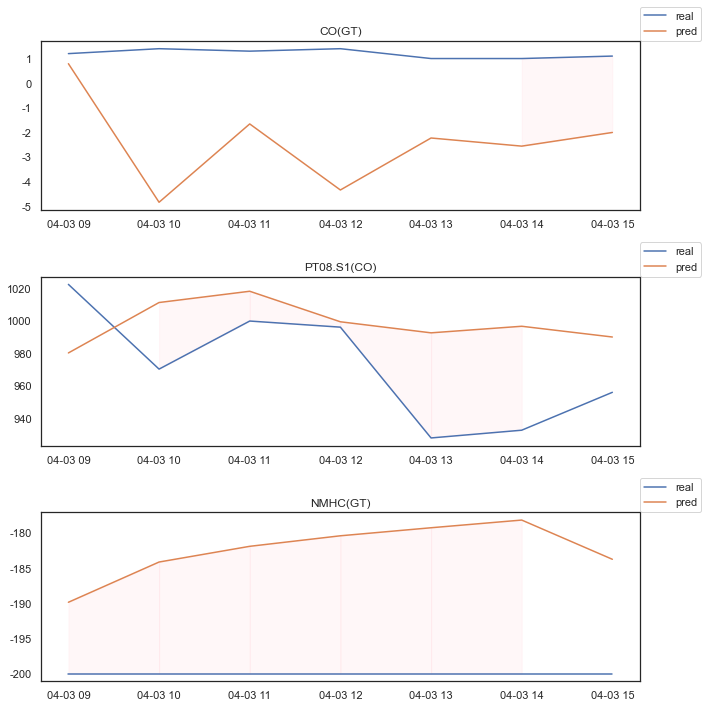

In [720]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

draw_subplot(axes, 0, 'CO(GT)')
draw_subplot(axes, 1, 'PT08.S1(CO)')
draw_subplot(axes, 2, 'NMHC(GT)')

plt.tight_layout()
plt.show()

### (4) Exponential Smoothing
- 직관적이어서 이해하기 쉽고 (ARIMA 대비 상대적으로), 또 시계열 자료의 구성요소가 변동이 느리거나 매우 규칙적(periodic)일 때 예측 정확도가 높음
- 최근 관측한 값에 높은 가중치를 주고, 먼 과거의 관측치에는 낮은 관측치를 주어 가중 평균값을 구함
    - 가중치는 현재로 부터 과거로 갈 수록 지수적으로 감소(exponential decay)시켜서 차등적으로 주는 평활 함수(smoothing function) 사용
    - 여러개의 관측치를 모아서 가중 평균을 사용하기 때문에 "평활(smoothing)"되는 효과가 있음

- 모델의 종류
    - 시계열 자료에 추세(Trend)가 있는지, 추세가 있다면 1차 선형인지 아니면 비선형 인가? 
        - 추세 없음 (No Trend)             --> Simple Exponential Smoothing
        - 1차 선형 추세 (Linear Trend)     --> Two Parameter Exponential Smoothing
        - 2차 비선형 추세 (Quadratic Trend) --> Three Parameter Smoothing
    - 시계열 자료에 계절성(Seasonality)이 있는가? 
        - 계절성 없음 (No Seasonality)
        - 계절성 있음 (with Seasonality)  --> Winters' Method
    - 시계열 자료의 계절성이 시간이 지남에 따라 고정(fixed)되어 있는지 아니면 확산(increasing)되는가? 
        - 고정(상수) 계절 변동 (fixed seasonal variation) --> Additive Model
        - 확산 계절 변동 (increasing seasonal variation) --> Multiplicative Model

In [721]:
data = pd.read_csv('./data/jj.csv')
train, test = data.iloc[:75,:], data.iloc[75:,:]

In [722]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [723]:
# Simple Exponential Smoothing
model_1 = SimpleExpSmoothing(train['data'], initialization_method="estimated").fit()
pred_1 = model_1.predict(start=test['data'].index[0], end=test['data'].index[-1])
model_1.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                       SimpleExpSmoothing Model Results                       
==============================================================================
Dep. Variable:                   data   No. Observations:                   75
Model:             SimpleExpSmoothing   SSE                             37.006
Optimized:                       True   AIC                            -48.980
Trend:                           None   BIC                            -44.345
Seasonal:                        None   AICC                           -48.409
Seasonal Periods:                None   Date:                 Thu, 31 Aug 2023
Box-Cox:                        False   Time:                         13:01:22
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.6392432                alpha                 True
initial_level              0.6940527                  l.0                 True
------------------------------------------------------------------------------
"""

In [724]:
# Trend
model_2 = Holt(train['data'], initialization_method="estimated").fit()
pred_2 = model_2.predict(start=test.index[0], end=test.index[-1])
model_2.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                              Holt Model Results                              
==============================================================================
Dep. Variable:                   data   No. Observations:                   75
Model:                           Holt   SSE                             26.162
Optimized:                       True   AIC                            -70.990
Trend:                       Additive   BIC                            -61.720
Seasonal:                        None   AICC                           -69.755
Seasonal Periods:                None   Date:                 Thu, 31 Aug 2023
Box-Cox:                        False   Time:                         13:01:22
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.2673964                alpha                 True
smoothing_trend            0.2673964                 beta                 True
initial_level              0.6447662                  l.0                 True
initial_trend              0.0004074                  b.0                 True
------------------------------------------------------------------------------
"""

In [725]:
# Multiplicative damped trend
model_3 = Holt(train['data'], exponential=True, damped_trend=True, initialization_method="estimated").fit()
pred_3 = model_3.predict(start=test.index[0], end=test.index[-1])
model_3.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                              Holt Model Results                              
==============================================================================
Dep. Variable:                   data   No. Observations:                   75
Model:                           Holt   SSE                             20.811
Optimized:                       True   AIC                            -86.152
Trend:                 Multiplicative   BIC                            -74.565
Seasonal:                        None   AICC                           -84.480
Seasonal Periods:                None   Date:                 Thu, 31 Aug 2023
Box-Cox:                        False   Time:                         13:01:22
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level           1.4908e-08                alpha                 True
smoothing_trend           1.2868e-12                 beta                 True
initial_level              0.4037075                  l.0                 True
initial_trend              1.0572226                  b.0                 True
damping_trend              0.9938812                  phi                 True
------------------------------------------------------------------------------
"""

In [726]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [727]:
# additive model for fixed seasonal variation
model_4 = ExponentialSmoothing(train['data'], seasonal_periods=4, trend='add', seasonal='add').fit()
pred_4 = model_4.predict(start=test.index[0], end=test.index[-1])
model_4.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                     data   No. Observations:                   75
Model:             ExponentialSmoothing   SSE                              8.157
Optimized:                         True   AIC                           -150.396
Trend:                         Additive   BIC                           -131.857
Seasonal:                      Additive   AICC                          -146.959
Seasonal Periods:                     4   Date:                 Thu, 31 Aug 2023
Box-Cox:                          False   Time:                         13:01:22
Box-Cox Coeff.:                    None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4209202                alpha                 True
smoothing_trend               0.2303729                 beta                 True
smoothing_seasonal            0.5790798                gamma                 True
initial_level                 0.6740587                  l.0                 True
initial_trend                 0.0028867                  b.0                 True
initial_seasons.0             0.0330831                  s.0                 True
initial_seasons.1             0.0014011                  s.1                 True
initial_seasons.2             0.2170391                  s.2                 True
initial_seasons.3            -0.1937149                  s.3                 True
---------------------------------------------------------------------------------
"""

In [728]:
# multiplicative model for increasing seasonal variation
# 시간이 흐름에 따라 분산이 점점 커지는 경우
model_5 = ExponentialSmoothing(train['data'], seasonal='mul', seasonal_periods=4).fit()
pred_5 = model_5.predict(start=test.index[0], end=test.index[-1])
model_5.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                     data   No. Observations:                   75
Model:             ExponentialSmoothing   SSE                             12.588
Optimized:                         True   AIC                           -121.856
Trend:                             None   BIC                           -107.952
Seasonal:                Multiplicative   AICC                          -119.675
Seasonal Periods:                     4   Date:                 Thu, 31 Aug 2023
Box-Cox:                          False   Time:                         13:01:22
Box-Cox Coeff.:                    None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.6440684                alpha                 True
smoothing_seasonal            0.3559316                gamma                 True
initial_level                 0.7223407                  l.0                 True
initial_seasons.0             0.9824570                  s.0                 True
initial_seasons.1             0.9908842                  s.1                 True
initial_seasons.2             1.3160925                  s.2                 True
initial_seasons.3             0.7429790                  s.3                 True
---------------------------------------------------------------------------------
"""

In [729]:
## forecasting for seasons
forecast_1 = model_1.forecast(9)
forecast_2 = model_2.forecast(9)
forecast_3 = model_3.forecast(9)
forecast_4 = model_4.forecast(9)
forecast_5 = model_5.forecast(9)

t_p = pd.DataFrame({'test': test['data'], 'f1': forecast_1, 'f2': forecast_2, 'f3': forecast_3, 'f4': forecast_4, 'f5': forecast_5})
t_p

test         f1         f2         f3         f4         f5
75   8.91  11.961016  12.283881  17.012451  11.006146  10.062659
76  14.04  11.961016  12.819286  17.680459  13.917321  12.782084
77  12.96  11.961016  13.354690  18.370366  14.162288  12.782200
78  14.85  11.961016  13.890094  19.082724  13.675764  11.782636
79   9.99  11.961016  14.425499  19.818091  12.901613  10.062659
80  16.20  11.961016  14.960903  20.577036  15.812788  12.782084
81  14.67  11.961016  15.496308  21.360132  16.057755  12.782200
82  16.02  11.961016  16.031712  22.167963  15.571231  11.782636
83  11.61  11.961016  16.567116  23.001122  14.797080  10.062659

In [730]:
## evaluation metrics
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

## UDF for counting the number of parameters in model
def num_params(model):
    n_params = 0

    for p in list(model.params.values()):
        if isinstance(p, np.ndarray):
            n_params += len(p)
            #print(p)
        elif p in [np.nan, False, None]:
            pass
        elif np.isnan(float(p)):
            pass
        else:
            n_params += 1
            #print(p)
    
    return n_params

# Mean Absolute Percentage Error
def SSE(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.sum((y_test - y_pred)**2)

def ME(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(y_test - y_pred)

def RMSE(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.sqrt(np.mean((y_test - y_pred)**2))   
    #return np.sqrt(MSE(y_test - y_pred))

def MPE(y_test, y_pred): 
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean((y_test - y_pred) / y_test) * 100

def MAPE(y_test, y_pred): 
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

def AIC(y_test, y_pred, T, model):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    sse = np.sum((y_test - y_pred)**2)
    #T = len(y_train) # number of observations
    k = num_params(model) # number of parameters
    return T * np.log(sse/T) + 2*k

def SBC(y_test, y_pred, T, model):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    sse = np.sum((y_test - y_pred)**2)
    #T = len(y_train) # number of observations
    k = num_params(model) # number of parameters
    return T * np.log(sse/T) + k * np.log(T)

def APC(y_test, y_pred, T, model):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    sse = np.sum((y_test - y_pred)**2)
    #T = len(y_train) # number of observations
    k = num_params(model) # number of parameters
    return ((T+k)/(T-k)) * sse / T

def ADJ_R2(y_test, y_pred, T, model):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    sst = np.sum((y_test - np.mean(y_test))**2)
    sse = np.sum((y_test - y_pred)**2)
    #T = len(y_train) # number of observations
    k = num_params(model) # number of parameters
    r2 = 1 - sse/sst
    return 1 - ((T - 1)/(T - k)) * (1 - r2)
    

## Combining all metrics together
def eval_all(y_test, y_pred, T, model):
    sse = SSE(y_test, y_pred)
    mse = MSE(y_test, y_pred)
    rmse = RMSE(y_test, y_pred)
    me = ME(y_test, y_pred)
    mae = MAE(y_test, y_pred)
    mpe = MPE(y_test, y_pred)
    mape = MAPE(y_test, y_pred)
    aic = AIC(y_test, y_pred, T, model)
    sbc = SBC(y_test, y_pred, T, model)
    apc = APC(y_test, y_pred, T, model)
    adj_r2 = ADJ_R2(y_test, y_pred, T, model)
    
    return [sse, mse, rmse, me, mae, mpe, mape, aic, sbc, apc, adj_r2]

In [731]:
T = train.shape[0]

eval_all_df = pd.DataFrame(
    {'SES': eval_all(test['data'], forecast_1, T, model_1), 
    "Trend": eval_all(test['data'], forecast_2, T, model_2), 
    'Multiplicative T': eval_all(test['data'], forecast_3, T, model_3), 
    'Addictive S': eval_all(test['data'], forecast_4, T, model_4), 
    'Multiplicative S': eval_all(test['data'], forecast_5, T, model_5)}, 
    index=['SSE', 'MSE', 'RMSE', 'ME', 'MAE', 'MPE', 'MAPE', 'AIC', 'SBC', 'APC', 'Adj_R2']
)
eval_all_df

SES      Trend  Multiplicative T  Addictive S  Multiplicative S
SSE     68.766127  60.415352        454.153466    28.145362         47.952044
MSE      7.640681   6.712817         50.461496     3.127262          5.328005
RMSE     2.764178   2.590910          7.103626     1.768407          2.308247
ME       1.288984  -1.175499         -6.646705    -0.961332          1.596465
MAE      2.482995   1.935436          6.646705     1.435309          1.868758
MPE      6.104896 -12.322940        -54.956598    -9.431815         10.118652
MAPE    18.770646  17.391230         54.956598    12.536836         13.155099
AIC     -2.508262  -8.218366        145.071029   -55.507915        -19.546502
SBC      2.126714   1.051587        156.658470   -34.650522         -3.324085
APC      0.967122   0.896303          6.920434     0.477618          0.770994
Adj_R2  -0.295382  -0.170133         -7.921764     0.413580          0.030284

In [ ]:
from matplotlib.ticker import MultipleLocator

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


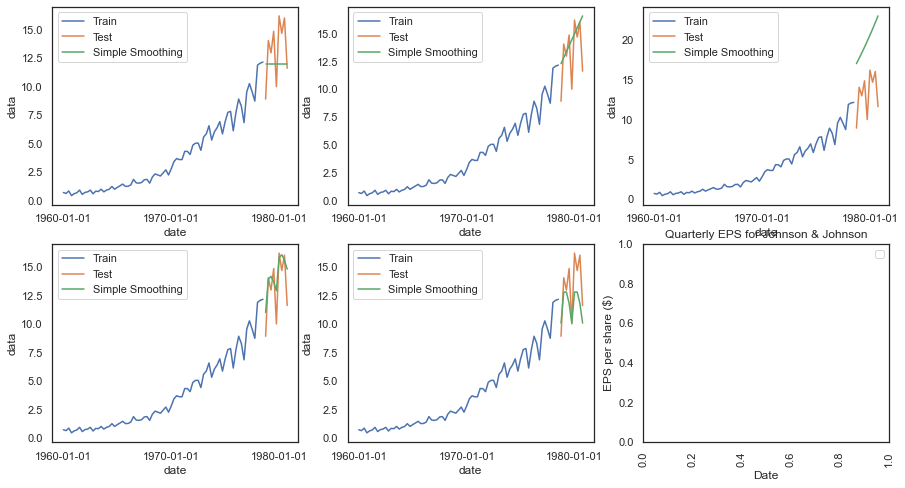

In [732]:
nrows = 2
ncols = 3
pred_idx = {1: pred_1, 2: pred_2, 3: pred_3, 4: pred_4, 5: pred_5}
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 8))
plt.title('Quarterly EPS for Johnson & Johnson')
plt.ylabel('EPS per share ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.legend()

for i in range(5):
    row = i // 3
    col = i % 3
    sns.lineplot(x=train['date'], y=train['data'], label='Train', ax=axes[row][col])
    sns.lineplot(x=test['date'], y=test['data'], label='Test', ax=axes[row][col])
    axes[row][col].xaxis.set_major_locator(MultipleLocator(40))
    sns.lineplot(x=pred_idx[i + 1].index, y=pred_idx[i + 1], label='Simple Smoothing', ax=axes[row][col])

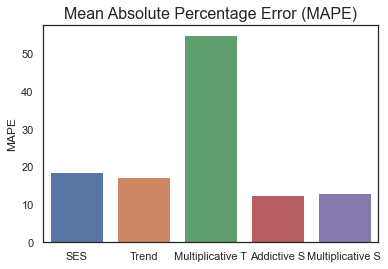

In [733]:
# horizontal bar chart
sns.barplot(x=eval_all_df.columns, y=eval_all_df.loc['MAPE', :])
plt.title('Mean Absolute Percentage Error (MAPE)', fontsize=16)
plt.show()